"Vorgeplänkel"
===========

- Anstrich 1
- Anstrich 2

**Fett** *kursiv* 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statannotations.Annotator import Annotator
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import spearmanr

# Kommentare beginnen mit einer Raute und werden ignoriert

# Grundlegende Gestaltungs-Einstellung
sns.set_theme(style='whitegrid', palette='Set2', context='notebook') 
# Alternativen: 
# style = darkgrid, whitegrid, white, dark, ticks
# palette = hls, husl, Set2, Paired, rocket, cubehelix




## Hier werden alle Dateien eingelesen 
df = pd.read_excel('Daten_Masterarbeit_ohne_Klarnamen.xlsx')
df.replace(-999, np.nan, inplace=True) # alle -999 gegen NA austauschen, damit die Boxplots diese nicht mit einbeziehen

df=df.query("group != 'SPMS'") # SPMS aus Daten rausgenommen
# df_healthy_healthy = df.query('(group == "controls" and EDSS <= 0.5)  or (group != "controls") ')

df['total_lesion_volume'] =  df['deepwm volume'] + df['infratentorial volume'] + df['juxtacortical volume'] + df['paraventricular volume']
# = Läsionsvolumen zusammengerechnet

df['total_lesion_count'] = df['deepwm n_lesions'] + df['infratentorial n_lesions'] + df['juxtacortical n_lesions'] + df['paraventricular n_lesions']
# = Läsionsanzahl zusammengerechnet

# cognitve SDMT Impairment anhand SDMT
df.loc[df['SDMT'] >= 55, "cognitve SDMT"] = "CP"
df.loc[df['SDMT'] < 55, "cognitve SDMT"] = "CI"

# === DoD ====
# für diseaseDuration nehmen wir das Diagnose-Datum. Die Erstmanifestation (Manifestation_MS) ist zu ungenau/schwammig
df["DoD"] = df["MRT Date"] - df.Diagnosis_MS # erst die Differenz bilden
df.DoD = round(df.DoD.dt.days / 365.25)  # die Differenz wird jetzt als einfacher Zahlenwert in Jahren umgewandelt

# cognitve SDMT Impairment - ganz oben deklariert
hc_SDMT_mean = df.query('group == "controls" ')['SDMT'].mean()
hc_SDMT_std = df.query('group == "controls" ')['SDMT'].std()

# cognitve CVLT Impairment - ganz oben deklariert
hc_CVLT_mean = df.query('group == "controls" ')['CVLT_Total'].mean()
hc_CVLT_std = df.query('group == "controls" ')['CVLT_Total'].std()

# cognitve BVMT Impairment - ganz oben deklariert
hc_BVMT_mean = df.query('group == "controls" ')['BVMT-R_Total'].mean()
hc_BVMT_std = df.query('group == "controls" ')['BVMT-R_Total'].std()

# SDMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
SDMT_border = hc_SDMT_mean - 1.5 * hc_SDMT_std

# CLVLT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
CVLT_border = hc_CVLT_mean - 1.5 * hc_CVLT_std

# BVMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
BVMT_border = hc_BVMT_mean - 1.5 * hc_BVMT_std

df.loc[df['SDMT'] >= SDMT_border , "SDMT, mit CI/CP"] = "CP"
df.loc[df['SDMT'] < SDMT_border, "SDMT, mit CI/CP"] = "CI"

df.loc[df['CVLT_Total'] >= SDMT_border , "CVLT_Total, mit CI/CP"] = "CP"
df.loc[df['CVLT_Total'] < SDMT_border, "CVLT_Total, mit CI/CP"] = "CI"

df.loc[df['BVMT-R_Total'] >= SDMT_border , "BVMT-R_Total, mit CI/CP"] = "CP"
df.loc[df['BVMT-R_Total'] < SDMT_border, "BVMT-R_Total, mit CI/CP"] = "CI"

# Balken:
## Hier werden alle Dateien eingelesen 
cc_df = pd.read_excel('cc_lesions.xlsx')
cc_df.subject = cc_df['subject'].astype('str').str.zfill(5).replace(r'^(\w{2})', r'\1-', regex=True)

cc_df = df.merge(right=cc_df, right_on='subject', left_on='ID')

# group_names = ['controls', 'CIS', 'RRMS', 'SPMS']
# cc_df['group_name'] = cc_df.apply(lambda x: group_names[int(x.group)], axis=1)
# cc_df = cc_df.query('group_name != "SPMS"')

cc_df['ID'] = cc_df.subject.astype(str)
cc_df.ID = cc_df.ID.str.zfill(5)
cc_df.ID = cc_df.apply(lambda x: f'{x["ID"][:2]}-{x["ID"][2:]}', axis=1 )

In [2]:
cc_df['subject'].astype('str').str.zfill(5).replace(r'^(\w{2})', r'\1-', regex=True)

0      00--002
1      00--004
2      00--009
3      00--010
4      00--015
        ...   
102    02--041
103    02--043
104    02--044
105    02--045
106    02--046
Name: subject, Length: 107, dtype: object

Erstmal Demografie/Altersverteilung der Kontrollen und Patienten

In [3]:
for gruppe in  set(df.group.to_list()):
    print(f"{gruppe} {len(df.query('group==@gruppe'))}")

RRMS 35
controls 59
CIS 15


In [4]:
demographics = df.groupby('group')[['Age','DoD','EDSS']].agg(["mean", "std"]).transpose()
dfsex = pd.concat((df.query('Sex=="f"').groupby('group')[['Sex']].agg("count"), df.query('Sex=="m"').groupby('group')[['Sex']].agg("count")),axis=1)
dfsex.columns=['Sex(f)', 'Sex(m)']
dfsex = dfsex.transpose()
demographics = pd.concat((demographics, dfsex), axis=0)
demographics

group               CIS       RRMS   controls
(Age, mean)   31.666667  37.742857  34.237288
(Age, std)     7.403345   7.321776   9.976419
(DoD, mean)    0.750000   5.685714        NaN
(DoD, std)     0.462910   3.786753        NaN
(EDSS, mean)   2.200000   2.157143   0.888889
(EDSS, std)    0.751190   0.929670   0.768892
Sex(f)        11.000000  20.000000  38.000000
Sex(m)         4.000000  15.000000  21.000000

# Demografie

1. Allgemeine Demografie Patienten vs. Kontrollen unterschieden nach m/w

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False_m vs. True_m: Mann-Whitney-Wilcoxon test two-sided, P_val:8.388e-01 U_stat=1.915e+02


/tmp/nix-shell-7033-0/ipykernel_38878/3116555669.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(df, y='Age', x='control', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True ) # Alle als Einzelpunkte# Kontrollen gegen die Patienten dargestellt
/tmp/nix-shell-7033-0/ipykernel_38878/3116555669.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["Controls", "Patients"])                                 # umbennenen der Achsenbeschriftung


False_f vs. True_f: Mann-Whitney-Wilcoxon test two-sided, P_val:1.193e-01 U_stat=7.185e+02


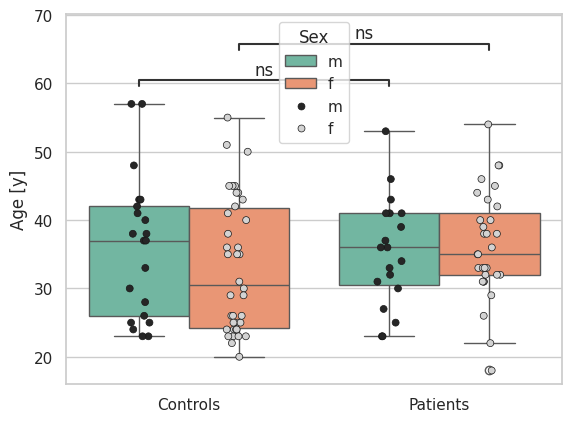

In [5]:
# Die Spalte "control" ist True für alle Kontrollen und False für alle Patienten und dient zur einfachen Identifikation der Kontrollen/Patienten
g = sns.boxplot(df, y='Age', x='control', hue='Sex', order=[True, False])   # wenn man hier "hue='Sex'" weglässt wird nur die Gesamtpopulation der
sns.stripplot(df, y='Age', x='control', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True ) # Alle als Einzelpunkte# Kontrollen gegen die Patienten dargestellt
g.set_xticklabels(["Controls", "Patients"])                                 # umbennenen der Achsenbeschriftung 
g.set_xlabel("")                                                            
g.set_ylabel("Age [y]")

# Add annotations
pairs=[ 
    ((True, 'm'), (False, 'm')),
    ((True,'f'), (False, 'f'))
         ]
annotator = Annotator(g, pairs, data=df, x='control', y='Age', hue='Sex')
annotator.configure(test='Mann-Whitney').apply_and_annotate()
plt.savefig('Geschlechterverteilung.svg') # speichern als vektorgrafik



## Selbes ohne "Sex"

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False_m vs. True_m: Mann-Whitney-Wilcoxon test two-sided, P_val:8.388e-01 U_stat=1.915e+02
False_f vs. True_f: Mann-Whitney-Wilcoxon test two-sided, P_val:1.193e-01 U_stat=7.185e+02


/tmp/nix-shell-7033-0/ipykernel_38878/938338147.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["Controls", "Patients"])                                 # umbennenen der Achsenbeschriftung


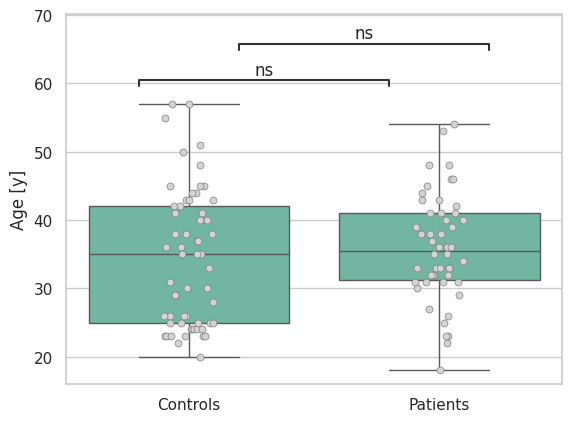

In [6]:
# Die Spalte "control" ist True für alle Kontrollen und False für alle Patienten und dient zur einfachen Identifikation der Kontrollen/Patienten
g = sns.boxplot(df, y='Age', x='control', order=[True, False])   # wenn man hier "hue='Sex'" weglässt wird nur die Gesamtpopulation der
sns.stripplot(df, y='Age', x='control', linewidth=0.5, color='lightgrey', dodge=True ) # Alle als Einzelpunkte# Kontrollen gegen die Patienten dargestellt
g.set_xticklabels(["Controls", "Patients"])                                 # umbennenen der Achsenbeschriftung 
g.set_xlabel("")                                                            
g.set_ylabel("Age [y]")

# Add annotations
pairs=[ 
    ((True, 'm'), (False, 'm')),
    ((True,'f'), (False, 'f'))
         ]
annotator = Annotator(g, pairs, data=df, x='control', y='Age', hue='Sex')
annotator.configure(test='Mann-Whitney').apply_and_annotate()
plt.savefig('Geschlechterverteilung.svg') # speichern als vektorgrafik


In [7]:
# Darstellung Alter und Geschlecht der einzelnen Gruppen

In [8]:
df.control

0       True
1       True
2       True
3       True
4       True
       ...  
104    False
105    False
106    False
107    False
108    False
Name: control, Length: 109, dtype: bool

2. Alter nach Gruppen

/tmp/nix-shell-7033-0/ipykernel_38878/824443865.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(df, y='Age', x='group', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True) # Alle als Einzelpunkte


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.631e-01 U_stat=4.975e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.659e-02 U_stat=1.490e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.411e-02 U_stat=7.860e+02


(<Axes: ylabel='Age [y]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d8dbd3d0>])

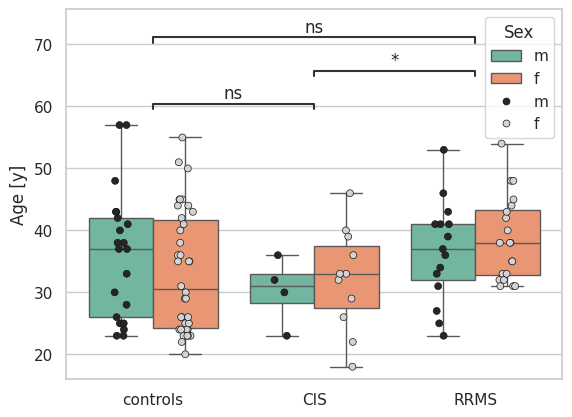

In [9]:
g = sns.boxplot(df, y='Age', x='group', hue='Sex', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='Age', x='group', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True) # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("Age [y]")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='Age')
annotator.configure(test='Mann-Whitney').apply_and_annotate()




## Demografie - Alter ohne p-Wert

3. Geschlecht nach Gruppen

/tmp/nix-shell-7033-0/ipykernel_38878/9751110.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(df, y='Age', x='group', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True) # Alle als Einzelpunkte


Text(0, 0.5, 'Age [y]')

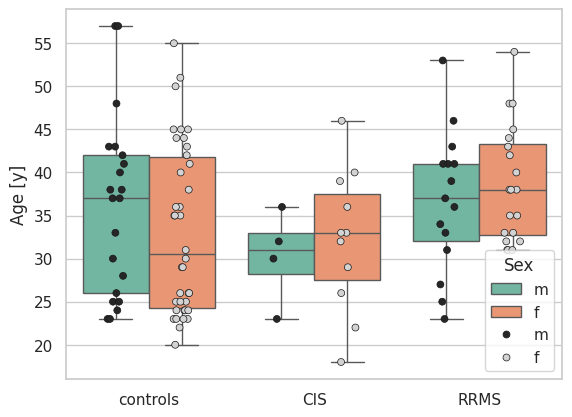

In [10]:
g = sns.boxplot(df, y='Age', x='group', hue='Sex', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='Age', x='group', hue='Sex', linewidth=0.5, color='lightgrey', dodge=True) # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("Age [y]")

In [11]:
# weiß ich nicht


In [12]:
# g = sns.boxplot(df_healthy_healthy, y='Age', x='group', fliersize=0) # Boxplot ohne Ausreißer
# sns.stripplot(df_healthy_healthy, y='Age', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_xlabel("")
# g.set_ylabel("Age [y]")

# # Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='Age')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Tabelle Demografie

In [13]:
df.groupby(by=['group']).agg({
    'Age': ['mean', 'std'], 
    'EDSS': ['mean', 'std'],
    'Sex' : [lambda x: x[x=='f'].str.len().sum(),
            lambda x: x[x=='m'].str.len().sum() ]                  
                              }).transpose()


group                  CIS       RRMS   controls
Age  mean        31.666667  37.742857  34.237288
     std          7.403345   7.321776   9.976419
EDSS mean         2.200000   2.157143   0.888889
     std          0.751190   0.929670   0.768892
Sex  <lambda_0>  11.000000  20.000000  38.000000
     <lambda_1>   4.000000  15.000000  21.000000

In [14]:
df.EDSS.describe()

count    104.000000
mean       1.504808
std        1.039266
min        0.000000
25%        1.000000
50%        1.500000
75%        2.000000
max        4.000000
Name: EDSS, dtype: float64

## Tabelle demografie, ergänzt um Krankheitsdauer, BICAMS

In [15]:
df.groupby(by=['group']).agg({
    'Age': ['mean', 'std'], 
    'EDSS': ['mean', 'std'],
    'Sex' : [lambda x: x[x=='f'].str.len().sum(),
            lambda x: x[x=='m'].str.len().sum()],
    'bpf': ['mean', 'std'],
    'total_lesion_count': ['mean', 'std'],
    'total_lesion_volume': ['mean', 'std'],
    'SDMT': ['mean', 'std'],
    'CVLT_Total': ['mean', 'std'],
    'BVMT-R_Total': ['mean', 'std']
                              }).transpose()

    

group                                 CIS       RRMS   controls
Age                 mean        31.666667  37.742857  34.237288
                    std          7.403345   7.321776   9.976419
EDSS                mean         2.200000   2.157143   0.888889
                    std          0.751190   0.929670   0.768892
Sex                 <lambda_0>  11.000000  20.000000  38.000000
                    <lambda_1>   4.000000  15.000000  21.000000
bpf                 mean         0.780382   0.755256   0.774883
                    std          0.023722   0.021583   0.021620
total_lesion_count  mean        31.733333  56.742857   8.881356
                    std         31.019502  56.383844   9.404850
total_lesion_volume mean         3.377333   7.404571   0.522712
                    std          4.144338  11.865322   0.780411
SDMT                mean        66.933333  56.542857  66.767857
                    std          9.414781  11.986126  11.933134
CVLT_Total          mean        62.000000  64.542857  67.089286
                    std         11.874342   9.322152   7.423003
BVMT-R_Total        mean        31.000000  28.800000  30.589286
                    std          4.053217   4.837355   4.834636

# LESIONS

## DeepWM Läsionsvolumen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.764e-06 U_stat=1.025e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.194e-02 U_stat=1.770e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.337e-12 U_stat=1.365e+02


(<Axes: title={'center': 'deepWM, Lesionsvolume'}, ylabel='Lesionvolume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d6a9fc80>])

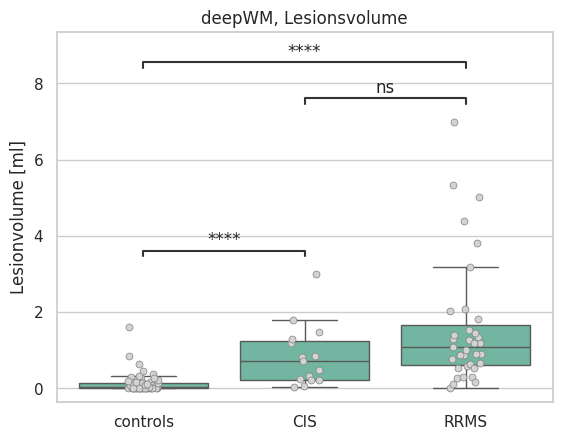

In [16]:
g = sns.boxplot(df, y='deepwm volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='deepwm volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte 
g.set_ylabel("Lesionvolume [ml]")
g.set_xlabel("")
g.set_title("deepWM, Lesionsvolume")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='deepwm volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [17]:
df.query("`deepwm volume` > 1 and group=='controls'")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex Bemerkungen  \
6           6  18.0      0  00-018 2020-03-06 2020-03-03   55   f         NaN   

  Education  ...  lateralventricle_left percentile thirdventricle percentile  \
6       NaN  ...                             86.13                     97.43   

  fourthventricle percentile total_lesion_volume total_lesion_count  \
6                      34.14                5.81                 61   

  cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
6            CP  NaN               CP                     CP   

   BVMT-R_Total, mit CI/CP  
6                       CI  

[1 rows x 157 columns]

## Infratentorielles Läsionsvolumen

Text(0.5, 1.0, 'Infratentorial Lesionsvolume')

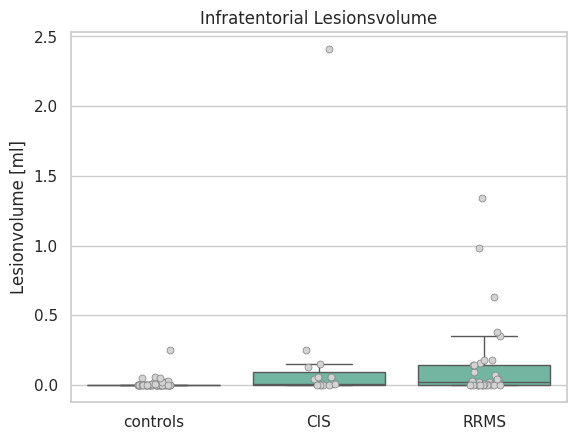

In [18]:
g = sns.boxplot(df, y='infratentorial volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='infratentorial volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte)
g.set_ylabel("Lesionvolume [ml]")
g.set_xlabel("")
g.set_title("Infratentorial Lesionsvolume")

In [19]:
df.query("`infratentorial volume` > 2 and group=='CIS'")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
73          73  67.0      1  01-016 2024-05-16 2024-05-16   22   f   

   Bemerkungen Education  ...  lateralventricle_left percentile  \
73           *       NaN  ...                             76.13   

   thirdventricle percentile fourthventricle percentile total_lesion_volume  \
73                     66.59                      50.26               16.53   

   total_lesion_count cognitve SDMT  DoD  SDMT, mit CI/CP  \
73                127            CP  NaN               CP   

    CVLT_Total, mit CI/CP  BVMT-R_Total, mit CI/CP  
73                     CP                       CI  

[1 rows x 157 columns]

## Juxtakortikales Läsionsvolumen

Text(0.5, 1.0, 'Juxtacortical Lesionsvolume')

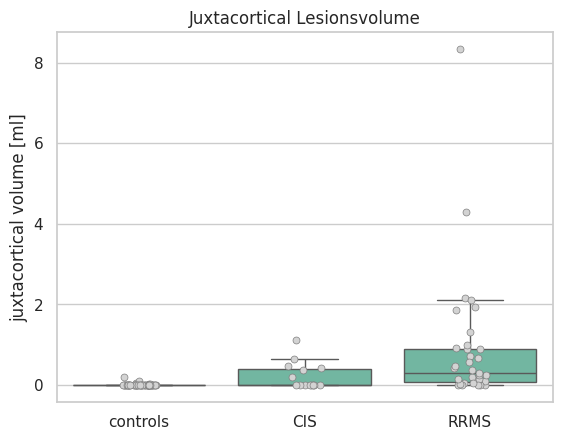

In [20]:
g = sns.boxplot(df, y='juxtacortical volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='juxtacortical volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("juxtacortical volume [ml]")
g.set_xlabel("")
g.set_title("Juxtacortical Lesionsvolume")

In [21]:
df.query("`juxtacortical volume` > 3 and group=='RRMS'")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
80           80  10.0      2  02-008 2019-11-18 2019-11-18   23   m   
101         101  45.0      2  02-037 2021-06-21 2021-06-28   41   m   

                                           Bemerkungen Education  ...  \
80   (1) - Dicom-pdf.; (2) - Analysefehler Läsionen...       NaN  ...   
101      (1) - Dicom-pdf; (2) - Analysefehler Läsionen       NaN  ...   

     lateralventricle_left percentile thirdventricle percentile  \
80                              99.26                     99.56   
101                             69.61                     85.46   

    fourthventricle percentile total_lesion_volume total_lesion_count  \
80                       44.45               65.84                204   
101                      63.54               15.60                173   

    cognitve SDMT   DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
80             CP   2.0               CP                     CP   
101            CI  13.0               CI                     CP   

     BVMT-R_Total, mit CI/CP  
80                        CI  
101                       CI  

[2 rows x 157 columns]

## Paraventrikuläres Läsionsvolumen

Text(0.5, 1.0, 'Paraventricular Lesionsvolume')

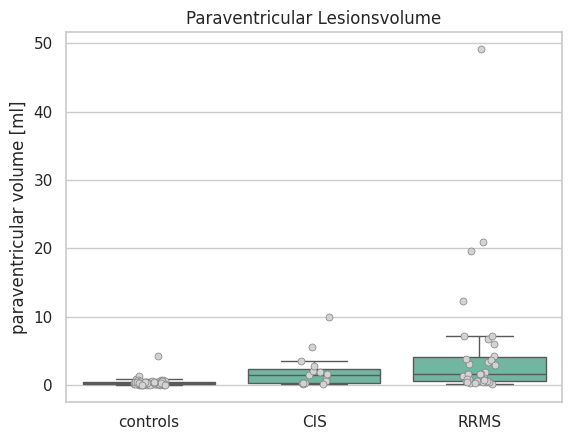

In [22]:
g = sns.boxplot(df, y='paraventricular volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='paraventricular volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("paraventricular volume [ml]")
g.set_xlabel("")
g.set_title("Paraventricular Lesionsvolume")

In [23]:
df.query("`paraventricular volume` > 15 and group=='RRMS'")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
80          80  10.0      2  02-008 2019-11-18 2019-11-18   23   m   
94          94  34.0      2  02-026 2020-03-09 2020-03-06   41   m   
98          98  43.0      2  02-034 2020-09-08 2020-09-02   27   m   

                                          Bemerkungen Education  ...  \
80  (1) - Dicom-pdf.; (2) - Analysefehler Läsionen...       NaN  ...   
94                                                NaN       NaN  ...   
98  (1) - Dicom-pdf; (2) - Analysefehler Läsionen ...       NaN  ...   

    lateralventricle_left percentile thirdventricle percentile  \
80                             99.26                     99.56   
94                             99.87                    100.00   
98                             98.70                     96.55   

   fourthventricle percentile total_lesion_volume total_lesion_count  \
80                      44.45               65.84                204   
94                      68.73               23.25                 58   
98                      43.31               21.62                 40   

   cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
80            CP  2.0               CP                     CP   
94            CI  7.0               CP                     CI   
98            CI  5.0               CP                     CP   

    BVMT-R_Total, mit CI/CP  
80                       CI  
94                       CI  
98                       CI  

[3 rows x 157 columns]

## Anzahl Läsionen, deepWM

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.066e-05 U_stat=1.395e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.051e-01 U_stat=1.855e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-11 U_stat=2.005e+02


(<Axes: title={'center': 'deepWM, count of lesions'}, ylabel='count of lesions [p]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d687fd10>])

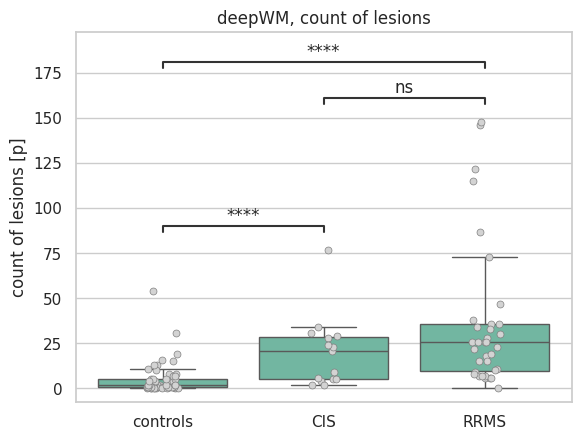

In [24]:
g = sns.boxplot(df, y='deepwm n_lesions', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='deepwm n_lesions', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("count of lesions [p]")
g.set_xlabel("")
g.set_title("deepWM, count of lesions")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='deepwm n_lesions')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Anzahl Läsionen infratentoriell

Text(0.5, 1.0, 'infratentorial, number of lesions')

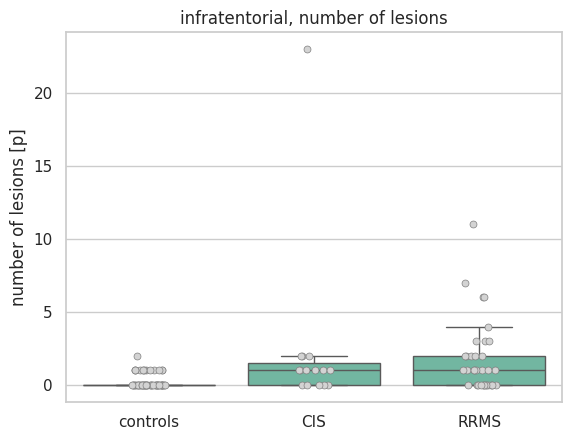

In [25]:
g = sns.boxplot(df, y='infratentorial n_lesions', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='infratentorial n_lesions', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("number of lesions [p]")
g.set_xlabel("")
g.set_title("infratentorial, number of lesions")

## Anzahl Läsionen juxtakortikal

Text(0.5, 1.0, 'juxtacortical, number of lesions')

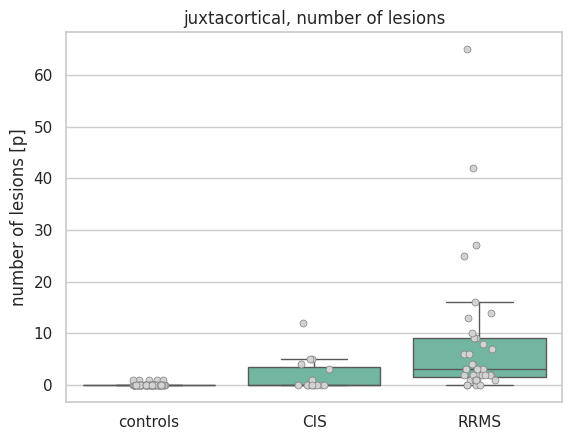

In [26]:
g = sns.boxplot(df, y='juxtacortical n_lesions', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='juxtacortical n_lesions', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("number of lesions [p]")
g.set_xlabel("")
g.set_title("juxtacortical, number of lesions")

## Anzahl Läsionen paraventriculär

Text(0.5, 1.0, 'paraventricular, number of lesions')

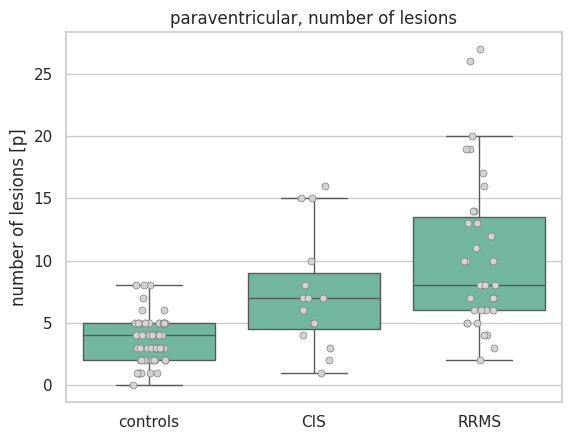

In [27]:
g = sns.boxplot(df, y='paraventricular n_lesions', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='paraventricular n_lesions', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("number of lesions [p]")
g.set_xlabel("")
g.set_title("paraventricular, number of lesions")

# VOLUMETRY

## White matter total Volumen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.652e-02 U_stat=6.080e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.032e-01 U_stat=2.440e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.892e-03 U_stat=1.368e+03


(<Axes: title={'center': 'white matter total volume'}, ylabel='white matter volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d6682ab0>])

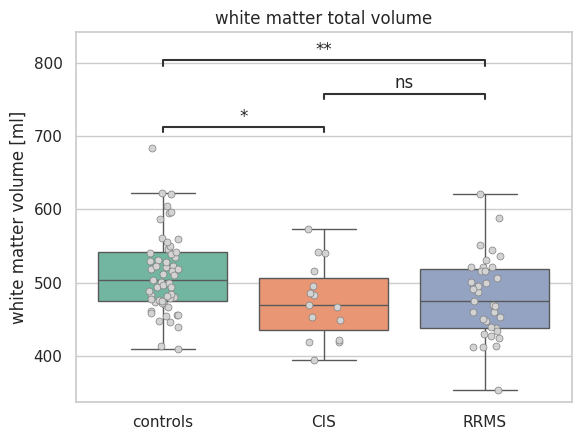

In [28]:
g = sns.boxplot(df, y='white_matter_total volume', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='white_matter_total volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("white matter volume [ml]")
g.set_xlabel("")
g.set_title("white matter total volume")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='white_matter_total volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [29]:
df.query("`white_matter_total volume` > 650")
# abfrage Suche nach Ausreisser-Daten


Unnamed: 0   Nr.  Group      ID Test Date   MRT Date  Age Sex  \
32          32  57.0      0  00-057       NaT 2022-09-09   28   m   

                   Bemerkungen Education  ...  \
32  nicht in Tabelle enthalten       NaN  ...   

    lateralventricle_left percentile thirdventricle percentile  \
32                             99.91                     57.53   

   fourthventricle percentile total_lesion_volume total_lesion_count  \
32                      61.05                0.19                 10   

   cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
32           NaN  NaN              NaN                    NaN   

    BVMT-R_Total, mit CI/CP  
32                      NaN  

[1 rows x 157 columns]

## Gray matter total Volume

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.677e-01 U_stat=5.100e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.516e-01 U_stat=3.070e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.495e-03 U_stat=1.388e+03


(<Axes: title={'center': 'gray matter total volume'}, ylabel='gray matter volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d66738c0>])

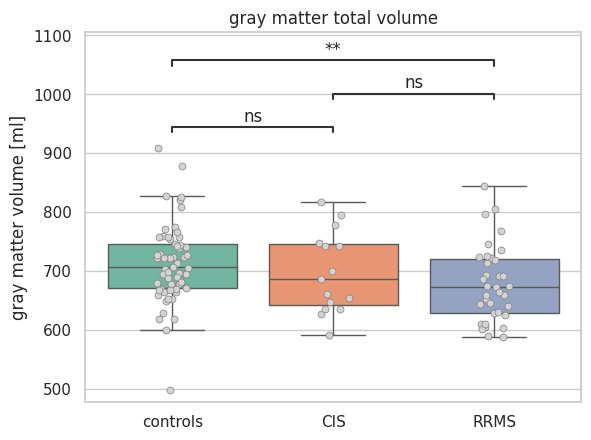

In [30]:
g = sns.boxplot(df, y='gray_matter_total volume', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='gray_matter_total volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("gray matter volume [ml]")
g.set_xlabel("")
g.set_title("gray matter total volume")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='gray_matter_total volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [31]:
df.query("`gray_matter_total volume` > 850")
# abfrage Suche nach Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
17          17  36.0      0  00-036 2022-01-05 2022-01-07   24   m   
32          32  57.0      0  00-057        NaT 2022-09-09   28   m   

                   Bemerkungen Education  ...  \
17                         NaN  Bachelor  ...   
32  nicht in Tabelle enthalten       NaN  ...   

    lateralventricle_left percentile thirdventricle percentile  \
17                             73.89                     56.14   
32                             99.91                     57.53   

   fourthventricle percentile total_lesion_volume total_lesion_count  \
17                      78.54                0.74                 17   
32                      61.05                0.19                 10   

   cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
17            CP  NaN               CP                     CP   
32           NaN  NaN              NaN                    NaN   

    BVMT-R_Total, mit CI/CP  
17                       CI  
32                      NaN  

[2 rows x 157 columns]

In [32]:
df.query("`gray_matter_total volume` < 550")
# abfrage Suche nach Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
26          26  50.0      0  00-050 2022-03-03 2022-03-10   45   f   

   Bemerkungen Education  ...  lateralventricle_left percentile  \
26         NaN    Abitur  ...                             90.11   

   thirdventricle percentile fourthventricle percentile total_lesion_volume  \
26                     91.16                      35.86                1.89   

   total_lesion_count cognitve SDMT  DoD  SDMT, mit CI/CP  \
26                 27            CP  NaN               CP   

    CVLT_Total, mit CI/CP  BVMT-R_Total, mit CI/CP  
26                     CP                       CI  

[1 rows x 157 columns]

## Brain-segmentation-volume

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.502e-01 U_stat=5.500e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.966e-01 U_stat=2.880e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.902e-03 U_stat=1.402e+03


(<Axes: title={'center': 'brain segmentation volume'}, ylabel='brain segmentation volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d6683d70>])

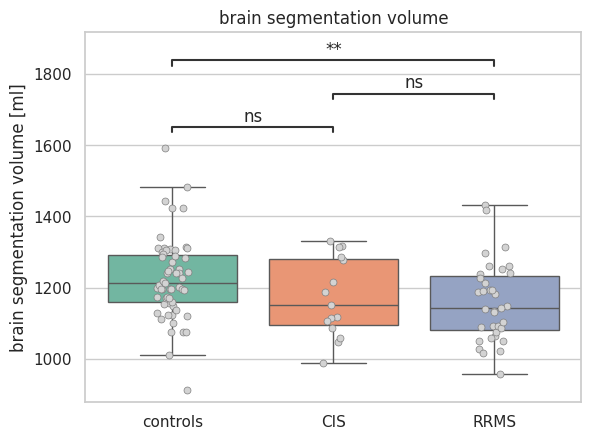

In [33]:
g = sns.boxplot(df, y='brain_segmentation volume', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='brain_segmentation volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("brain segmentation volume [ml]")
g.set_xlabel("")
g.set_title("brain segmentation volume")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='brain_segmentation volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [34]:
df.query("`brain_segmentation volume` > 1500 or `brain_segmentation volume` < 950")
# abfrage Suche nach Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
26          26  50.0      0  00-050 2022-03-03 2022-03-10   45   f   
32          32  57.0      0  00-057        NaT 2022-09-09   28   m   

                   Bemerkungen Education  ...  \
26                         NaN    Abitur  ...   
32  nicht in Tabelle enthalten       NaN  ...   

    lateralventricle_left percentile thirdventricle percentile  \
26                             90.11                     91.16   
32                             99.91                     57.53   

   fourthventricle percentile total_lesion_volume total_lesion_count  \
26                      35.86                1.89                 27   
32                      61.05                0.19                 10   

   cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
26            CP  NaN               CP                     CP   
32           NaN  NaN              NaN                    NaN   

    BVMT-R_Total, mit CI/CP  
26                       CI  
32                      NaN  

[2 rows x 157 columns]

## cortical_gray_matter_total volume

Text(0.5, 1.0, 'Volume, frontal left')

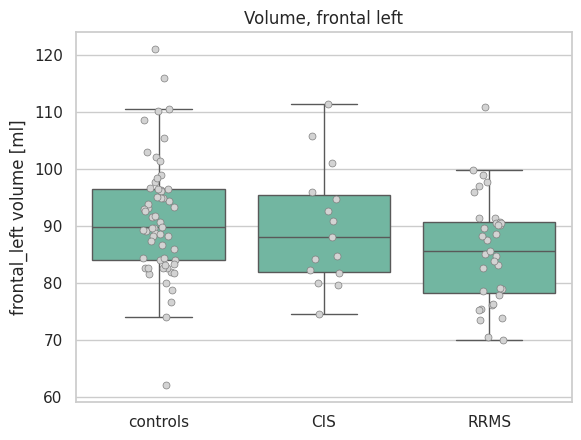

In [35]:
g = sns.boxplot(df, y='frontal_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='frontal_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("frontal_left volume [ml]")
g.set_xlabel("")
g.set_title("Volume, frontal left")

## frontal_left volume

Text(0.5, 1.0, 'Frontal Left Volume')

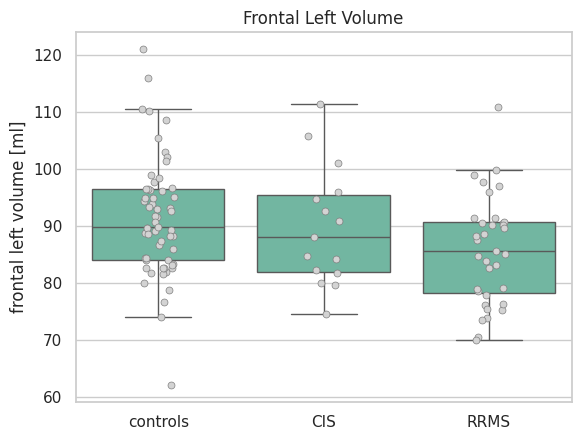

In [36]:
g = sns.boxplot(df, y='frontal_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='frontal_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("frontal left volume [ml]")
g.set_xlabel("")
g.set_title("Frontal Left Volume")

## parietal_left volume

Text(0.5, 1.0, 'Parietal Left Volume')

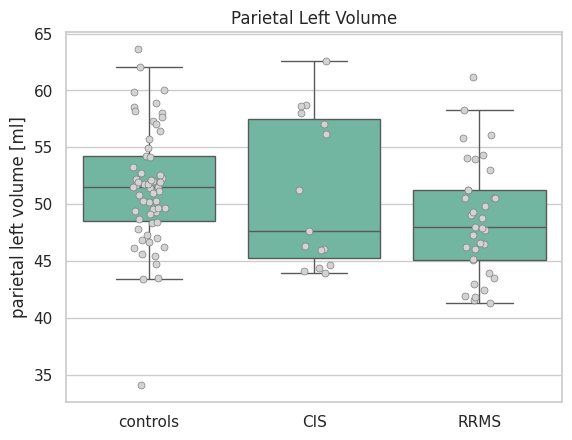

In [37]:
g = sns.boxplot(df, y='parietal_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parietal_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parietal left volume [ml]")
g.set_xlabel("")
g.set_title("Parietal Left Volume")

## precuneus_left volume

Text(0.5, 1.0, 'Precuneus Left Volume')

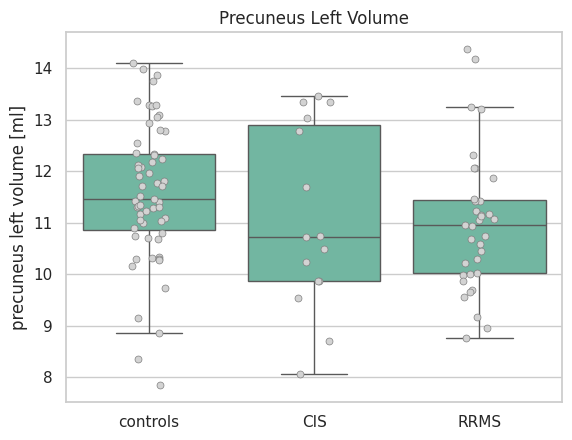

In [38]:
g = sns.boxplot(df, y='precuneus_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='precuneus_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("precuneus left volume [ml]")
g.set_xlabel("")
g.set_title("Precuneus Left Volume")

## occipital_left volume

Text(0.5, 1.0, 'occipital_left volume')

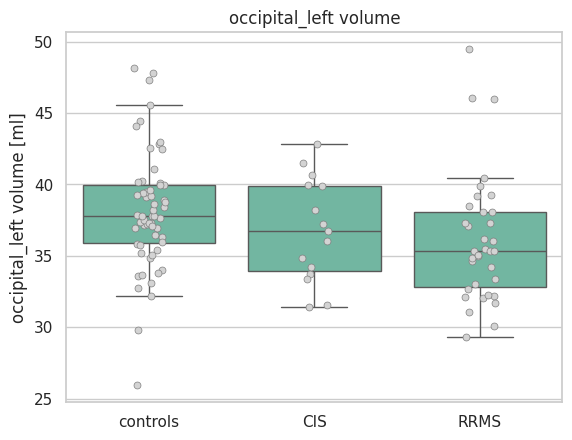

In [39]:
g = sns.boxplot(df, y='occipital_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='occipital_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("occipital_left volume [ml]")
g.set_xlabel("")
g.set_title("occipital_left volume")

## temporal_left volume

Text(0.5, 1.0, 'temporal_left volume')

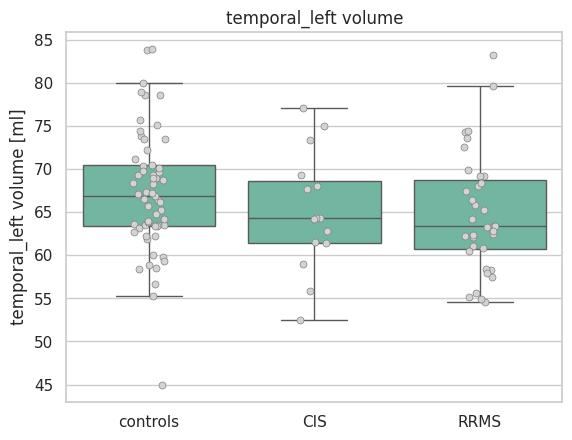

In [40]:
g = sns.boxplot(df, y='temporal_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='temporal_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("temporal_left volume [ml]")
g.set_xlabel("")
g.set_title("temporal_left volume")

## hippocampus_left volume

Text(0.5, 1.0, 'hippocampus_left volume')

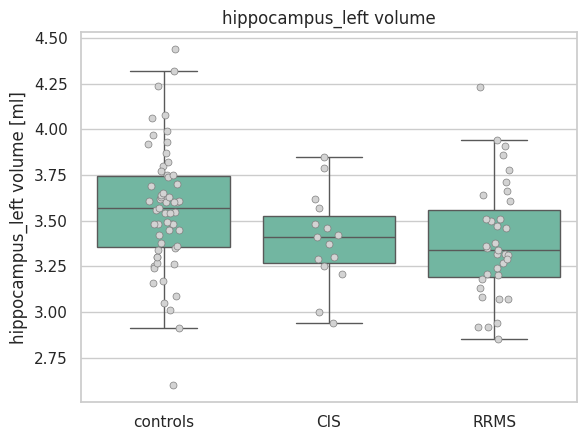

In [41]:
g = sns.boxplot(df, y='hippocampus_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='hippocampus_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("hippocampus_left volume [ml]")
g.set_xlabel("")
g.set_title("hippocampus_left volume")

## parahippocampus_gyrus_left volume

Text(0.5, 1.0, 'parahippocampus_gyrus_left volume')

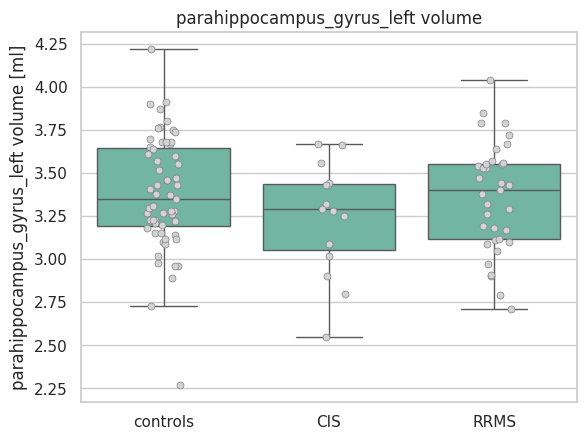

In [42]:
g = sns.boxplot(df, y='parahippocampus_gyrus_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parahippocampus_gyrus_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parahippocampus_gyrus_left volume [ml]")
g.set_xlabel("")
g.set_title("parahippocampus_gyrus_left volume")

## entorhinal_left volume

Text(0.5, 1.0, 'entorhinal_left volume')

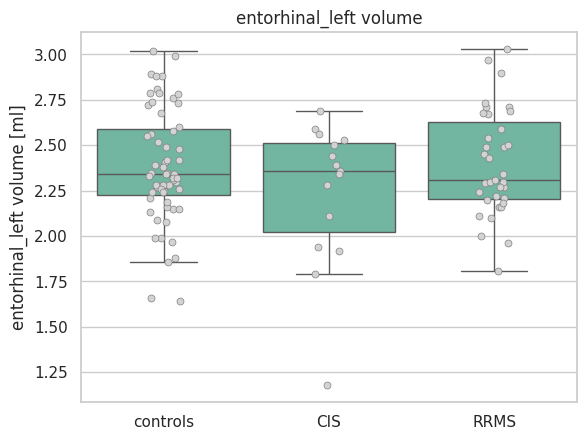

In [43]:
g = sns.boxplot(df, y='entorhinal_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='entorhinal_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("entorhinal_left volume [ml]")
g.set_xlabel("")
g.set_title("entorhinal_left volume")

## caudate_left volume

Text(0.5, 1.0, 'caudate_left volume')

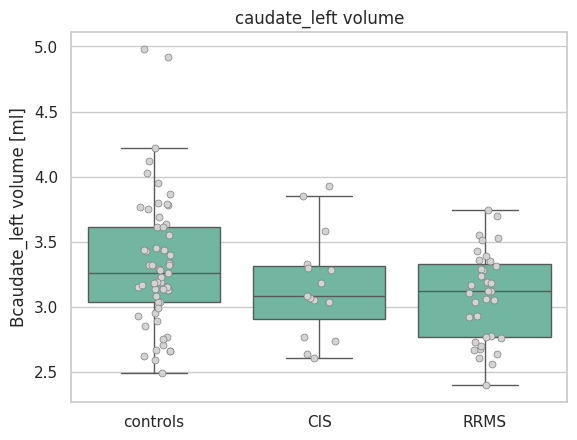

In [44]:
g = sns.boxplot(df, y='caudate_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='caudate_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("Bcaudate_left volume [ml]")
g.set_xlabel("")
g.set_title("caudate_left volume")

## putamen_left volume

Text(0.5, 1.0, 'putamen_left volume')

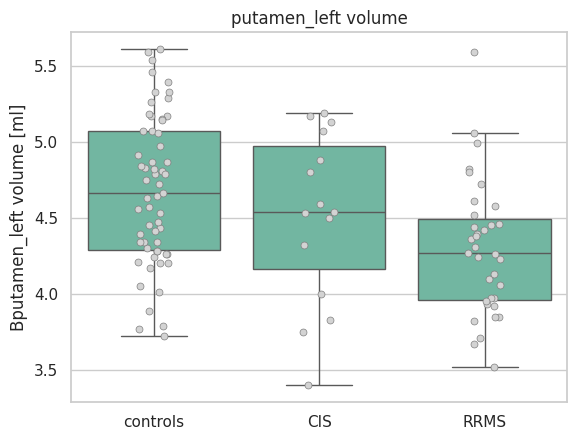

In [45]:
g = sns.boxplot(df, y='putamen_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='putamen_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("Bputamen_left volume [ml]")
g.set_xlabel("")
g.set_title("putamen_left volume")

## pallidum_left volume

Text(0.5, 1.0, 'pallidum_left volume')

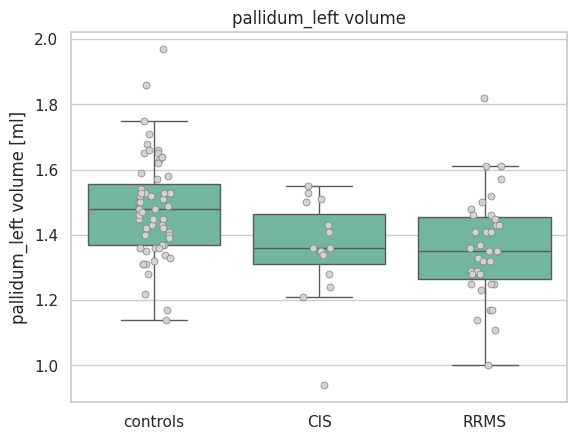

In [46]:
g = sns.boxplot(df, y='pallidum_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pallidum_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pallidum_left volume [ml]")
g.set_xlabel("")
g.set_title("pallidum_left volume")

## thalamus_left volume

Text(0.5, 1.0, 'thalamus_left volume')

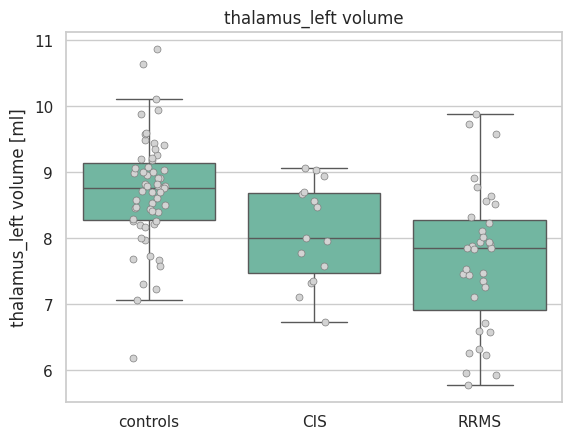

In [47]:
g = sns.boxplot(df, y='thalamus_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thalamus_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thalamus_left volume [ml]")
g.set_xlabel("")
g.set_title("thalamus_left volume")

## frontal_right volume

Text(0.5, 1.0, 'frontal_right volume')

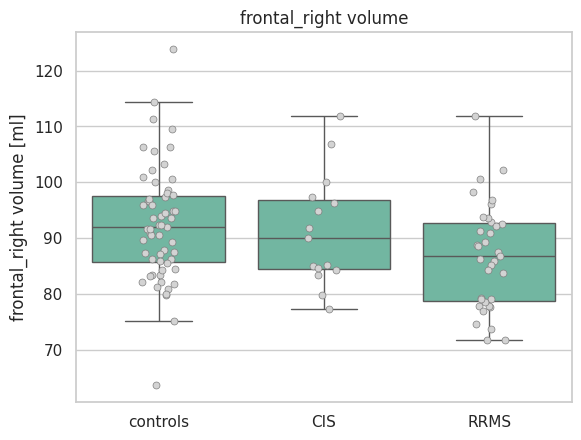

In [48]:
g = sns.boxplot(df, y='frontal_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='frontal_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("frontal_right volume [ml]")
g.set_xlabel("")
g.set_title("frontal_right volume")

## parietal_right volume

Text(0.5, 1.0, 'parietal_right volume')

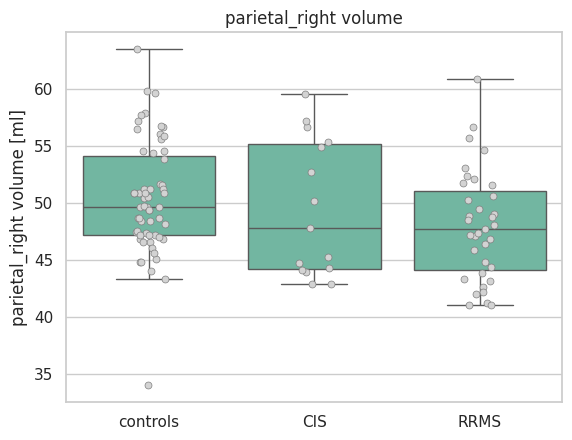

In [49]:
g = sns.boxplot(df, y='parietal_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parietal_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parietal_right volume [ml]")
g.set_xlabel("")
g.set_title("parietal_right volume")

## precuneus_right volume

Text(0.5, 1.0, 'precuneus_right volume')

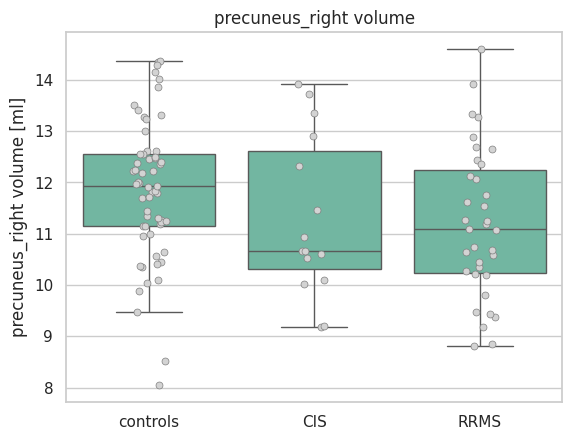

In [50]:
g = sns.boxplot(df, y='precuneus_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='precuneus_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("precuneus_right volume [ml]")
g.set_xlabel("")
g.set_title("precuneus_right volume")

## occipital_right volume

Text(0.5, 1.0, 'occipital_right volume')

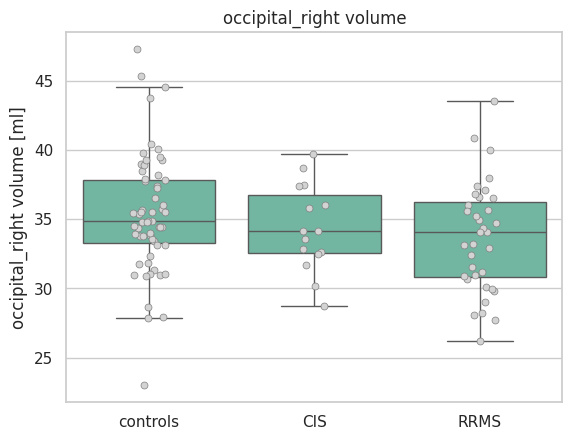

In [51]:
g = sns.boxplot(df, y='occipital_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='occipital_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("occipital_right volume [ml]")
g.set_xlabel("")
g.set_title("occipital_right volume")

## temporal_right volume

Text(0.5, 1.0, 'temporal_right volume')

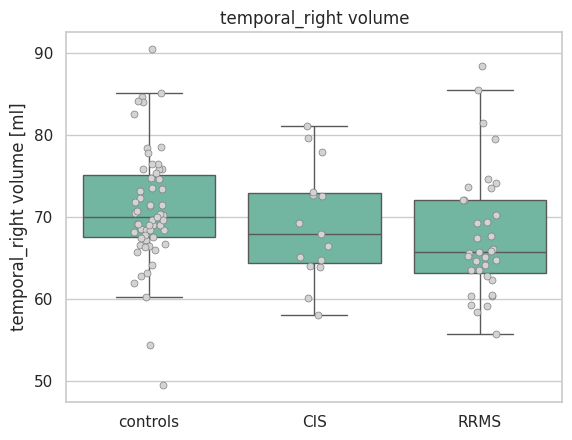

In [52]:
g = sns.boxplot(df, y='temporal_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='temporal_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("temporal_right volume [ml]")
g.set_xlabel("")
g.set_title("temporal_right volume")

## hippocampus_right volume

Text(0.5, 1.0, 'hippocampus_right volume')

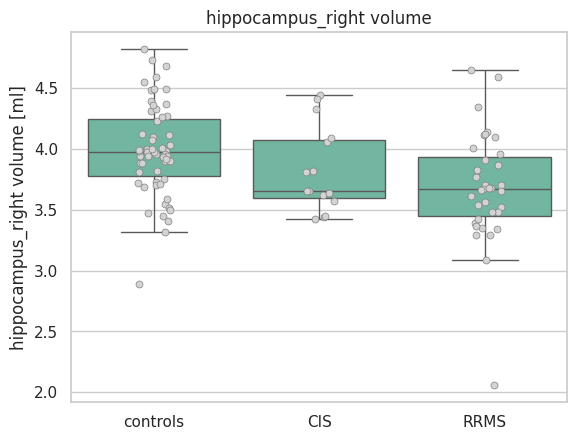

In [53]:
g = sns.boxplot(df, y='hippocampus_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='hippocampus_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("hippocampus_right volume [ml]")
g.set_xlabel("")
g.set_title("hippocampus_right volume")

## entorhinal_right volume

Text(0.5, 1.0, 'entorhinal_right volume')

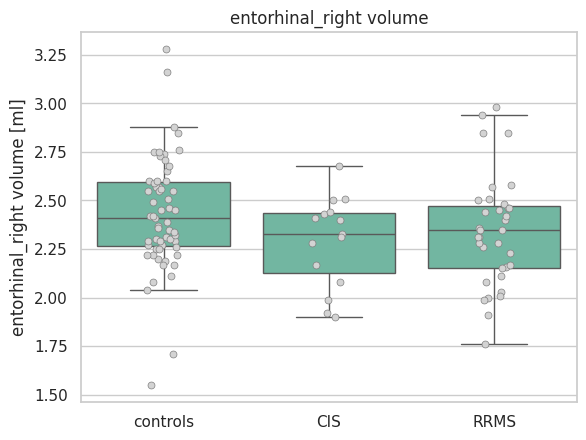

In [54]:
g = sns.boxplot(df, y='entorhinal_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='entorhinal_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("entorhinal_right volume [ml]")
g.set_xlabel("")
g.set_title("entorhinal_right volume")

## caudate_right volume

Text(0.5, 1.0, 'caudate_right volume')

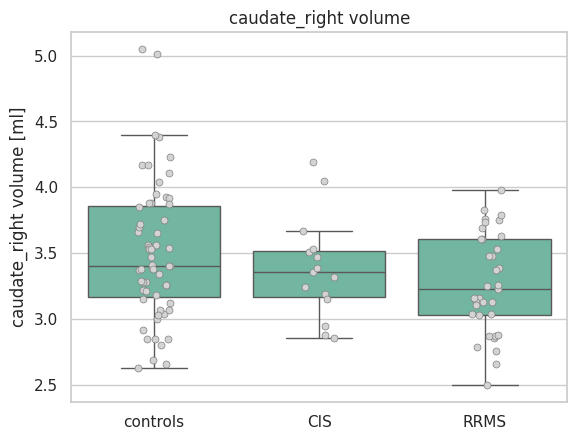

In [55]:
g = sns.boxplot(df, y='caudate_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='caudate_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("caudate_right volume [ml]")
g.set_xlabel("")
g.set_title("caudate_right volume")

## putamen_right volume

Text(0.5, 1.0, 'putamen_right volume')

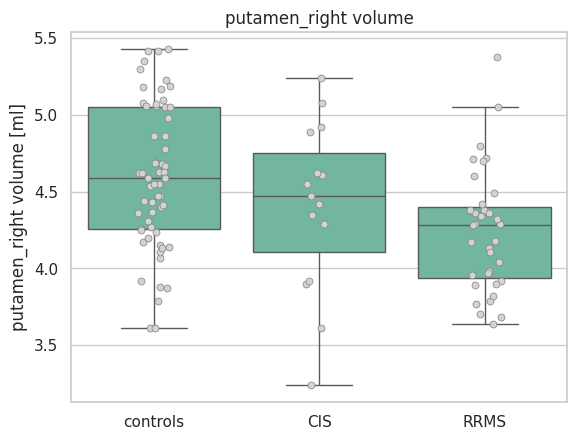

In [56]:
g = sns.boxplot(df, y='putamen_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='putamen_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("putamen_right volume [ml]")
g.set_xlabel("")
g.set_title("putamen_right volume")

## pallidum_right volume

Text(0.5, 1.0, 'pallidum_right volume')

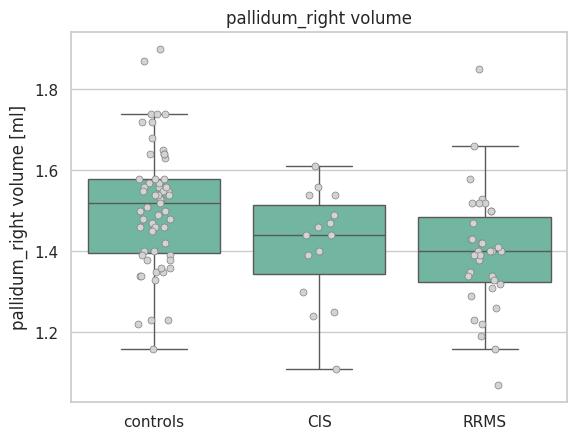

In [57]:
g = sns.boxplot(df, y='pallidum_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pallidum_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pallidum_right volume [ml]")
g.set_xlabel("")
g.set_title("pallidum_right volume")

## thalamus_right volume

Text(0.5, 1.0, 'thalamus_right volume')

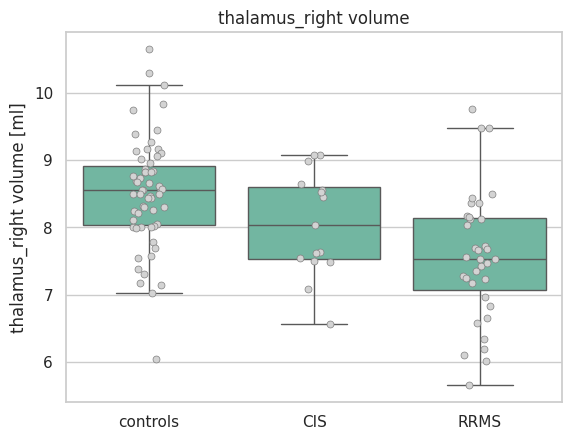

In [58]:
g = sns.boxplot(df, y='thalamus_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thalamus_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thalamus_right volume [ml]")
g.set_xlabel("")
g.set_title("thalamus_right volume")

## brainstem volume

Text(0.5, 1.0, 'brainstem volume')

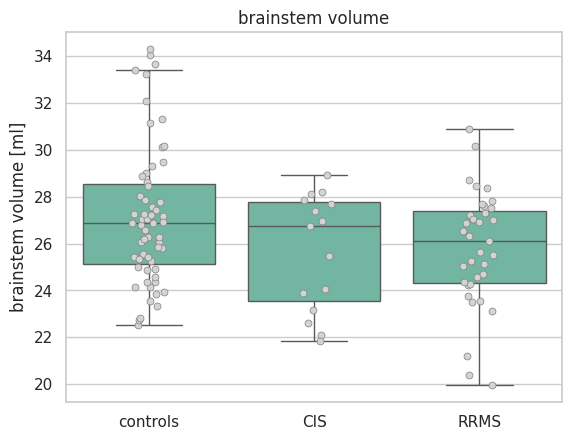

In [59]:
g = sns.boxplot(df, y='brainstem volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='brainstem volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("brainstem volume [ml]")
g.set_xlabel("")
g.set_title("brainstem volume")

## mesencephalon volume

Text(0.5, 1.0, 'mesencephalon volume')

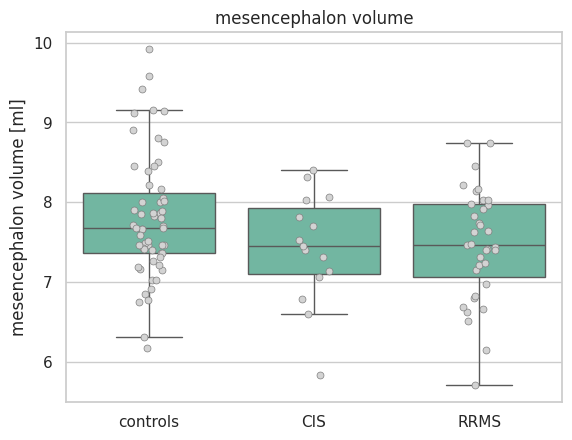

In [60]:
g = sns.boxplot(df, y='mesencephalon volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='mesencephalon volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("mesencephalon volume [ml]")
g.set_xlabel("")
g.set_title("mesencephalon volume")

## pons volume

Text(0.5, 1.0, 'pons volume')

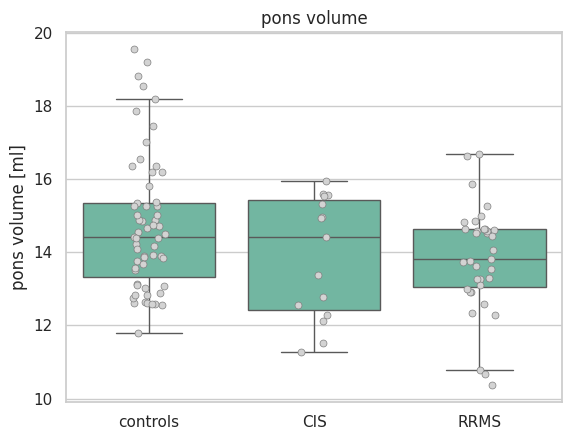

In [61]:
g = sns.boxplot(df, y='pons volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pons volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pons volume [ml]")
g.set_xlabel("")
g.set_title("pons volume")

## cerebellum volume

Text(0.5, 1.0, 'cerebellum volume')

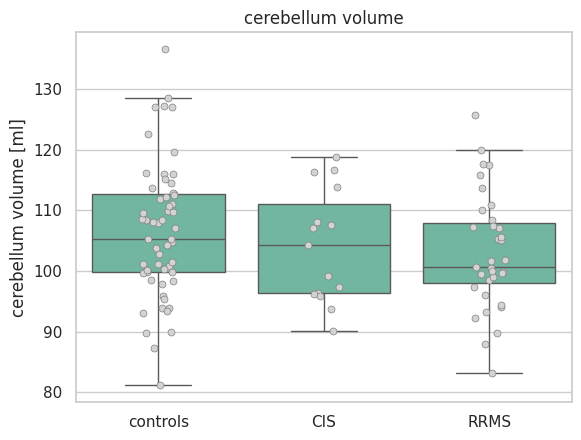

In [62]:
g = sns.boxplot(df, y='cerebellum volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='cerebellum volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("cerebellum volume [ml]")
g.set_xlabel("")
g.set_title("cerebellum volume")

## lateralventricle_right volume

Text(0.5, 1.0, 'lateralventricle_right volume')

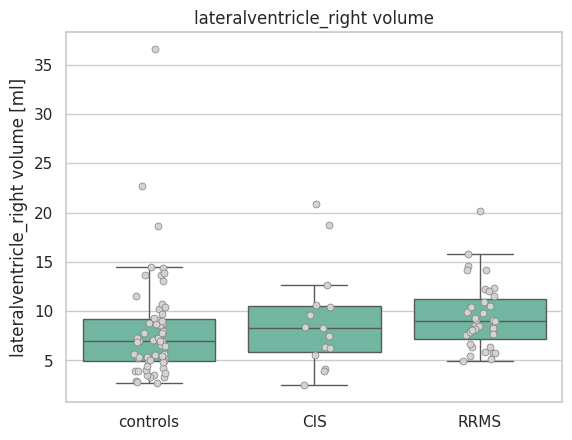

In [63]:
g = sns.boxplot(df, y='lateralventricle_right volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='lateralventricle_right volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("lateralventricle_right volume [ml]")
g.set_xlabel("")
g.set_title("lateralventricle_right volume")

## lateralventricle_left volume

Text(0.5, 1.0, 'lateralventricle_left volume')

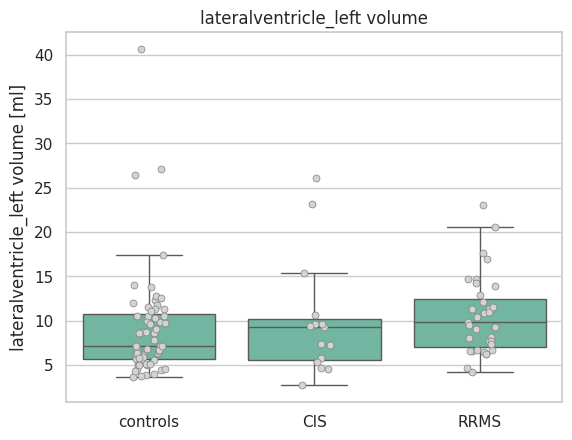

In [64]:
g = sns.boxplot(df, y='lateralventricle_left volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='lateralventricle_left volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("lateralventricle_left volume [ml]")
g.set_xlabel("")
g.set_title("lateralventricle_left volume")

## thirdventricle volume

Text(0.5, 1.0, 'thirdventricle volume')

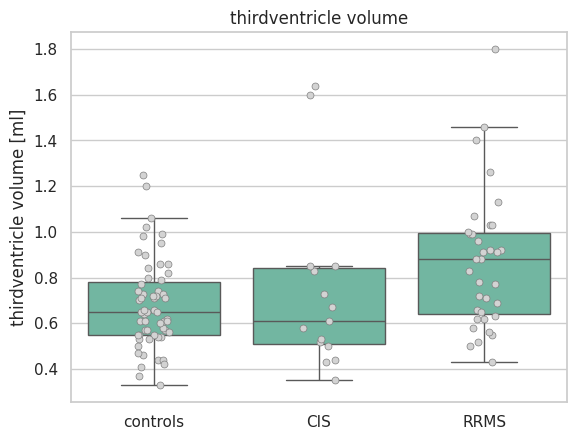

In [65]:
g = sns.boxplot(df, y='thirdventricle volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thirdventricle volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thirdventricle volume [ml]")
g.set_xlabel("")
g.set_title("thirdventricle volume")

## fourthventricle volume

Text(0.5, 1.0, 'fourthventricle volume')

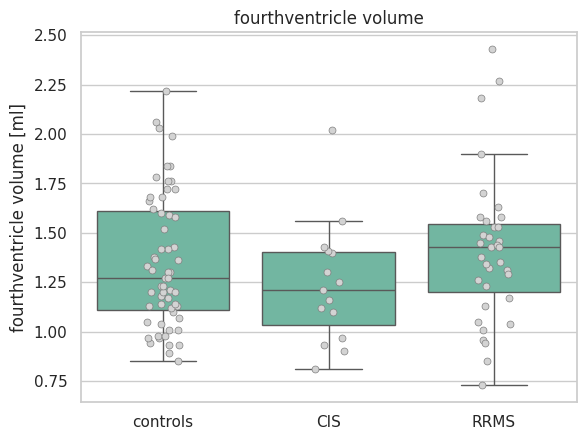

In [66]:
g = sns.boxplot(df, y='fourthventricle volume', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='fourthventricle volume', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("fourthventricle volume [ml]")
g.set_xlabel("")
g.set_title("fourthventricle volume")

## brain segmentation percentile

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.821e-01 U_stat=5.080e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.042e-02 U_stat=3.840e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.411e-06 U_stat=1.606e+03


(<Axes: title={'center': 'brain segmentation percentile'}, ylabel='brain segmentation percentile [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d63f97c0>])

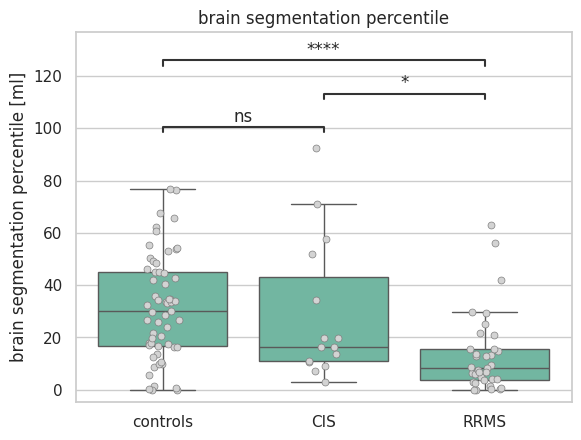

In [67]:
g = sns.boxplot(df, y='brain_segmentation percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='brain_segmentation percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("brain segmentation percentile [ml]")
g.set_xlabel("")
g.set_title("brain segmentation percentile")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='brain_segmentation percentile')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## white_matter_total percentile

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.770e-02 U_stat=5.700e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.533e-01 U_stat=2.910e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.648e-03 U_stat=1.380e+03


(<Axes: title={'center': 'white matter total percentile'}, ylabel='white matter total percentile [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d50fbbf0>])

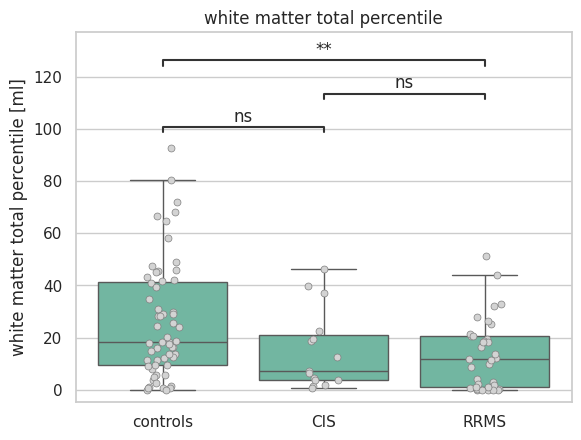

In [68]:
g = sns.boxplot(df, y='white_matter_total percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='white_matter_total percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("white matter total percentile [ml]")
g.set_xlabel("")
g.set_title("white matter total percentile")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='white_matter_total percentile')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## gray_matter_total percentile

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.188e-01 U_stat=4.050e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.987e-02 U_stat=3.730e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.477e-03 U_stat=1.375e+03


(<Axes: title={'center': 'gray matter total percentile'}, ylabel='gray matter total percentile [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d5b000e0>])

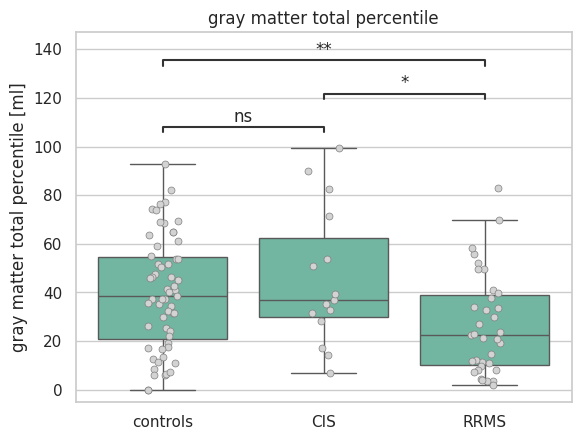

In [69]:
g = sns.boxplot(df, y='gray_matter_total percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='gray_matter_total percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("gray matter total percentile [ml]")
g.set_xlabel("")
g.set_title("gray matter total percentile")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='gray_matter_total percentile')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## cortical_gray_matter_total percentile

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.502e-01 U_stat=5.500e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.966e-01 U_stat=2.880e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.902e-03 U_stat=1.402e+03


(<Axes: title={'center': 'cortical_gray_matter_total percentile'}, ylabel='cortical_gray_matter_total percentile [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d4ecf770>])

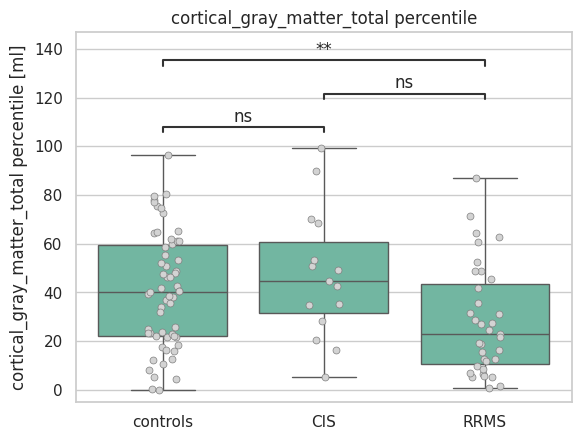

In [70]:
g = sns.boxplot(df, y='cortical_gray_matter_total percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='cortical_gray_matter_total percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("cortical_gray_matter_total percentile [ml]")
g.set_xlabel("")
g.set_title("cortical_gray_matter_total percentile")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='brain_segmentation volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## frontal_left percentile

Text(0.5, 1.0, 'frontal_left percentile')

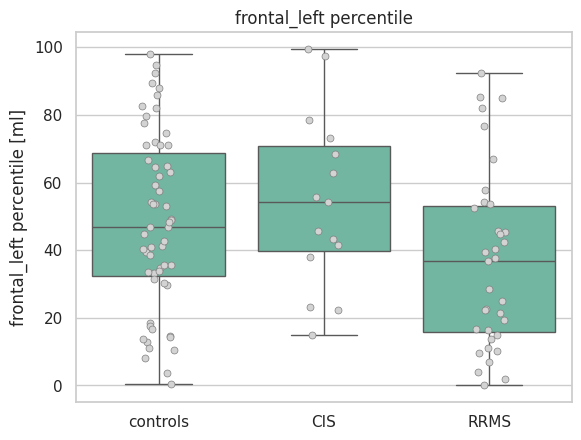

In [71]:
g = sns.boxplot(df, y='frontal_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='frontal_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("frontal_left percentile [ml]")
g.set_xlabel("")
g.set_title("frontal_left percentile")

## parietal_left percentile

Text(0.5, 1.0, 'parietal_left percentile')

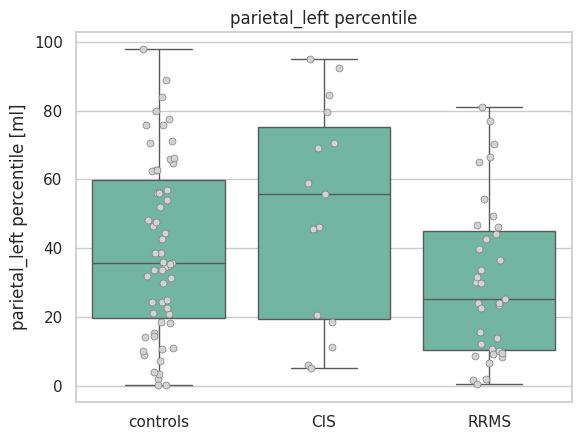

In [72]:
g = sns.boxplot(df, y='parietal_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parietal_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parietal_left percentile [ml]")
g.set_xlabel("")
g.set_title("parietal_left percentile")

## precuneus_left percentile

Text(0.5, 1.0, 'precuneus_left percentile')

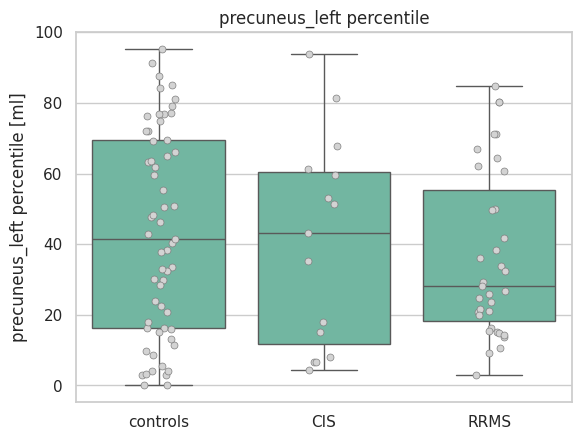

In [73]:
g = sns.boxplot(df, y='precuneus_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='precuneus_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("precuneus_left percentile [ml]")
g.set_xlabel("")
g.set_title("precuneus_left percentile")

## occipital_left percentile

Text(0.5, 1.0, 'occipital_left percentile')

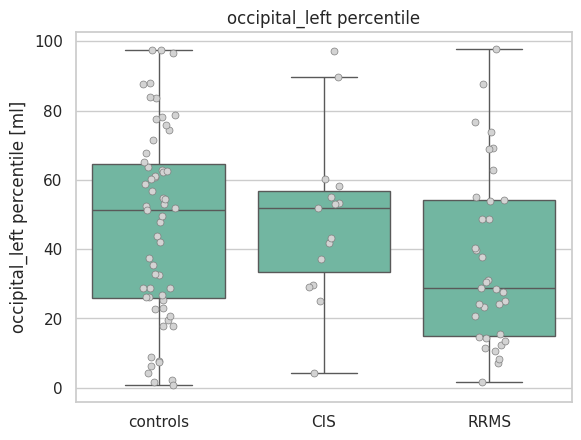

In [74]:
g = sns.boxplot(df, y='occipital_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='occipital_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("occipital_left percentile [ml]")
g.set_xlabel("")
g.set_title("occipital_left percentile")

## temporal_left percentile

Text(0.5, 1.0, 'temporal_left percentile')

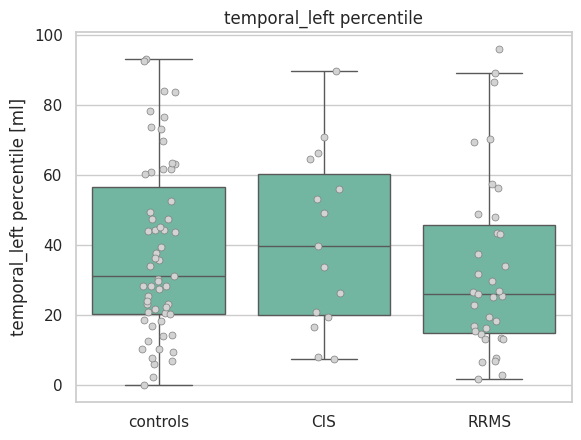

In [75]:
g = sns.boxplot(df, y='temporal_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='temporal_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("temporal_left percentile [ml]")
g.set_xlabel("")
g.set_title("temporal_left percentile")

## hippocampus_left percentile

Text(0.5, 1.0, 'hippocampus_left percentile')

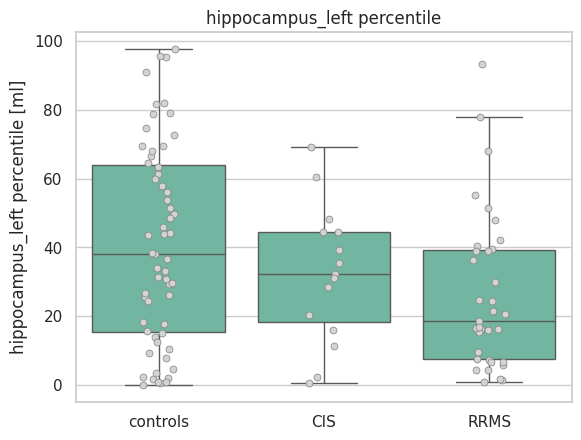

In [76]:
g = sns.boxplot(df, y='hippocampus_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='hippocampus_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("hippocampus_left percentile [ml]")
g.set_xlabel("")
g.set_title("hippocampus_left percentile")

## parahippocampus_gyrus_left percentile

Text(0.5, 1.0, 'parahippocampus_gyrus_left percentile')

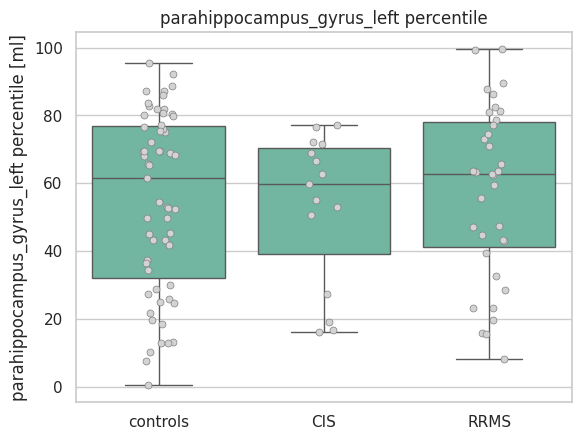

In [77]:
g = sns.boxplot(df, y='parahippocampus_gyrus_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parahippocampus_gyrus_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parahippocampus_gyrus_left percentile [ml]")
g.set_xlabel("")
g.set_title("parahippocampus_gyrus_left percentile")

## entorhinal_left percentile

Text(0.5, 1.0, 'entorhinal_left percentile')

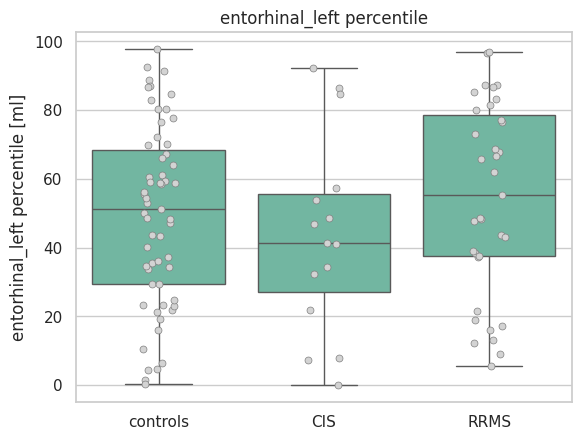

In [78]:
g = sns.boxplot(df, y='entorhinal_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='entorhinal_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("entorhinal_left percentile [ml]")
g.set_xlabel("")
g.set_title("entorhinal_left percentile")

## caudate_left percentile

Text(0.5, 1.0, 'caudate_left percentile')

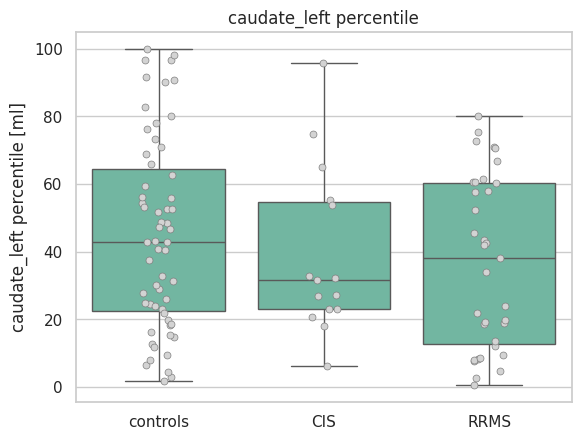

In [79]:
g = sns.boxplot(df, y='caudate_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='caudate_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("caudate_left percentile [ml]")
g.set_xlabel("")
g.set_title("caudate_left percentile")

## putamen_left percentile

Text(0.5, 1.0, 'putamen_left percentile')

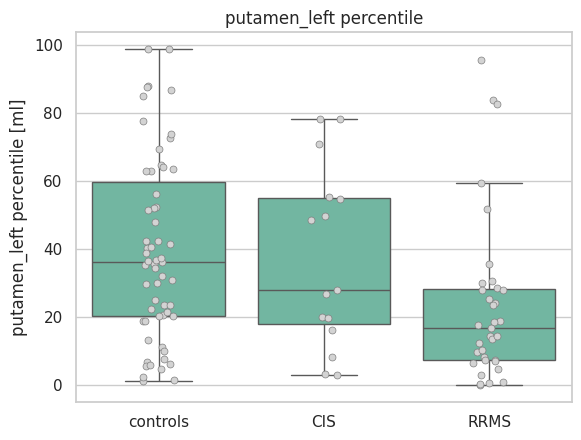

In [80]:
g = sns.boxplot(df, y='putamen_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='putamen_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("putamen_left percentile [ml]")
g.set_xlabel("")
g.set_title("putamen_left percentile")

## pallidum_left percentile

Text(0.5, 1.0, 'pallidum_left percentile')

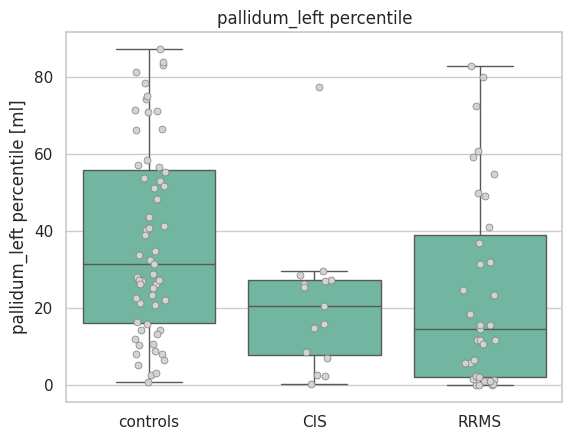

In [81]:
g = sns.boxplot(df, y='pallidum_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pallidum_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pallidum_left percentile [ml]")
g.set_xlabel("")
g.set_title("pallidum_left percentile")

## thalamus_left percentile

Text(0.5, 1.0, 'thalamus_left percentile')

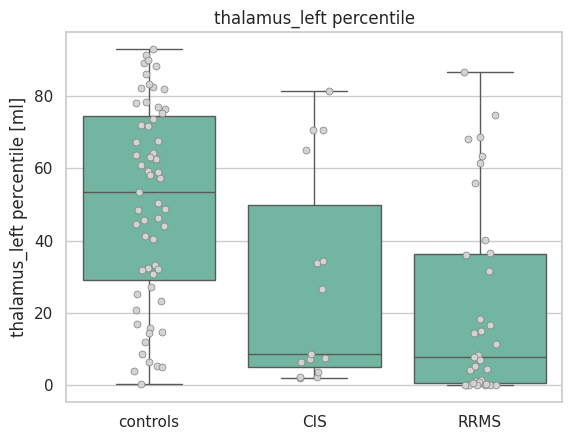

In [82]:
g = sns.boxplot(df, y='thalamus_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thalamus_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thalamus_left percentile [ml]")
g.set_xlabel("")
g.set_title("thalamus_left percentile")

## frontal_right percentile

Text(0.5, 1.0, 'frontal_right percentile')

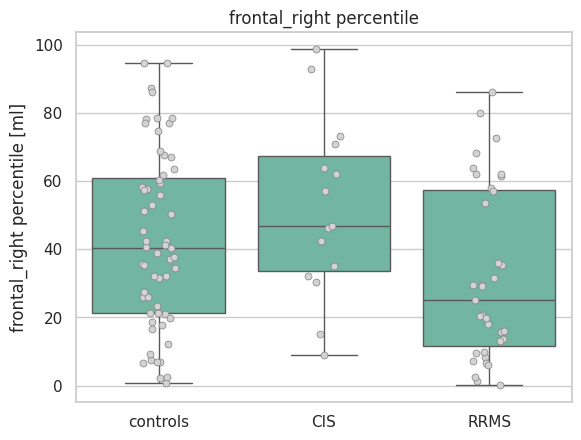

In [83]:
g = sns.boxplot(df, y='frontal_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='frontal_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("frontal_right percentile [ml]")
g.set_xlabel("")
g.set_title("frontal_right percentile")

## parietal_right percentile

Text(0.5, 1.0, 'parietal_right percentile')

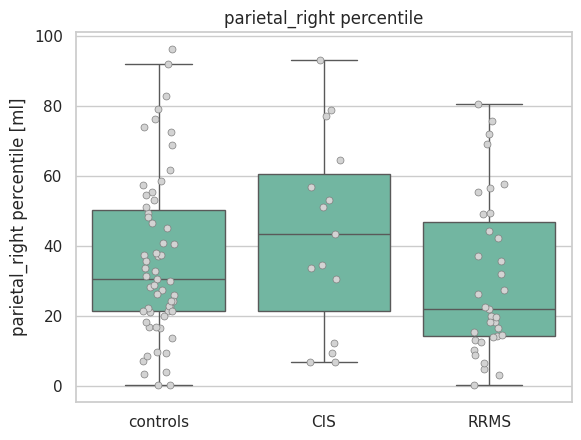

In [84]:
g = sns.boxplot(df, y='parietal_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parietal_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parietal_right percentile [ml]")
g.set_xlabel("")
g.set_title("parietal_right percentile")

## precuneus_right percentile

Text(0.5, 1.0, 'precuneus_right percentile')

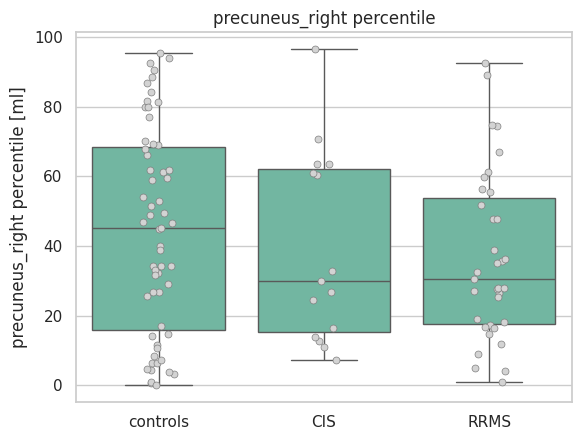

In [85]:
g = sns.boxplot(df, y='precuneus_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='precuneus_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("precuneus_right percentile [ml]")
g.set_xlabel("")
g.set_title("precuneus_right percentile")

## occipital_right percentile

Text(0.5, 1.0, 'occipital_right percentile')

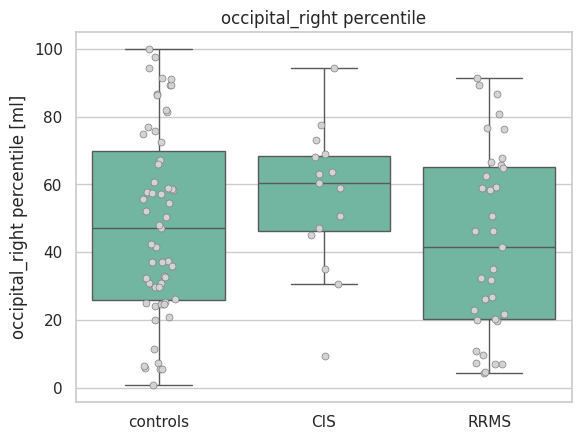

In [86]:
g = sns.boxplot(df, y='occipital_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='occipital_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("occipital_right percentile [ml]")
g.set_xlabel("")
g.set_title("occipital_right percentile")

## temporal_right percentile

Text(0.5, 1.0, 'temporal_right percentile')

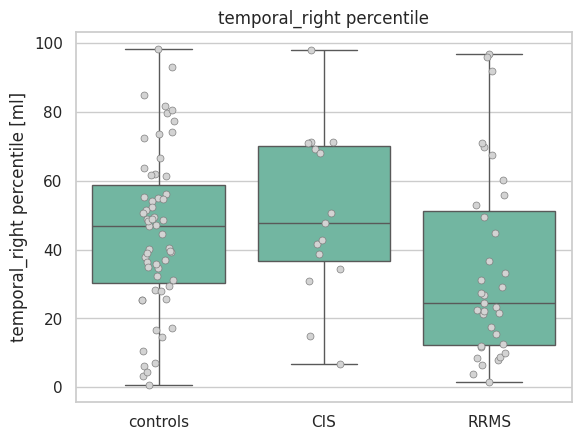

In [87]:
g = sns.boxplot(df, y='temporal_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='temporal_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("temporal_right percentile [ml]")
g.set_xlabel("")
g.set_title("temporal_right percentile")

## hippocampus_right percentile

Text(0.5, 1.0, 'hippocampus_right percentile')

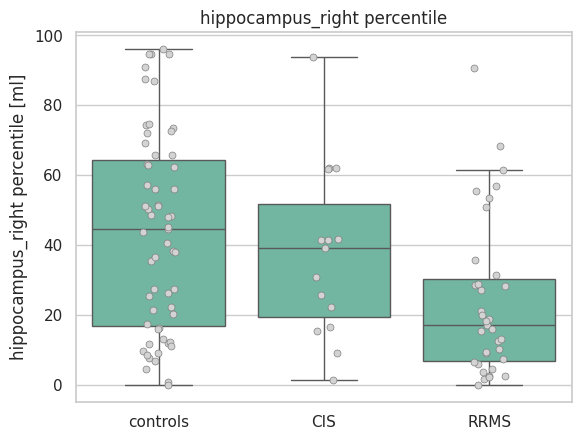

In [88]:
g = sns.boxplot(df, y='hippocampus_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='hippocampus_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("hippocampus_right percentile [ml]")
g.set_xlabel("")
g.set_title("hippocampus_right percentile")

## parahippocampus_gyrus_right percentile

Text(0.5, 1.0, 'parahippocampus_gyrus_right percentile')

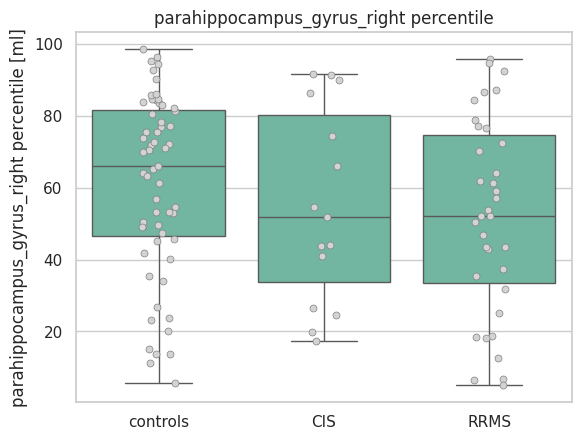

In [89]:
g = sns.boxplot(df, y='parahippocampus_gyrus_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='parahippocampus_gyrus_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("parahippocampus_gyrus_right percentile [ml]")
g.set_xlabel("")
g.set_title("parahippocampus_gyrus_right percentile")

## entorhinal_right percentile

Text(0.5, 1.0, 'entorhinal_right percentile')

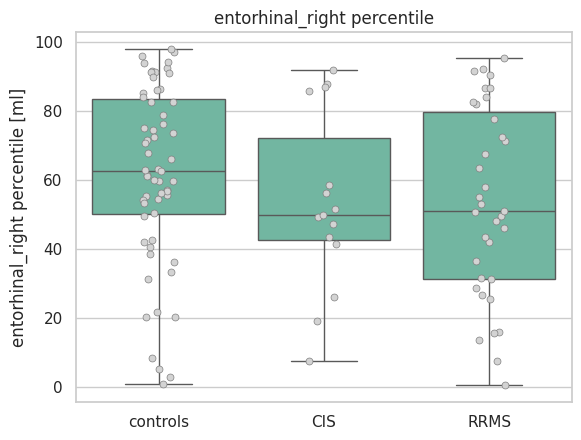

In [90]:
g = sns.boxplot(df, y='entorhinal_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='entorhinal_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("entorhinal_right percentile [ml]")
g.set_xlabel("")
g.set_title("entorhinal_right percentile")

## caudate_right percentile

Text(0.5, 1.0, 'caudate_right percentile')

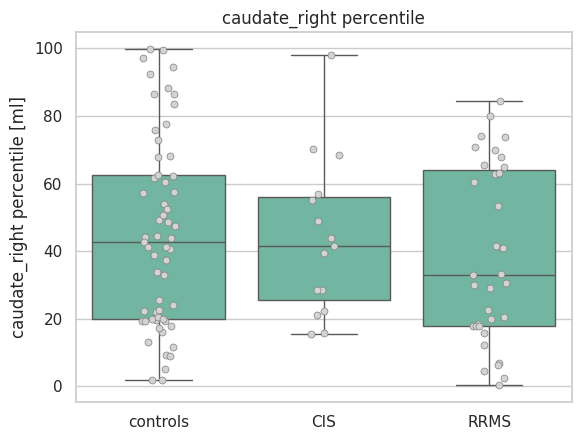

In [91]:
g = sns.boxplot(df, y='caudate_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='caudate_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("caudate_right percentile [ml]")
g.set_xlabel("")
g.set_title("caudate_right percentile")

## putamen_right percentile

Text(0.5, 1.0, 'putamen_right percentile')

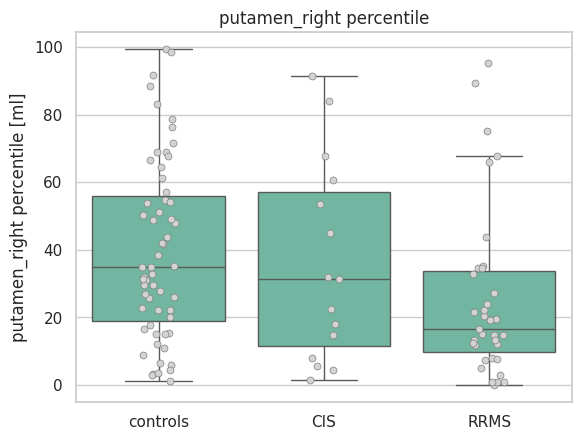

In [92]:
g = sns.boxplot(df, y='putamen_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='putamen_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("putamen_right percentile [ml]")
g.set_xlabel("")
g.set_title("putamen_right percentile")

## pallidum_right percentile

Text(0.5, 1.0, 'pallidum_right percentile')

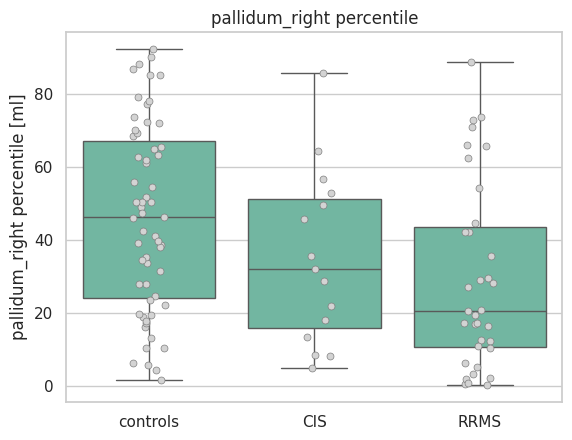

In [93]:
g = sns.boxplot(df, y='pallidum_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pallidum_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pallidum_right percentile [ml]")
g.set_xlabel("")
g.set_title("pallidum_right percentile")

## thalamus_right percentile

Text(0.5, 1.0, 'thalamus_right percentile')

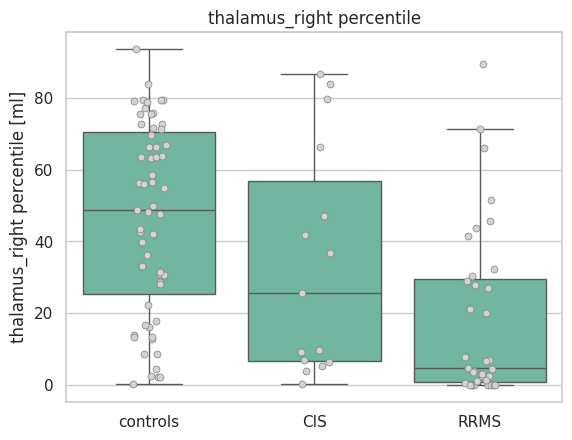

In [94]:
g = sns.boxplot(df, y='thalamus_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thalamus_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thalamus_right percentile [ml]")
g.set_xlabel("")
g.set_title("thalamus_right percentile")

## brainstem percentile

Text(0.5, 1.0, 'brainstem percentile')

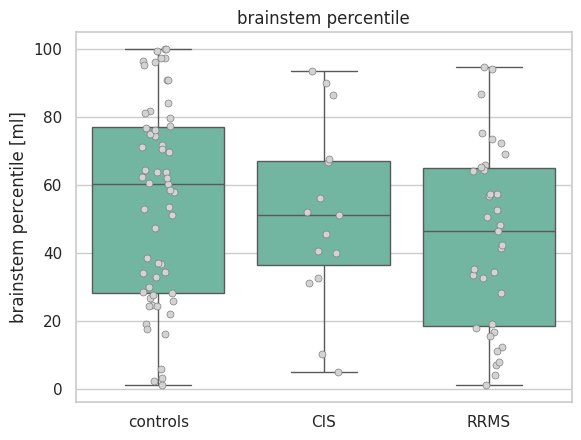

In [95]:
g = sns.boxplot(df, y='brainstem percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='brainstem percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("brainstem percentile [ml]")
g.set_xlabel("")
g.set_title("brainstem percentile")

## mesencephalon percentile

Text(0.5, 1.0, 'mesencephalon percentile')

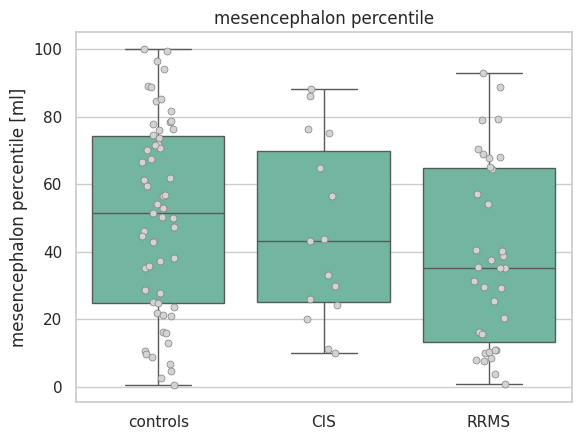

In [96]:
g = sns.boxplot(df, y='mesencephalon percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='mesencephalon percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("mesencephalon percentile [ml]")
g.set_xlabel("")
g.set_title("mesencephalon percentile")

## pons percentile

Text(0.5, 1.0, 'pons percentile')

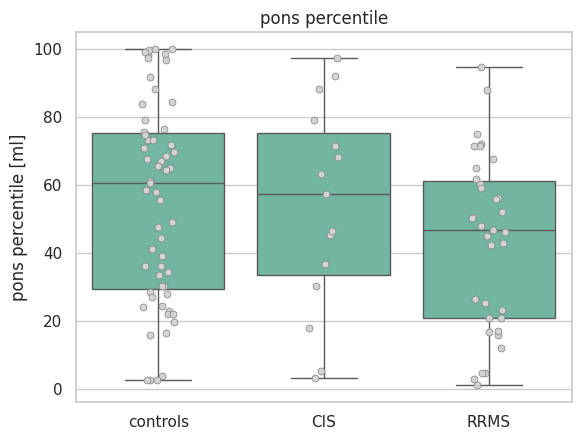

In [97]:
g = sns.boxplot(df, y='pons percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='pons percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("pons percentile [ml]")
g.set_xlabel("")
g.set_title("pons percentile")

## cerebellum percentile

Text(0.5, 1.0, 'cerebellum percentile')

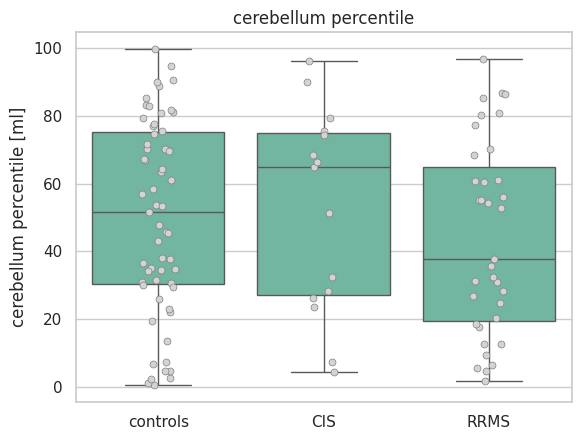

In [98]:
g = sns.boxplot(df, y='cerebellum percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='cerebellum percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("cerebellum percentile [ml]")
g.set_xlabel("")
g.set_title("cerebellum percentile")

## lateralventricle_right percentile

Text(0.5, 1.0, 'lateralventricle_right percentile')

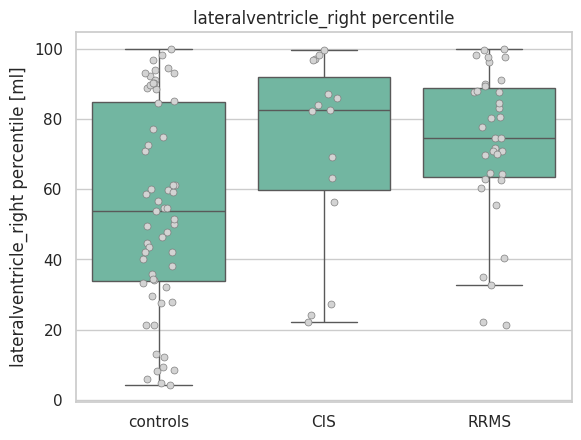

In [99]:
g = sns.boxplot(df, y='lateralventricle_right percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='lateralventricle_right percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("lateralventricle_right percentile [ml]")
g.set_xlabel("")
g.set_title("lateralventricle_right percentile")

## lateralventricle_left percentile

Text(0.5, 1.0, 'lateralventricle_left percentile')

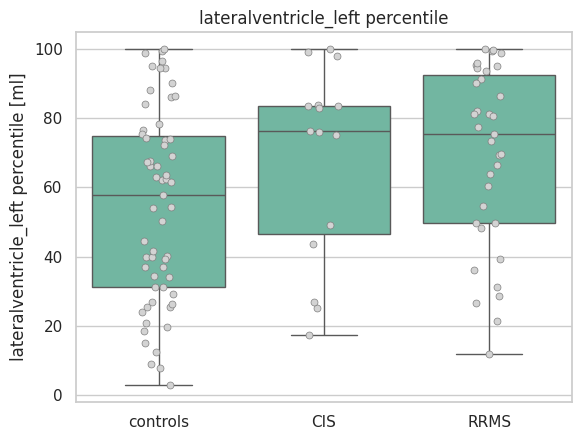

In [100]:
g = sns.boxplot(df, y='lateralventricle_left percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='lateralventricle_left percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("lateralventricle_left percentile [ml]")
g.set_xlabel("")
g.set_title("lateralventricle_left percentile")

## thirdventricle percentile

Text(0.5, 1.0, 'thirdventricle percentile')

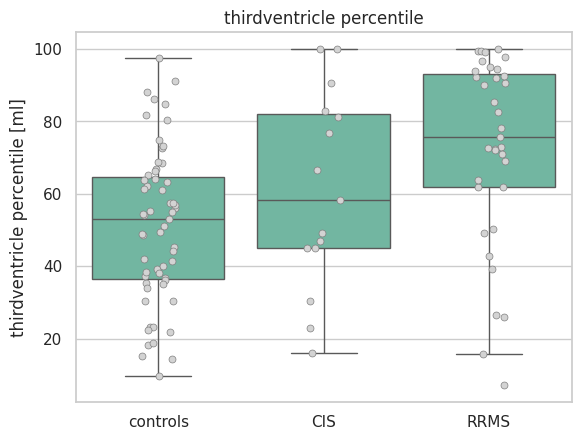

In [101]:
g = sns.boxplot(df, y='thirdventricle percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='thirdventricle percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("thirdventricle percentile [ml]")
g.set_xlabel("")
g.set_title("thirdventricle percentile")

## fourthventricle percentile

Text(0.5, 1.0, 'fourthventricle percentile')

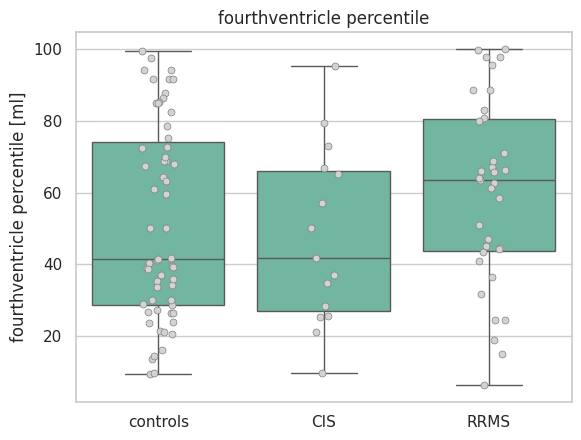

In [102]:
g = sns.boxplot(df, y='fourthventricle percentile', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(df, y='fourthventricle percentile', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("fourthventricle percentile [ml]")
g.set_xlabel("")
g.set_title("fourthventricle percentile")

# BPF

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.088e-01 U_stat=4.240e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.143e-03 U_stat=4.080e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.168e-05 U_stat=1.576e+03


(<Axes: title={'center': 'brain-parenchym-fraction'}, ylabel='bpf [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d4274860>])

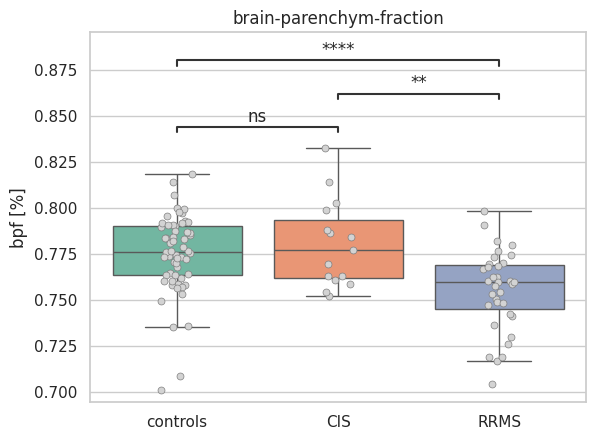

In [103]:
g = sns.boxplot(df, y='bpf', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='bpf', x='group', linewidth=0.5, color='lightgrey' ) # Alle als Einzelpunkte 
g.set_ylabel("bpf [%]")
g.set_xlabel("")
g.set_title("brain-parenchym-fraction")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='bpf')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [104]:
df.query("`bpf` < 0.72 and group=='controls'")
# abfrage Suche nach Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
11          11  24.0      0  00-024 2022-01-11 2022-01-11   38   m   
26          26  50.0      0  00-050 2022-03-03 2022-03-10   45   f   

   Bemerkungen    Education  ...  lateralventricle_left percentile  \
11         NaN  Realschule   ...                             96.57   
26         NaN       Abitur  ...                             90.11   

   thirdventricle percentile fourthventricle percentile total_lesion_volume  \
11                     86.23                      86.31                1.63   
26                     91.16                      35.86                1.89   

   total_lesion_count cognitve SDMT  DoD  SDMT, mit CI/CP  \
11                 36            CP  NaN               CP   
26                 27            CP  NaN               CP   

    CVLT_Total, mit CI/CP  BVMT-R_Total, mit CI/CP  
11                     CI                       CI  
26                     CP                       CI  

[2 rows x 157 columns]

# Psychologie

## SDMT vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.942e-01 U_stat=4.010e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.337e-03 U_stat=3.895e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.337e-04 U_stat=1.420e+03


(<Axes: title={'center': 'SDMT'}, ylabel='SDMT [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d410c500>])

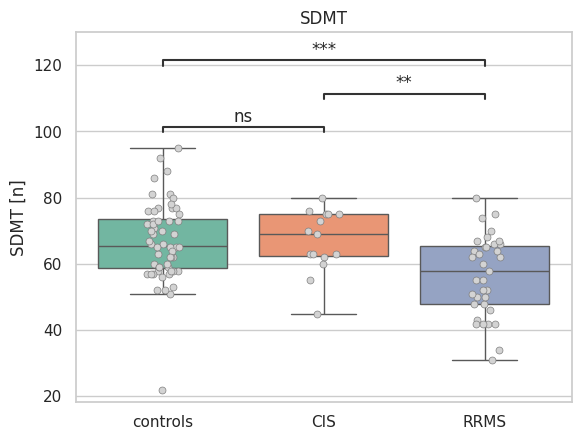

In [105]:
g = sns.boxplot(df, y='SDMT', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='SDMT', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("SDMT [n]")
g.set_xlabel("")
g.set_title("SDMT")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='SDMT')
annotator.configure(test='Mann-Whitney').apply_and_annotate()


## SDMT vs. bpf

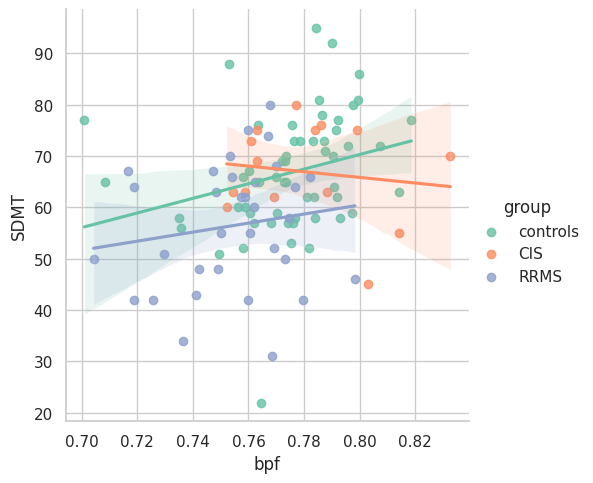

In [106]:
g = sns.lmplot(data=cc_df, y='SDMT', x='bpf', hue='group')

## Korrelation SDMT vs. bpf

In [107]:
from scipy.stats import spearmanr
# df['bpf']=cc_df
# korrelation, p_wert = spearmanr(cc_df['bpf'], cc_df['SDMT'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['bpf'], cc_df.query('group=="RRMS"')['SDMT'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['bpf'], cc_df.query('group=="CIS"')['SDMT'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['bpf'], cc_df.query('group=="controls"')['SDMT'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.019808170651596263 , p-Wert: 0.4346705209707431
CIS- r²: 0.00011645962732919258 , p-Wert: 0.969551698140068
controls- r²: 0.15513858861038027 , p-Wert: 0.002669317814437943


In [108]:
df.query("`SDMT` < 25")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID Test Date   MRT Date  Age Sex  \
5           5  17.0      0  00-017       NaT 2020-03-13   57   m   

                  Bemerkungen Education  ...  \
5  nicht in Tabelle enthalten       NaN  ...   

   lateralventricle_left percentile thirdventricle percentile  \
5                             62.28                     39.27   

  fourthventricle percentile total_lesion_volume total_lesion_count  \
5                       87.6                0.55                 15   

  cognitve SDMT  DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
5            CI  NaN               CI                     CP   

   BVMT-R_Total, mit CI/CP  
5                       CI  

[1 rows x 157 columns]

In [109]:
df.query("group=='controls'").SDMT.mean() # Mittelwertberechnung

np.float64(66.76785714285714)

In [110]:
df.query("group=='CIS'").SDMT.mean()

np.float64(66.93333333333334)

In [111]:
df.query("group=='RRMS'").SDMT.mean()

np.float64(56.542857142857144)

## nicht relevant - anova SDMT

In [112]:
# ANOVA - Vergleich Mittelwert-Unterschiede der Gruppen

# ax = sns.boxplot(df, x='group', y = 'SDMT')

In [113]:
# fvalue, pvalue = stats.f_oneway(df.query('group=="controls"').SDMT.dropna(), 
                                # df.query('group=="CIS"').SDMT.dropna(), 
                                # df.query('group=="RRMS"').SDMT.dropna())
# print(fvalue, pvalue)
# model = ols('SDMT ~ C(group)', df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table

In [114]:
df.query('group=="controls"').SDMT.to_list()

[58.0,
 57.0,
 53.0,
 58.0,
 62.0,
 22.0,
 60.0,
 51.0,
 nan,
 92.0,
 66.0,
 65.0,
 59.0,
 57.0,
 65.0,
 77.0,
 nan,
 62.0,
 66.0,
 59.0,
 57.0,
 70.0,
 57.0,
 58.0,
 71.0,
 88.0,
 77.0,
 76.0,
 69.0,
 73.0,
 81.0,
 76.0,
 nan,
 86.0,
 77.0,
 63.0,
 69.0,
 72.0,
 72.0,
 64.0,
 81.0,
 75.0,
 80.0,
 95.0,
 70.0,
 62.0,
 52.0,
 67.0,
 73.0,
 78.0,
 58.0,
 60.0,
 56.0,
 59.0,
 65.0,
 52.0,
 65.0,
 73.0,
 73.0]

In [115]:
f_statistic, p_value = f_oneway(df.query('group=="controls"').SDMT.dropna(), 
                                df.query('group=="CIS"').SDMT.dropna(), 
                                df.query('group=="RRMS"').SDMT.dropna(), 
                                df.query('group=="SPMS"').SDMT.dropna())
print("F_Statistic:", f_statistic)
print("P-Value:", p_value)

F_Statistic: nan
P-Value: nan


/tmp/nix-shell-7033-0/ipykernel_38878/4194636000.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_statistic, p_value = f_oneway(df.query('group=="controls"').SDMT.dropna(),


In [116]:
fvalue, pvalue = stats.f_oneway(df.query('group=="controls" and EDSS <= 0.5').SDMT.dropna(), 
                                df.query('group=="CIS"').SDMT.dropna(), 
                                df.query('group=="RRMS"').SDMT.dropna(), 
                                df.query('group=="SPMS"').SDMT.dropna())
print(fvalue, pvalue)
model = ols('SDMT ~ C(group)', df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

nan nan


/tmp/nix-shell-7033-0/ipykernel_38878/2071322113.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  fvalue, pvalue = stats.f_oneway(df.query('group=="controls" and EDSS <= 0.5').SDMT.dropna(),


sum_sq     df         F    PR(>F)
C(group)   2468.134659    2.0  9.106789  0.000228
Residual  13957.601190  103.0       NaN       NaN

g = sns.boxplot(df, y='SDMT', x='group')
g.set_ylabel("SDMT in Pkte.")
g.set_xlabel("")
g.set_title("SDMT")

## nicht relevant - CVLT 1

g = sns.boxplot(df, y='CVLT_1', x='group')
g.set_ylabel("CVLT, Part 1 in Pkte.")
g.set_xlabel("")
g.set_title("CVLT_1")

In [117]:
# g = sns.boxplot(df, y='CVLT_1', x='group', fliersize=0) # Boxplot ohne Ausreißer
# sns.stripplot(df, y='CVLT_1', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_ylabel("CVLT, part 1 [count]")
# g.set_xlabel("")
# g.set_title("CVLT, part 1")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_1')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [118]:
# df.query("`CVLT_1` < 5.5")
# abfrage Suche Ausreisser-Daten

## nicht relevant - CVLT 2

In [119]:
# g = sns.boxplot(df, y='CVLT_2', x='group', fliersize=0) # Boxplot ohne Ausreißer
# sns.stripplot(df, y='CVLT_2', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_ylabel("CVLT, part 2 [count]")
# g.set_xlabel("")
# g.set_title("CVLT, part 2")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_2')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [120]:
# df.query("`CVLT_2` < 6.5")
# abfrage Suche Ausreisser-Daten

## nicht relevant - CVLT 3

In [121]:
# g = sns.boxplot(df, y='CVLT_3', x='group', fliersize=0) # Boxplot ohne Ausreißer
# sns.stripplot(df, y='CVLT_3', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_ylabel("CVLT, part 3 [count]")
# g.set_xlabel("")
# g.set_title("CVLT, part3")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_3')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [122]:
# df.query("`CVLT_3` < 9")
# abfrage Suche Ausreisser-Daten

## nicht relevant - CVLT 4


In [123]:
# g = sns.boxplot(df, y='CVLT_4', x='group', fliersize=0) # Boxplot ohne Ausreißer
# sns.stripplot(df, y='CVLT_4', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_ylabel("CVLT, part 4 [count]")
# g.set_xlabel("")
# g.set_title("CVLT, part 4")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_4')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [124]:
# df.query("`CVLT_4` < 5.5")
# abfrage Suche Ausreisser-Daten

In [125]:
# df.query("`CVLT_4` > 150")

## nicht relevant - CVLT 5

In [126]:
# g = sns.boxplot(df, y='CVLT_5', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
# sns.stripplot(df, y='CVLT_5', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
# g.set_ylabel("CVLT, part 5 [count]")
# g.set_xlabel("")
# g.set_title("CVLT, part 5")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_5')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [127]:
# df.query("`CVLT_5` < 10")
# abfrage Suche Ausreisser-Daten

## CVLT total vs. Gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.136e-02 U_stat=5.440e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.841e-01 U_stat=2.290e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.426e-01 U_stat=1.124e+03


(<Axes: title={'center': 'CVLT, total'}, ylabel='CVLT, total [count]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d41bf2c0>])

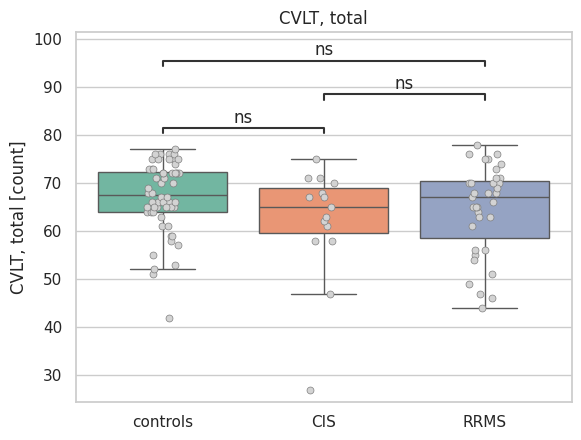

In [128]:
g = sns.boxplot(df, y='CVLT_Total', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='CVLT_Total', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("CVLT, total [count]")
g.set_xlabel("")
g.set_title("CVLT, total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='CVLT_Total')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

In [129]:
df.query("`CVLT_Total` < 20")
# abfrage Suche Ausreisser-Daten

Empty DataFrame
Columns: [Unnamed: 0, Nr., Group, ID, Test Date, MRT Date, Age, Sex, Bemerkungen, Education, Yrs education, Employment, Medication_other, Smoking, Smoking_nr, Alcohol, BVMT-R_Total, SDMT, CVLT_1, CVLT_2, CVLT_3, CVLT_4, CVLT_5, CVLT_Total, EDSS, 25FW_1 (sec), 25FW_2 (sec), 2min_walk (m), FAP_nomal, FAP_dual, Contrast Sensitivity, 9HPT, pRNFL_L_total, pRNFL_L_inferior, pRNFL_L_temporal, pRNFL_L_superior, pRNFL_L_nasal, pRNFL_R_total, pRNFL_R_inferior, pRNFL_R_temporal, pRNFL_R_superior, pRNFL_R_nasal, Macular_Volume_L, Macular_Volume_R, Macular_Thickness_L, Macular_Thickness_R, Bemerkungen.1, ID.1, MRT Date.1, L_transaction_id, StudyDate, V_transaction_id, StudyDate.1, bpf, Manifestation_MS, Diagnosis_MS, Duration_MS_yrs, Medication_MS, Medication_name, Contrast Sensitivity (Ergebnis bei 2,5%), 9HPT (sek.), session, group, control, transaction_id, StudyDate_lesion, StudyTime, deepwm volume, infratentorial volume, juxtacortical volume, paraventricular volume, deepwm n_lesions, infratentorial n_lesions, juxtacortical n_lesions, paraventricular n_lesions, transaction_id_volumetry, StudyDate_volumetry, StudyTime_volumetry, brain_segmentation volume, white_matter_total volume, gray_matter_total volume, cortical_gray_matter_total volume, frontal_left volume, parietal_left volume, precuneus_left volume, occipital_left volume, temporal_left volume, hippocampus_left volume, parahippocampus_gyrus_left volume, entorhinal_left volume, caudate_left volume, putamen_left volume, pallidum_left volume, thalamus_left volume, frontal_right volume, parietal_right volume, precuneus_right volume, occipital_right volume, temporal_right volume, hippocampus_right volume, ...]
Index: []

[0 rows x 157 columns]

### CVLT vs. bpf

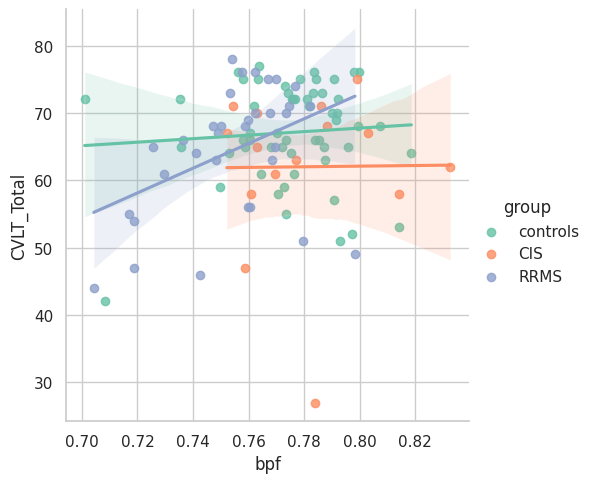

In [130]:
g = sns.lmplot(data=cc_df, y='CVLT_Total', x='bpf', hue='group')

### Korrelation CVLT, total vs. bpf

In [131]:
from scipy.stats import spearmanr
# df['bpf']=cc_df
# korrelation, p_wert = spearmanr(cc_df['bpf'], cc_df['SDMT'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['bpf'], cc_df.query('group=="RRMS"')['CVLT_Total'], nan_policy='omit')
print("RRMS-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['bpf'], cc_df.query('group=="CIS"')['CVLT_Total'], nan_policy='omit')
print("CIS-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['bpf'], cc_df.query('group=="controls"')['CVLT_Total'], nan_policy='omit')
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

RRMS- r²: 0.1722 p-Wert: 0.0163
CIS- r²: 0.0001 p-Wert: 0.9697
controls- r²: 0.0003 p-Wert: 0.9058


## BVMT-R, total vs. Gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:9.660e-01 U_stat=4.165e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.036e-01 U_stat=3.395e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=1.267e+03


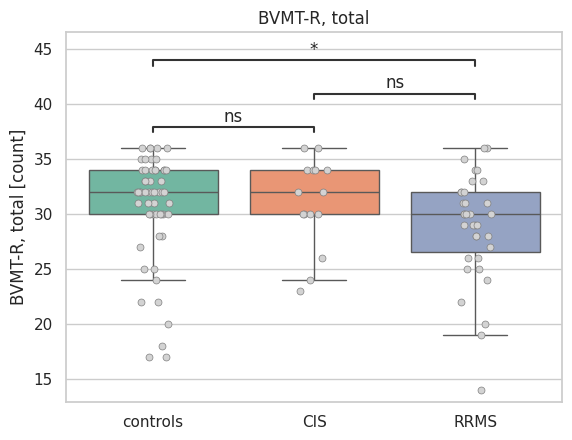

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [132]:
g = sns.boxplot(df, y='BVMT-R_Total', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='BVMT-R_Total', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("BVMT-R, total [count]")
g.set_xlabel("")
g.set_title("BVMT-R, total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='BVMT-R_Total')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

plt.show()

sns.color_palette()


In [133]:
df.query("`BVMT-R_Total` < 19")
# abfrage Suche Ausreisser-Daten

Unnamed: 0   Nr.  Group      ID  Test Date   MRT Date  Age Sex  \
5             5  17.0      0  00-017        NaT 2020-03-13   57   m   
11           11  24.0      0  00-024 2022-01-11 2022-01-11   38   m   
19           19  38.0      0  00-038 2022-02-22 2022-03-01   25   f   
101         101  45.0      2  02-037 2021-06-21 2021-06-28   41   m   

                                       Bemerkungen    Education  ...  \
5                       nicht in Tabelle enthalten          NaN  ...   
11                                             NaN  Realschule   ...   
19                                             NaN       Abitur  ...   
101  (1) - Dicom-pdf; (2) - Analysefehler Läsionen          NaN  ...   

     lateralventricle_left percentile thirdventricle percentile  \
5                               62.28                     39.27   
11                              96.57                     86.23   
19                              50.19                     22.29   
101                             69.61                     85.46   

    fourthventricle percentile total_lesion_volume total_lesion_count  \
5                        87.60                0.55                 15   
11                       86.31                1.63                 36   
19                       13.63                0.21                  6   
101                      63.54               15.60                173   

    cognitve SDMT   DoD  SDMT, mit CI/CP  CVLT_Total, mit CI/CP  \
5              CI   NaN               CI                     CP   
11             CP   NaN               CP                     CI   
19             CP   NaN               CP                     CP   
101            CI  13.0               CI                     CP   

     BVMT-R_Total, mit CI/CP  
5                         CI  
11                        CI  
19                        CI  
101                       CI  

[4 rows x 157 columns]

### BVMT-R vs. bpf

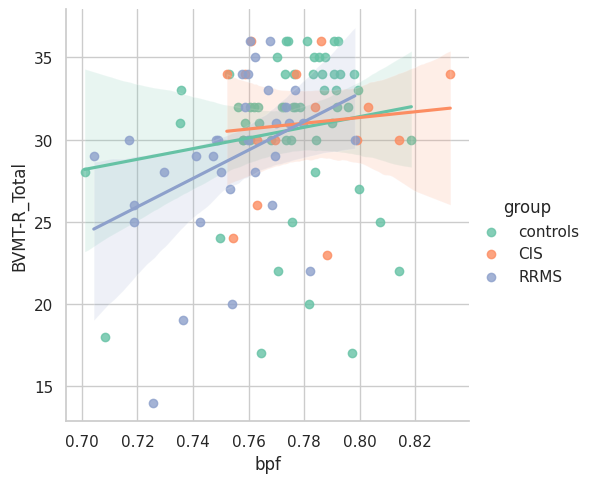

In [134]:
g = sns.lmplot(data=cc_df, y='BVMT-R_Total', x='bpf', hue='group')

### Korrelation BVMT-R, total vs. bpf

In [135]:
from scipy.stats import spearmanr
# df['bpf']=cc_df
# korrelation, p_wert = spearmanr(cc_df['bpf'], cc_df['SDMT'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['bpf'], cc_df.query('group=="RRMS"')['BVMT-R_Total'], nan_policy='omit')
print("RRMS-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['bpf'], cc_df.query('group=="CIS"')['BVMT-R_Total'], nan_policy='omit')
print("CIS-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['bpf'], cc_df.query('group=="controls"')['BVMT-R_Total'], nan_policy='omit')
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}")

RRMS- r²: 0.2024 p-Wert: 0.0086
CIS- r²: 0.0041 p-Wert: 0.8214
controls- r²: 0.0301 p-Wert: 0.2012


## noch offen - Läsionsvolumen (über alles) vs. NP

### LV total vs. CLVT total

### LV total vs. SDMT

### LV total vs. BVMT-R

# Motorische Tests

## EDSS

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.180e-06 U_stat=8.850e+01
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:9.567e-01 U_stat=2.655e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.311e-09 U_stat=2.385e+02


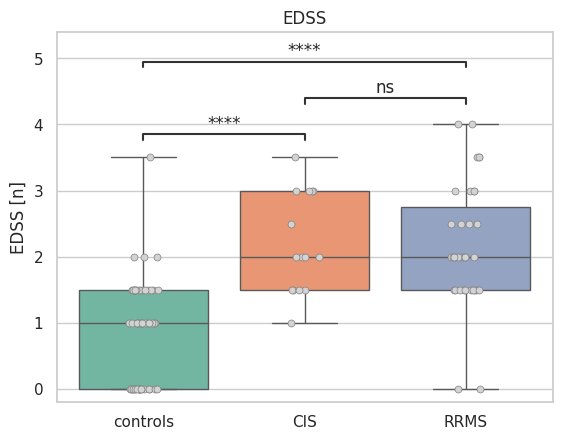

In [136]:
g = sns.boxplot(df, y='EDSS', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(df, y='EDSS', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_ylabel("EDSS [n]")
g.set_xlabel("")
g.set_title("EDSS")


# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='EDSS')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

plt.show()

# MRT gesamt vs. gruppen

## Lesionsvolumen total vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.440e-06 U_stat=9.150e+01
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.100e-01 U_stat=1.865e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.224e-12 U_stat=1.345e+02


(<Axes: title={'center': 'Lesionvolume, total'}, ylabel='total lesionvolume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1e7d5b0>])

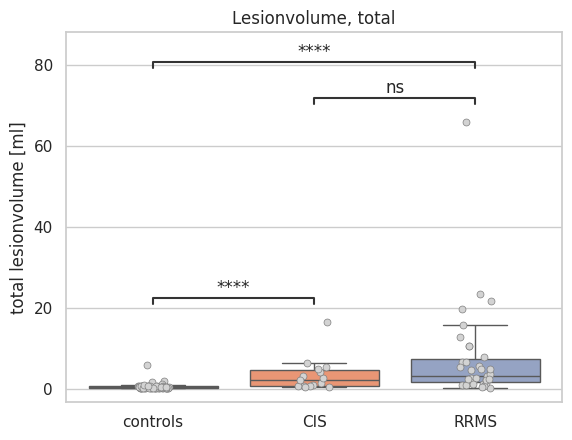

In [137]:
g = sns.boxplot(data=df, x='group', y='total_lesion_volume', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='total_lesion_volume', linewidth=0.5, color='lightgrey')
g.set_ylabel("total lesionvolume [ml]")
g.set_xlabel("")
g.set_title("Lesionvolume, total")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='total_lesion_volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Lesioncount total vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:9.070e-06 U_stat=1.135e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.532e-02 U_stat=1.675e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.289e-12 U_stat=1.435e+02


(<Axes: title={'center': 'Lesioncount, total'}, ylabel='total lesioncount [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1f4d7c0>])

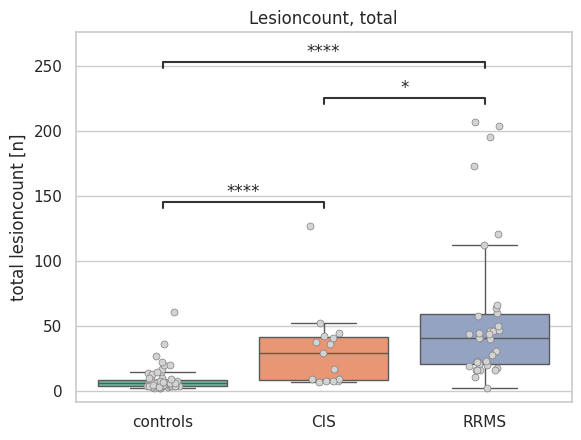

In [138]:
g = sns.boxplot(data=df, x='group', y='total_lesion_count', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='total_lesion_count', linewidth=0.5, color='lightgrey')
g.set_ylabel("total lesioncount [n]")
g.set_xlabel("")
g.set_title("Lesioncount, total")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='total_lesion_count')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Lesionvolume, wm vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.652e-02 U_stat=6.080e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.032e-01 U_stat=2.440e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.892e-03 U_stat=1.368e+03


(<Axes: title={'center': 'Volume, wm, total'}, ylabel='wm-volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1fe7bf0>])

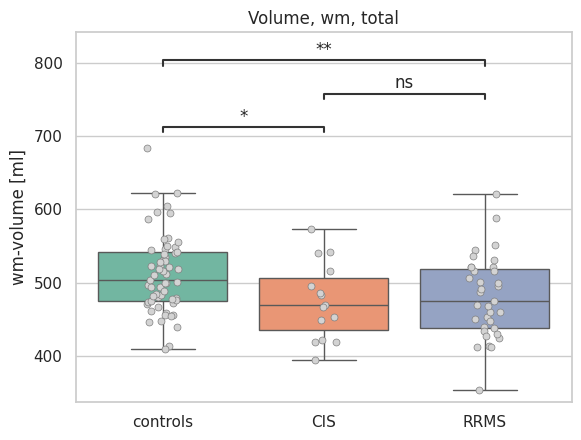

In [139]:
g = sns.boxplot(data=df, x='group', y='white_matter_total volume', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='white_matter_total volume', linewidth=0.5, color='lightgrey')
g.set_ylabel("wm-volume [ml]")
g.set_xlabel("")
g.set_title("Volume, wm, total")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='white_matter_total volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## volume, gm vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.677e-01 U_stat=5.100e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.516e-01 U_stat=3.070e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.495e-03 U_stat=1.388e+03


(<Axes: title={'center': 'Volume, gm, total'}, ylabel='gm-volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1e0ecc0>])

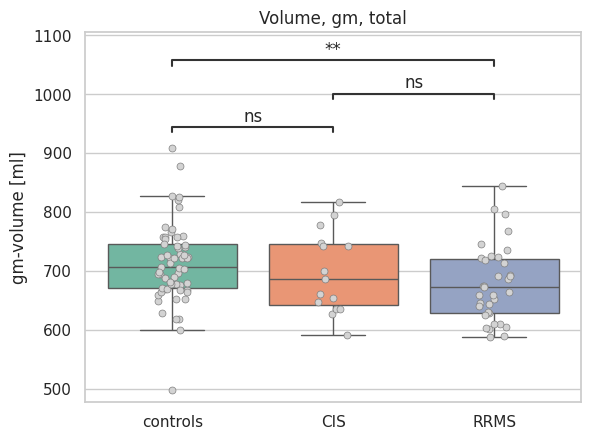

In [140]:
g = sns.boxplot(data=df, x='group', y='gray_matter_total volume', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='gray_matter_total volume', linewidth=0.5, color='lightgrey')
g.set_ylabel("gm-volume [ml]")
g.set_xlabel("")
g.set_title("Volume, gm, total")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='gray_matter_total volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## bpf vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.088e-01 U_stat=4.240e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.143e-03 U_stat=4.080e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.168e-05 U_stat=1.576e+03


(<Axes: title={'center': 'bpf'}, ylabel='bpf [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1defbf0>])

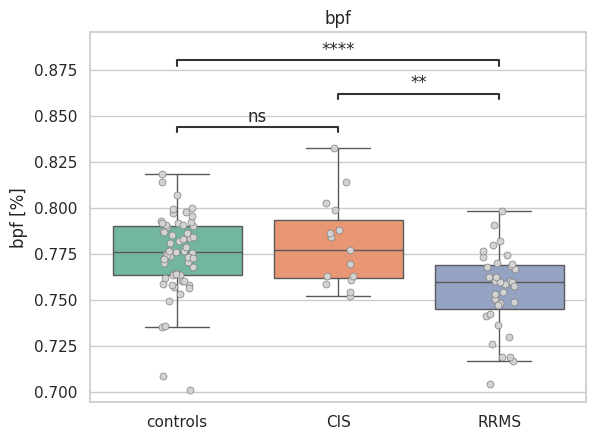

In [141]:
g = sns.boxplot(data=df, x='group', y='bpf', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='bpf', linewidth=0.5, color='lightgrey')
g.set_ylabel("bpf [%]")
g.set_xlabel("")
g.set_title("bpf")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='bpf')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## deep wm, läsionsvolumen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.764e-06 U_stat=1.025e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.194e-02 U_stat=1.770e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.337e-12 U_stat=1.365e+02


(<Axes: title={'center': 'Volume, deep wm'}, ylabel='deepwm volume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1d856a0>])

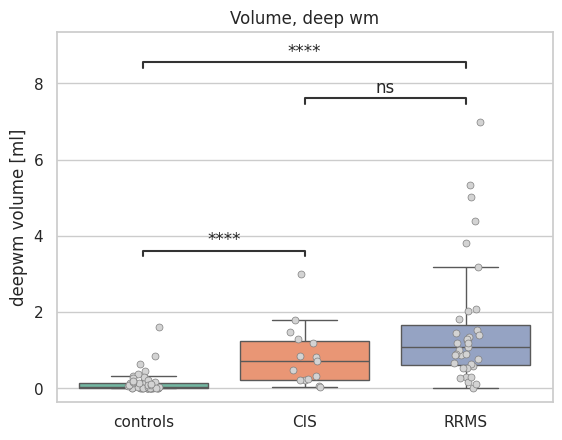

In [142]:
g = sns.boxplot(data=df, x='group', y='deepwm volume', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='deepwm volume', linewidth=0.5, color='lightgrey')
g.set_ylabel("deepwm volume [ml]")
g.set_xlabel("")
g.set_title("Volume, deep wm")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='deepwm volume')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## deep wm, läsionsanzahl

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.066e-05 U_stat=1.395e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.051e-01 U_stat=1.855e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-11 U_stat=2.005e+02


(<Axes: title={'center': 'Lesioncount, deepwm'}, ylabel='deepwm lesioncount [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1c24440>])

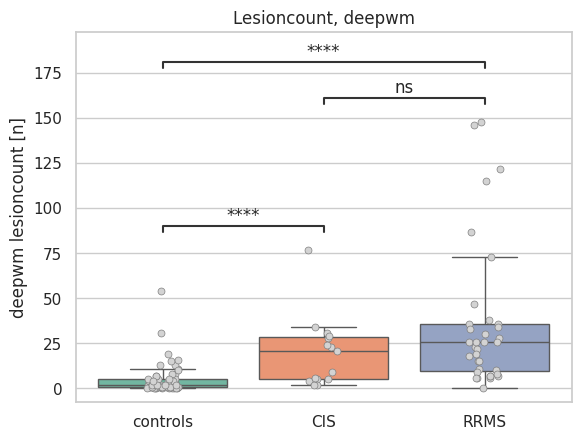

In [143]:
g = sns.boxplot(data=df, x='group', y='deepwm n_lesions', hue='group', fliersize=0) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df, x='group', y='deepwm n_lesions', linewidth=0.5, color='lightgrey')
g.set_ylabel("deepwm lesioncount [n]")
g.set_xlabel("")
g.set_title("Lesioncount, deepwm")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=df, x='group', y='deepwm n_lesions')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

# Tabelle läsionen vs. gruppen, mit mean und std

In [144]:
df.groupby(by=['group']).agg({
    'bpf': ['mean', 'std'],
    'total_lesion_volume': ['mean', 'std'],
    'total_lesion_count': ['mean', 'std'],
    'deepwm volume': ['mean', 'std'],
    'deepwm n_lesions': ['mean', 'std'],
    'white_matter_total volume': ['mean', 'std'],
    'gray_matter_total volume': ['mean', 'std'],
                              }).transpose()


group                                  CIS        RRMS    controls
bpf                       mean    0.780382    0.755256    0.774883
                          std     0.023722    0.021583    0.021620
total_lesion_volume       mean    3.377333    7.404571    0.522712
                          std     4.144338   11.865322    0.780411
total_lesion_count        mean   31.733333   56.742857    8.881356
                          std    31.019502   56.383844    9.404850
deepwm volume             mean    0.850667    1.598286    0.138983
                          std     0.804021    1.639262    0.251613
deepwm n_lesions          mean   20.000000   36.171429    4.915254
                          std    19.654153   39.882538    8.626919
white_matter_total volume mean  475.212000  480.423143  511.820169
                          std    51.645726   55.159099   53.072244
gray_matter_total volume  mean  697.706667  678.820571  713.042881
                          std    68.748781   63.854526   66.756641

# CI/CP

## Tabelle mit CI/CP, nach BICAMS und nach Gruppen

## ... bei SDMT nach lesionscount total, vs. gruppen

In [145]:
# test SDMT mit 38 als Grenzwert für CI(CP
# cognitve SDMT Impairment - ganz oben deklariert
# df.loc[df['SDMT'] >= 38, "SDMT mit CI/CP"] = "CP"
# df.loc[df['SDMT'] < 38, "SDMT mit CI/CP"] = "CI"

# g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
# sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"],  dodge=True, color="lightgray")
# g.set_ylabel("total lesioncount [n]")
# g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[
#     (('CIS','CP'), ('CIS','CI')),
#     (('RRMS','CP'),('RRMS','CI'))
#     ]
# annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT mit CI/CP')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:8.550e-01 U_stat=1.305e+02
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:2.955e-01 U_stat=1.200e+01


/tmp/nix-shell-7033-0/ipykernel_38878/4114043739.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesioncount [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d4dbe9f0>])

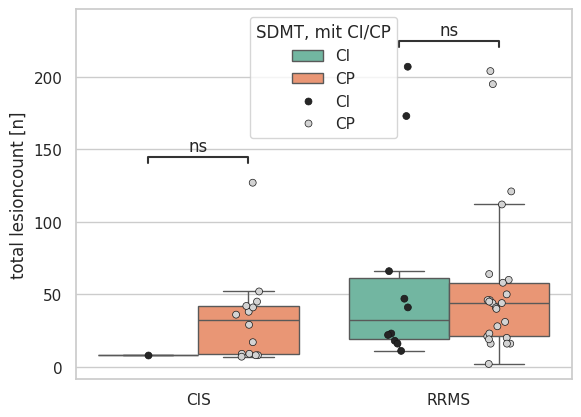

In [146]:

# cognitve SDMT Impairment - ganz oben deklariert
hc_SDMT_mean = df.query('group == "controls" ')['SDMT'].mean()
hc_SDMT_std = df.query('group == "controls" ')['SDMT'].std()

# SDMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
SDMT_border = hc_SDMT_mean - 1.5 * hc_SDMT_std

df.loc[df['SDMT'] >= SDMT_border , "SDMT, mit CI/CP"] = "CP"
df.loc[df['SDMT'] < SDMT_border, "SDMT, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesioncount [n]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='SDMT, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ... bei SDMT nach lesionsvolume total, vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:3.518e-01 U_stat=1.510e+02
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.333e-01 U_stat=1.400e+01


/tmp/nix-shell-7033-0/ipykernel_38878/1785299903.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesionvolume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1a22b70>])

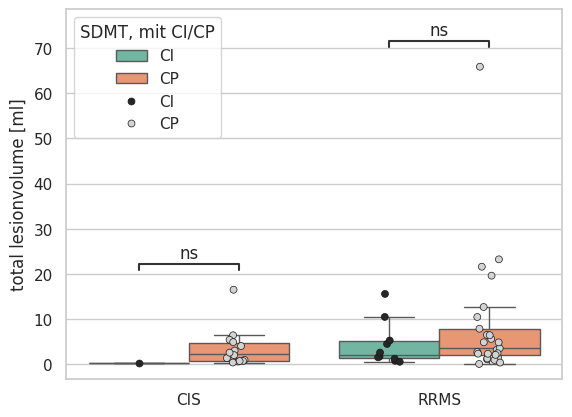

In [147]:
# cognitve SDMT Impairment - ganz oben deklariert
hc_SDMT_mean = df.query('group == "controls" ')['SDMT'].mean()
hc_SDMT_std = df.query('group == "controls" ')['SDMT'].std()

# SDMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
SDMT_border = hc_SDMT_mean - 1.5 * hc_SDMT_std

df.loc[df['SDMT'] >= SDMT_border , "SDMT, mit CI/CP"] = "CP"
df.loc[df['SDMT'] < SDMT_border, "SDMT, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='SDMT, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesionvolume [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='SDMT, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## CI/CP mit Zusammenlegung CIS und RRMS, SDMT

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. CI: Mann-Whitney-Wilcoxon test two-sided, P_val:3.862e-01 U_stat=2.520e+02


/tmp/nix-shell-7033-0/ipykernel_38878/2466541537.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='SDMT, mit CI/CP', y='total_lesion_volume', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], color="lightgray") # dogde raus genommen


(<Axes: ylabel='total lesionvolume [ml]'>,
 [<statannotations.Annotation.Annotation at 0x7fa6d6c03d40>])

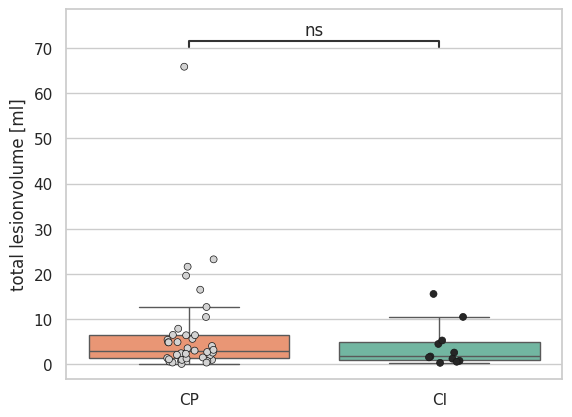

In [148]:
# cognitve SDMT Impairment - ganz oben deklariert
hc_SDMT_mean = df.query('group == "controls" ')['SDMT'].mean()
hc_SDMT_std = df.query('group == "controls" ')['SDMT'].std()

# SDMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
SDMT_border = hc_SDMT_mean - 1.5 * hc_SDMT_std

df.loc[df['SDMT'] >= SDMT_border , "SDMT, mit CI/CP"] = "CP"
df.loc[df['SDMT'] < SDMT_border, "SDMT, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='SDMT, mit CI/CP', y='total_lesion_volume', hue='SDMT, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='SDMT, mit CI/CP', y='total_lesion_volume', hue='SDMT, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], color="lightgray") # dogde raus genommen
g.set_ylabel("total lesionvolume [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CP','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='SDMT, mit CI/CP', y='total_lesion_volume', hue='SDMT, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## CI/CP mit Zusammenlegung CIS und RRMS, CVLT

## !! ... bei SDMT nach volume, gm total, vs. gruppen - noch zu bearbeiten!!!

/tmp/nix-shell-7033-0/ipykernel_38878/4283292012.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='SDMT mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"],  dodge=True, color="lightgray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:8.605e-01 U_stat=3.600e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan


/home/paul/Dokumente/projects/earlycogdys/venv/lib/python3.12/site-packages/statannotations/stats/StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


(<Axes: ylabel='gm-volume, total [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d190c0e0>])

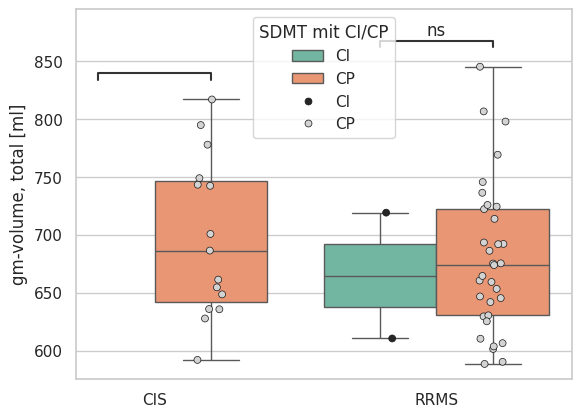

In [149]:
# cognitve SDMT Impairment - ganz oben deklariert
df.loc[df['SDMT'] >= 38, "SDMT mit CI/CP"] = "CP"
df.loc[df['SDMT'] < 38, "SDMT mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='SDMT mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='SDMT mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"],  dodge=True, color="lightgray")
g.set_ylabel("gm-volume, total [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='SDMT mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## !! ... bei SDMT nach bpf, vs. gruppen - noch zu bearbeiten!!!

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:8.605e-01 U_stat=3.600e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan


/tmp/nix-shell-7033-0/ipykernel_38878/639838556.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='SDMT mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"],  dodge=True, color="lightgray")
/home/paul/Dokumente/projects/earlycogdys/venv/lib/python3.12/site-packages/statannotations/stats/StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


(<Axes: ylabel='bpf [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1849af0>])

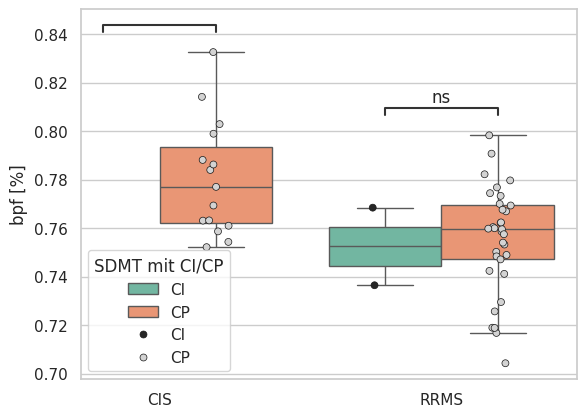

In [150]:
# cognitve SDMT Impairment - ganz oben deklariert
df.loc[df['SDMT'] >= 38, "SDMT mit CI/CP"] = "CP"
df.loc[df['SDMT'] < 38, "SDMT mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='SDMT mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='SDMT mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"],  dodge=True, color="lightgray")
g.set_ylabel("bpf [%]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='bpf', hue='SDMT mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ... bei CVLT, total nach lesionscount total, vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CI vs. RRMS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.605e-01 U_stat=1.325e+02
CIS_CI vs. CIS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.007e-01 U_stat=2.100e+01


/tmp/nix-shell-7033-0/ipykernel_38878/3395173648.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesioncount [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1703cb0>])

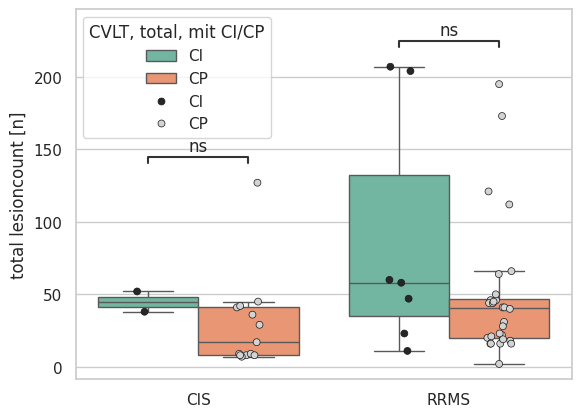

In [151]:
# cognitve CVLT Impairment - ganz oben deklariert
hc_cvlt_mean = df.query('group == "controls" ')['CVLT_Total'].mean()
hc_cvlt_std = df.query('group == "controls" ')['CVLT_Total'].std()

# CVLT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
cvlt_border = hc_cvlt_mean - 1.5 * hc_cvlt_std

df.loc[df['CVLT_Total'] >= cvlt_border , "CVLT, total, mit CI/CP"] = "CP"
df.loc[df['CVLT_Total'] < cvlt_border, "CVLT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='CVLT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesioncount [n]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='CVLT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ... bei CVLT, total nach lesionsvolume total, vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CI vs. RRMS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.615e-01 U_stat=1.210e+02
CIS_CI vs. CIS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:4.762e-01 U_stat=1.800e+01


/tmp/nix-shell-7033-0/ipykernel_38878/2376717530.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesionvolume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d16c54c0>])

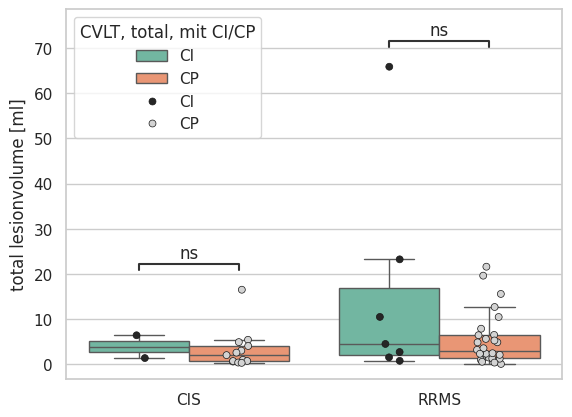

In [152]:
# cognitve CVLT Impairment - ganz oben deklariert
hc_cvlt_mean = df.query('group == "controls" ')['CVLT_Total'].mean()
hc_cvlt_std = df.query('group == "controls" ')['CVLT_Total'].std()

# CVLT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
cvlt_border = hc_cvlt_mean - 1.5 * hc_cvlt_std

df.loc[df['CVLT_Total'] >= cvlt_border , "CVLT, total, mit CI/CP"] = "CP"
df.loc[df['CVLT_Total'] < cvlt_border, "CVLT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='CVLT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesionvolume [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='CVLT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ... bei CVLT, total nach volume, gm total, vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CI vs. RRMS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:6.566e-02 U_stat=1.430e+02
CIS_CI vs. CIS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:9.333e-01 U_stat=1.200e+01


/tmp/nix-shell-7033-0/ipykernel_38878/2440702013.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='gm-volume, total [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d2019cd0>])

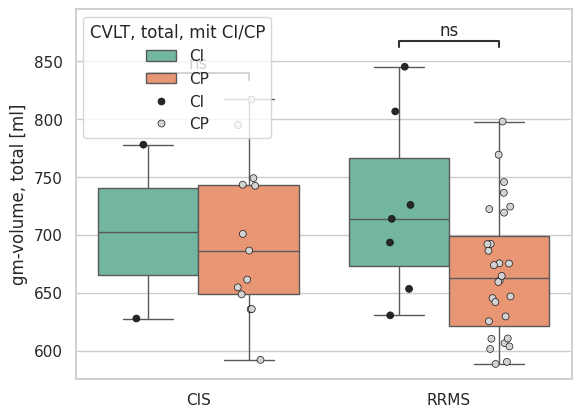

In [153]:
# cognitve CVLT Impairment - ganz oben deklariert
hc_cvlt_mean = df.query('group == "controls" ')['CVLT_Total'].mean()
hc_cvlt_std = df.query('group == "controls" ')['CVLT_Total'].std()

# CVLT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
cvlt_border = hc_cvlt_mean - 1.5 * hc_cvlt_std

df.loc[df['CVLT_Total'] >= cvlt_border , "CVLT, total, mit CI/CP"] = "CP"
df.loc[df['CVLT_Total'] < cvlt_border, "CVLT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='CVLT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("gm-volume, total [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='CVLT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ... bei CVLT, total nach bpf, vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CI vs. RRMS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.043e-01 U_stat=5.800e+01
CIS_CI vs. CIS_CP: Mann-Whitney-Wilcoxon test two-sided, P_val:5.714e-01 U_stat=9.000e+00


/tmp/nix-shell-7033-0/ipykernel_38878/2250352624.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='bpf [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1ff9910>])

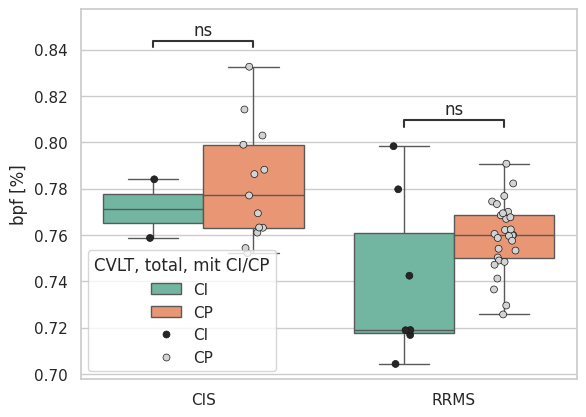

In [154]:
# cognitve CVLT Impairment - ganz oben deklariert
hc_cvlt_mean = df.query('group == "controls" ')['CVLT_Total'].mean()
hc_cvlt_std = df.query('group == "controls" ')['CVLT_Total'].std()

# CVLT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
cvlt_border = hc_cvlt_mean - 1.5 * hc_cvlt_std

df.loc[df['CVLT_Total'] >= cvlt_border , "CVLT, total, mit CI/CP"] = "CP"
df.loc[df['CVLT_Total'] < cvlt_border, "CVLT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='CVLT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='CVLT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("bpf [%]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='bpf', hue='CVLT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## !! ...bei BVMT-R nach lesionscount total vs. gruppen, noch zu bearbeiten

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:4.212e-01 U_stat=4.600e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:5.611e-01 U_stat=4.000e+00


/tmp/nix-shell-7033-0/ipykernel_38878/3379726911.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='BVMT-R_Total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesioncount [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d159b830>])

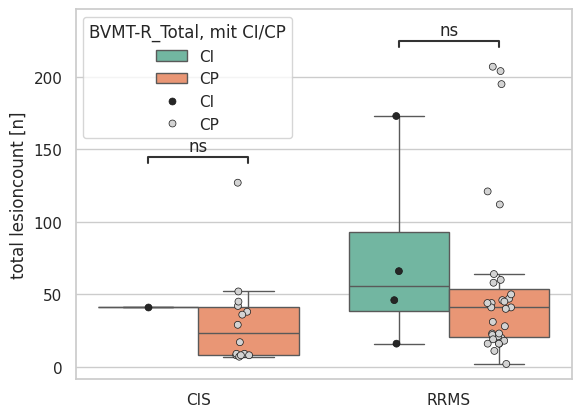

In [155]:
# cognitve BVMT Impairment - ganz oben deklariert
hc_BVMT_R_mean = df.query('group == "controls" ')['BVMT-R_Total'].mean()
hc_BVMT_R_std = df.query('group == "controls" ')['BVMT-R_Total'].std()

# BVMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
BVMT_R_border = hc_BVMT_R_mean - 1.5 * hc_BVMT_R_std

df.loc[df['BVMT-R_Total'] >= BVMT_R_border, "BVMT-R_Total, mit CI/CP"] = "CP"
df.loc[df['BVMT-R_Total'] < BVMT_R_border, "BVMT-R_Total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='BVMT-R_Total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='BVMT-R_Total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesioncount [n]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_count', hue='BVMT-R_Total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ...bei BVMT-R nach lesionsvolume total vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:5.994e-01 U_stat=5.100e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=2.000e+00


/tmp/nix-shell-7033-0/ipykernel_38878/952448556.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='total lesionvolume [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d2248530>])

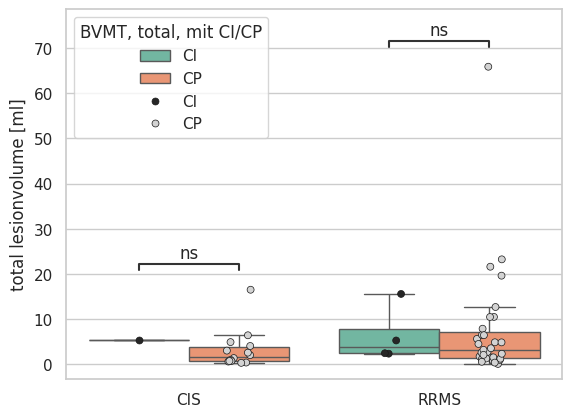

In [156]:
# cognitve BVMT Impairment - ganz oben deklariert
hc_BVMT_R_mean = df.query('group == "controls" ')['BVMT-R_Total'].mean()
hc_BVMT_R_std = df.query('group == "controls" ')['BVMT-R_Total'].std()

# BVMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
BVMT_R_border = hc_BVMT_R_mean - 1.5 * hc_BVMT_R_std

df.loc[df['BVMT-R_Total'] >= BVMT_R_border, "BVMT, total, mit CI/CP"] = "CP"
df.loc[df['BVMT-R_Total'] < BVMT_R_border, "BVMT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='BVMT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("total lesionvolume [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='total_lesion_volume', hue='BVMT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ...bei BVMT-R nach volume, gm total vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:9.005e-01 U_stat=6.500e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=4.000e+00


/tmp/nix-shell-7033-0/ipykernel_38878/2056435804.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='gm-volume, total [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d19f1940>])

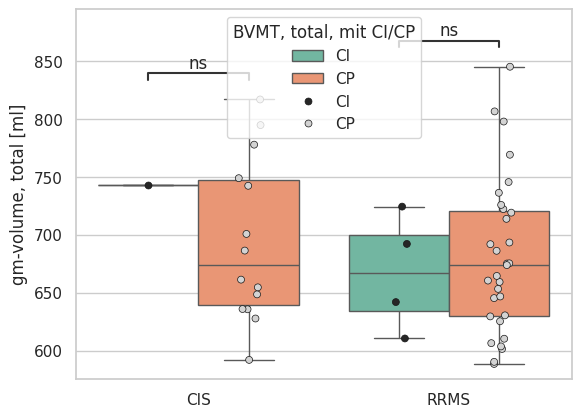

In [157]:
# cognitve BVMT Impairment - ganz oben deklariert
hc_BVMT_R_mean = df.query('group == "controls" ')['BVMT-R_Total'].mean()
hc_BVMT_R_std = df.query('group == "controls" ')['BVMT-R_Total'].std()

# BVMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
BVMT_R_border = hc_BVMT_R_mean - 1.5 * hc_BVMT_R_std

df.loc[df['BVMT-R_Total'] >= BVMT_R_border, "BVMT, total, mit CI/CP"] = "CP"
df.loc[df['BVMT-R_Total'] < BVMT_R_border, "BVMT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='BVMT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("gm-volume, total [ml]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='gray_matter_total volume', hue='BVMT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## ...bei BVMT-R nach bpf vs. gruppen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RRMS_CP vs. RRMS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:5.649e-01 U_stat=7.400e+01
CIS_CP vs. CIS_CI: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=4.000e+00


/tmp/nix-shell-7033-0/ipykernel_38878/317687341.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.

  sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")


(<Axes: ylabel='bpf [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1348b60>])

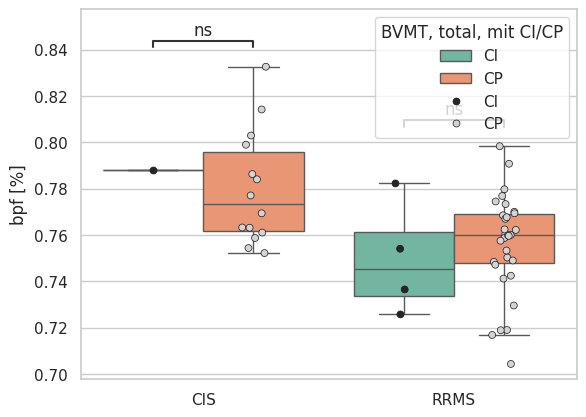

In [158]:
# cognitve BVMT Impairment - ganz oben deklariert
hc_BVMT_R_mean = df.query('group == "controls" ')['BVMT-R_Total'].mean()
hc_BVMT_R_std = df.query('group == "controls" ')['BVMT-R_Total'].std()

# BVMT Grenzwert ausrechnen, um zwischen CP und CI zu unterscheiden
BVMT_R_border = hc_BVMT_R_mean - 1.5 * hc_BVMT_R_std

df.loc[df['BVMT-R_Total'] >= BVMT_R_border, "BVMT, total, mit CI/CP"] = "CP"
df.loc[df['BVMT-R_Total'] < BVMT_R_border, "BVMT, total, mit CI/CP"] = "CI"

g = sns.boxplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='BVMT, total, mit CI/CP', fliersize=0, hue_order=["CI", "CP"]) # hue -> farbe der Boxen unterschiedlich
sns.stripplot(data=df.query('group != "controls"'), x='group', y='bpf', hue='BVMT, total, mit CI/CP', linewidth=0.5, hue_order=["CI", "CP"], dodge=True, color="lightgray")
g.set_ylabel("bpf [%]")
g.set_xlabel("")
# g.set_ylim([0, 25])

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[
    (('CIS','CP'), ('CIS','CI')),
    (('RRMS','CP'),('RRMS','CI'))
    ]
annotator = Annotator(g, pairs, data=df.query('group != "controls"'), x='group', y='bpf', hue='BVMT, total, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

# Balken

## Daten, Balken gesamt

### Balken, Lesionsvolume gesamt

In [159]:

list(cc_df.columns)

['Unnamed: 0',
 'Nr.',
 'Group',
 'ID',
 'Test Date',
 'MRT Date',
 'Age',
 'Sex',
 'Bemerkungen',
 'Education',
 'Yrs education',
 'Employment',
 'Medication_other',
 'Smoking',
 'Smoking_nr',
 'Alcohol',
 'BVMT-R_Total',
 'SDMT',
 'CVLT_1',
 'CVLT_2',
 'CVLT_3',
 'CVLT_4',
 'CVLT_5',
 'CVLT_Total',
 'EDSS',
 '25FW_1 (sec)',
 '25FW_2 (sec)',
 '2min_walk (m)',
 'FAP_nomal',
 'FAP_dual',
 'Contrast Sensitivity',
 '9HPT',
 'pRNFL_L_total',
 'pRNFL_L_inferior',
 'pRNFL_L_temporal',
 'pRNFL_L_superior',
 'pRNFL_L_nasal',
 'pRNFL_R_total',
 'pRNFL_R_inferior',
 'pRNFL_R_temporal',
 'pRNFL_R_superior',
 'pRNFL_R_nasal',
 'Macular_Volume_L',
 'Macular_Volume_R',
 'Macular_Thickness_L',
 'Macular_Thickness_R',
 'Bemerkungen.1',
 'ID.1',
 'MRT Date.1',
 'L_transaction_id',
 'StudyDate',
 'V_transaction_id',
 'StudyDate.1',
 'bpf',
 'Manifestation_MS',
 'Diagnosis_MS',
 'Duration_MS_yrs',
 'Medication_MS',
 'Medication_name',
 'Contrast Sensitivity (Ergebnis bei 2,5%)',
 '9HPT (sek.)',
 'session

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions, CC gesamt'}, ylabel='lesionsvolume CC [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d118f110>])

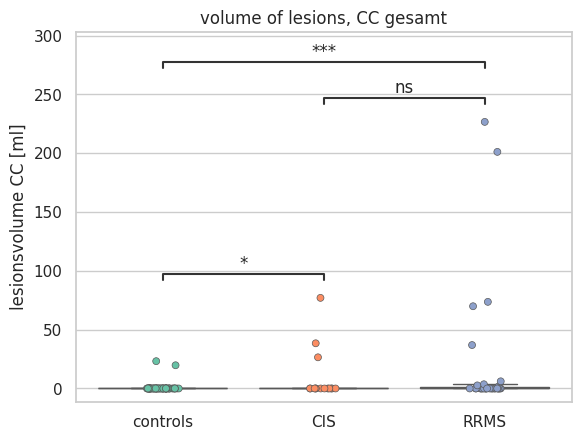

In [160]:
g = sns.boxplot(cc_df, y='total_roi_lv', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='total_roi_lv', x='group', linewidth=0.5, hue='group') # Alle als Einzelpunkte # , color='lightgrey'
g.set_xlabel("")
g.set_ylabel("lesionsvolume CC [ml]")
g.set_title("volume of lesions, CC gesamt")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

### Balken, Lesionsvolume mit > 0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions (> 0), CC total'}, ylabel='lesionsvolume CC [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d122f980>])

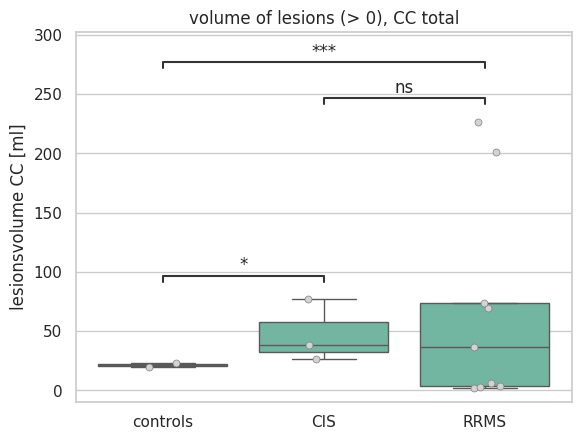

In [161]:
g = sns.boxplot(data=cc_df.query('total_roi_lv != 0'), y='total_roi_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(data=cc_df.query('total_roi_lv != 0'), y='total_roi_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("lesionsvolume CC [ml]")
g.set_title("volume of lesions (> 0), CC total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()


### Balken, Lesionsfraction, gesamt

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.190e-01 U_stat=2.300e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'fraction of lesions, CC gesamt'}, ylabel='lesionsfraction CC [%]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d134ade0>])

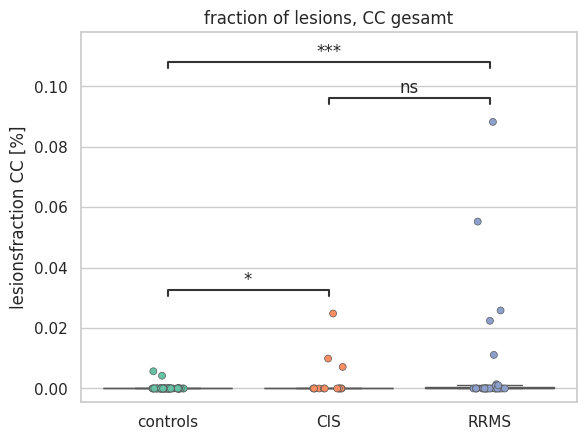

In [162]:
g = sns.boxplot(cc_df, y='total_roi_lesion_fraction', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='total_roi_lesion_fraction', x='group', linewidth=0.5, hue='group') # Alle als Einzelpunkte # , color='lightgrey'
g.set_xlabel("")
g.set_ylabel("lesionsfraction CC [%]")
g.set_title("fraction of lesions, CC gesamt")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lesion_fraction')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

### Balken, Lesionsfraction mit > 0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.190e-01 U_stat=2.300e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


/tmp/nix-shell-7033-0/ipykernel_38878/1800849511.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(data=cc_df.query('total_roi_lesion_fraction != 0'), y='total_roi_lesion_fraction', x='group', linewidth=0.5, color='lightgrey', hue='group') # Alle als Einzelpunkte


(<Axes: title={'center': 'fraction of lesions (> 0), CC total'}, ylabel='lesionfraction CC [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d113ee70>])

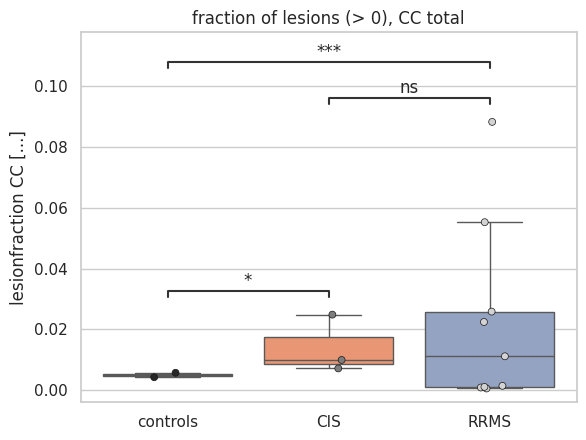

In [163]:
g = sns.boxplot(data=cc_df.query('total_roi_lesion_fraction != 0'), y='total_roi_lesion_fraction', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(data=cc_df.query('total_roi_lesion_fraction != 0'), y='total_roi_lesion_fraction', x='group', linewidth=0.5, color='lightgrey', hue='group') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("lesionfraction CC [...]")
g.set_title("fraction of lesions (> 0), CC total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lesion_fraction')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

### Balken, Lesionscount, gesamt

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.607e-02 U_stat=3.700e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.574e-01 U_stat=2.270e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.202e-04 U_stat=7.415e+02


(<Axes: title={'center': 'count of lesions, CC gesamt'}, ylabel='lesion count CC [n]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d224a540>])

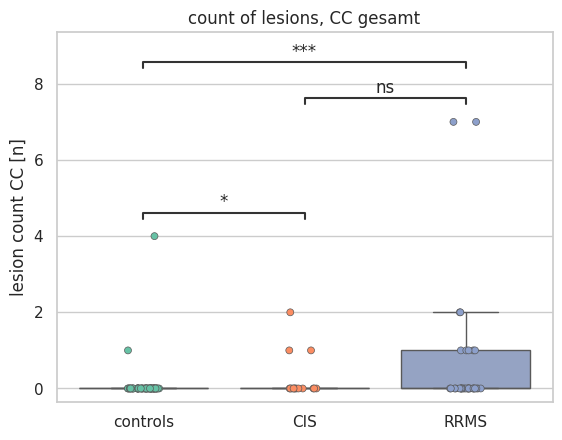

In [164]:
g = sns.boxplot(cc_df, y='total_roi_lesion_count', x='group', fliersize=0, hue='group') # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='total_roi_lesion_count', x='group', linewidth=0.5, hue='group') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("lesion count CC [n]")
g.set_title("count of lesions, CC gesamt")
# color='lightgrey' -> Markerfarbe!
# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lesion_count')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

### Balken, Lesionscount mit > 0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.607e-02 U_stat=3.700e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.574e-01 U_stat=2.270e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.202e-04 U_stat=7.415e+02


(<Axes: title={'center': 'count of lesions (> 0), CC total'}, ylabel='count of lesions CC [count]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d1047fb0>])

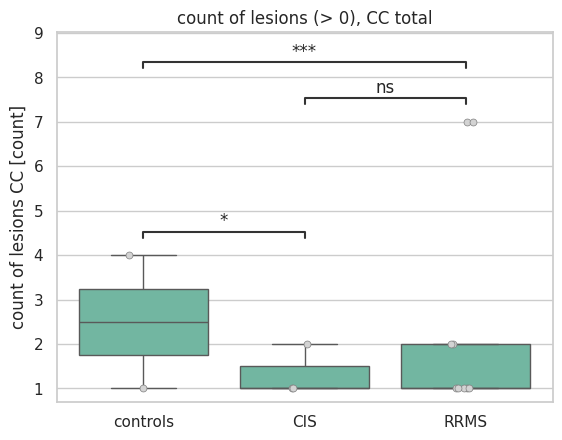

In [165]:
g = sns.boxplot(data=cc_df.query('total_roi_lesion_count != 0'), y='total_roi_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(data=cc_df.query('total_roi_lesion_count != 0'), y='total_roi_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("count of lesions CC [count]")
g.set_title("count of lesions (> 0), CC total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lesion_count')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Daten, Balken Region 1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 1'}, ylabel='roi251_lv [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d113e540>])

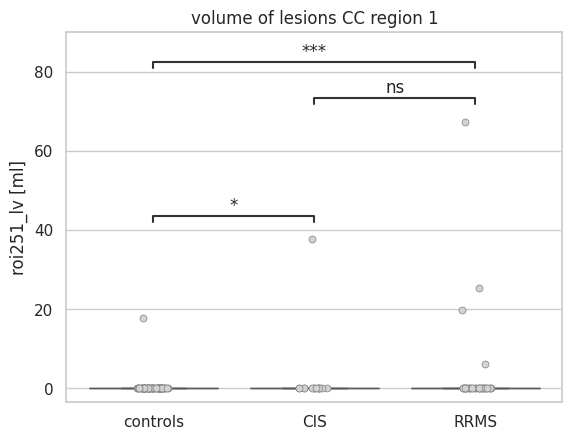

In [166]:
g = sns.boxplot(cc_df, y='roi251_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi251_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi251_lv [ml]")
g.set_title("volume of lesions CC region 1")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 1'}, ylabel='roi251_lesion_fraction [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0dc36e0>])

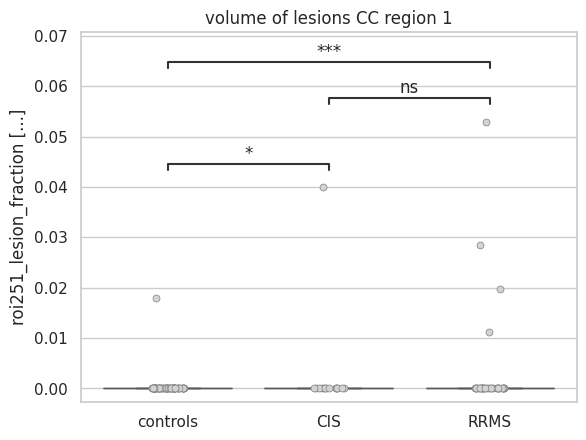

In [167]:
g = sns.boxplot(cc_df, y='roi251_lesion_fraction', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi251_lesion_fraction', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi251_lesion_fraction [...]")
g.set_title("volume of lesions CC region 1")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 1'}, ylabel='roi251_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d113de80>])

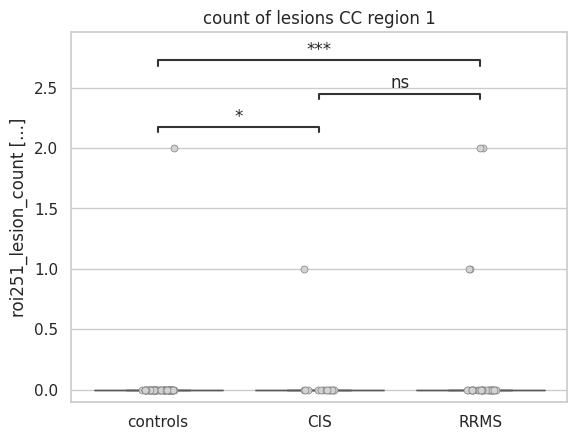

In [168]:
g = sns.boxplot(cc_df, y='roi251_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi251_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi251_lesion_count [...]")
g.set_title("count of lesions CC region 1")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Daten, Balken Region 2

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 2'}, ylabel='roi252_lv [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0cc7500>])

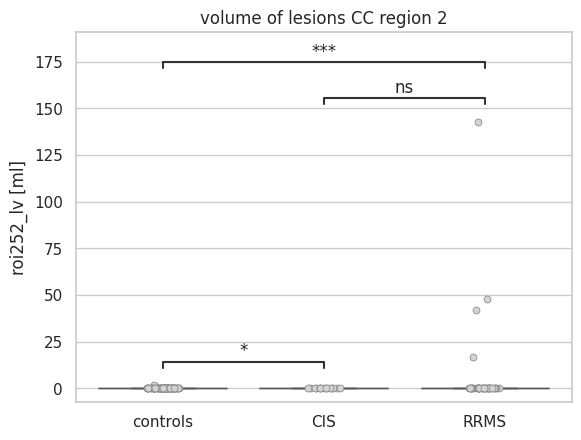

In [169]:
g = sns.boxplot(cc_df, y='roi252_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi252_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi252_lv [ml]")
g.set_title("volume of lesions CC region 2")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'fracture of lesions CC region 2'}, ylabel='roi252_lesion_fraction [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0a91550>])

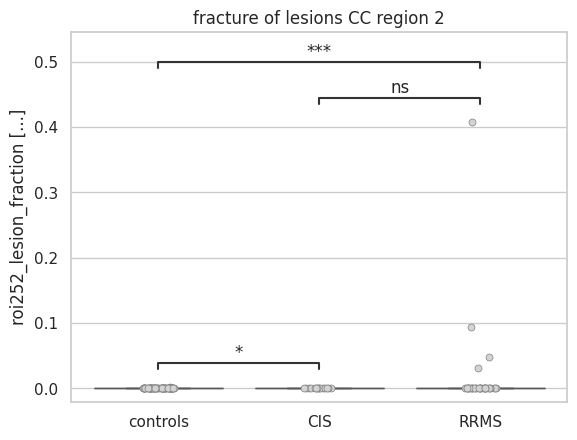

In [170]:
g = sns.boxplot(cc_df, y='roi252_lesion_fraction', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi252_lesion_fraction', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi252_lesion_fraction [...]")
g.set_title("fracture of lesions CC region 2")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 2'}, ylabel='roi252_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0af33e0>])

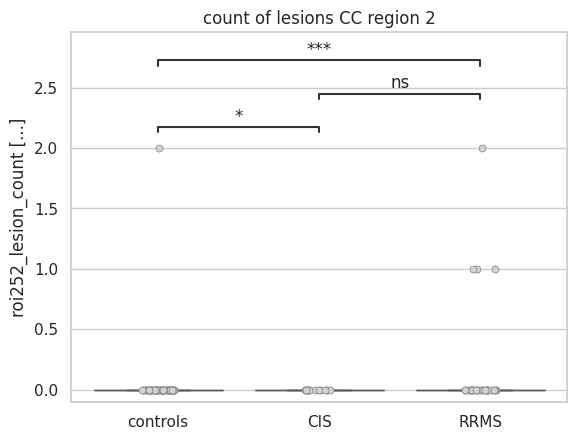

In [171]:
g = sns.boxplot(cc_df, y='roi252_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi252_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi252_lesion_count [...]")
g.set_title("count of lesions CC region 2")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Daten, Balken Region 3

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 3'}, ylabel='roi253_lv [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0a917c0>])

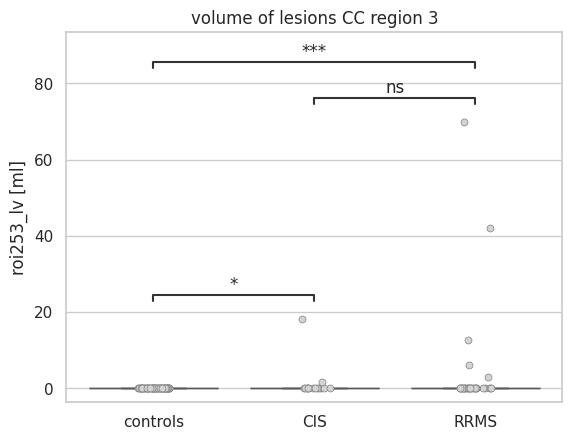

In [172]:
g = sns.boxplot(cc_df, y='roi253_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi253_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi253_lv [ml]")
g.set_title("volume of lesions CC region 3")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'fracture of lesions CC region 3'}, ylabel='roi253_lesion_fraction [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d09b4f20>])

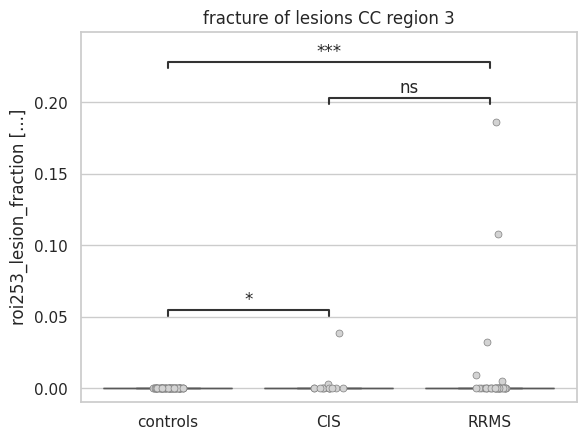

In [173]:
g = sns.boxplot(cc_df, y='roi253_lesion_fraction', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi253_lesion_fraction', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi253_lesion_fraction [...]")
g.set_title("fracture of lesions CC region 3")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 3'}, ylabel='roi253_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d08ab080>])

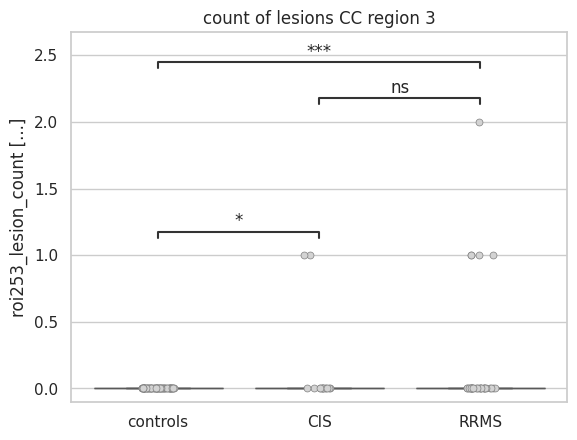

In [174]:
g = sns.boxplot(cc_df, y='roi253_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi253_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi253_lesion_count [...]")
g.set_title("count of lesions CC region 3")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Daten, Balken, Region 4

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 4'}, ylabel='roi254_lv [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0c9e000>])

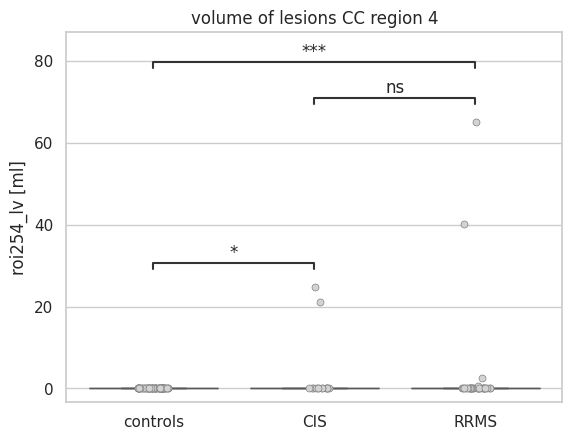

In [175]:
g = sns.boxplot(cc_df, y='roi254_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi254_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi254_lv [ml]")
g.set_title("volume of lesions CC region 4")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 4'}, ylabel='roi254_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0946d20>])

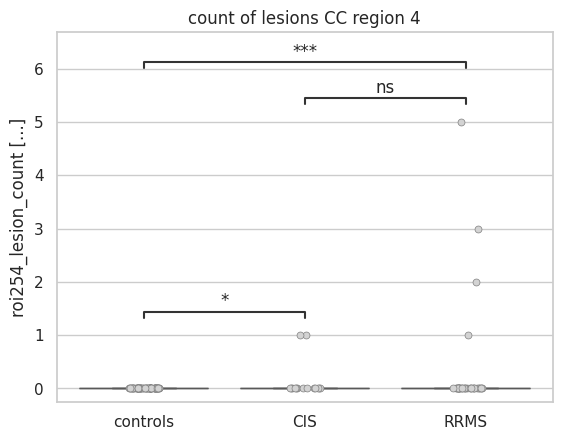

In [176]:
g = sns.boxplot(cc_df, y='roi254_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi254_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi254_lesion_count [...]")
g.set_title("count of lesions CC region 4")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'fracture of lesions CC region 4'}, ylabel='roi254_lesion_fraction [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d06ad0a0>])

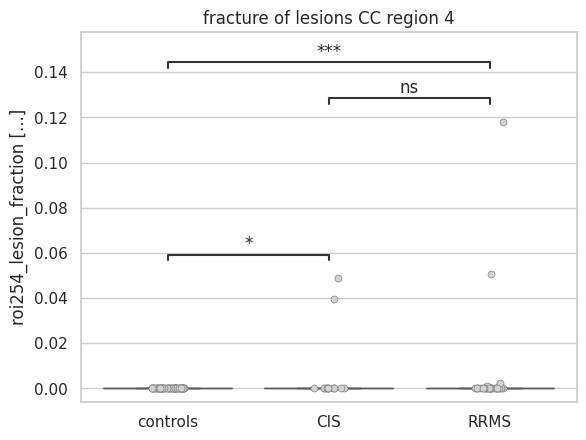

In [177]:
g = sns.boxplot(cc_df, y='roi254_lesion_fraction', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi254_lesion_fraction', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi254_lesion_fraction [...]")
g.set_title("fracture of lesions CC region 4")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 4'}, ylabel='roi254_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d076ae70>])

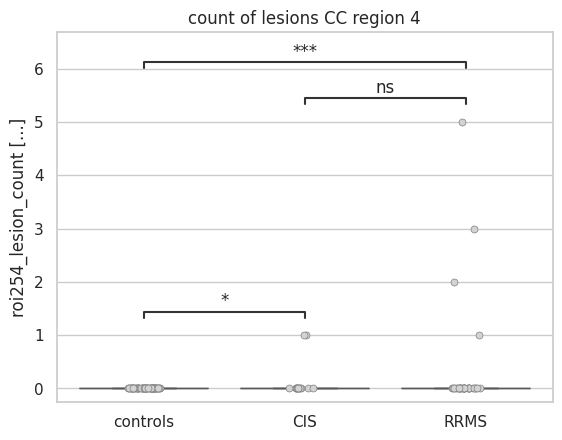

In [178]:
g = sns.boxplot(cc_df, y='roi254_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi254_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi254_lesion_count [...]")
g.set_title("count of lesions CC region 4")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Daten, Balken Region 5

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'volume of lesions CC region 5'}, ylabel='roi255_lv [ml]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d05f67b0>])

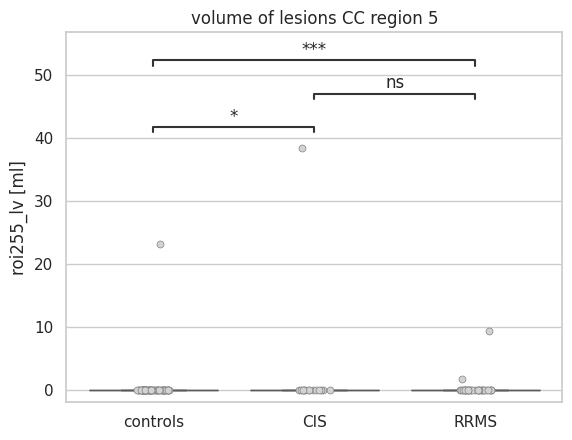

In [179]:
g = sns.boxplot(cc_df, y='roi255_lv', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi255_lv', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi255_lv [ml]")
g.set_title("volume of lesions CC region 5")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'fracture of lesions CC region 5'}, ylabel='roi255_lesion_fraction [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0fef800>])

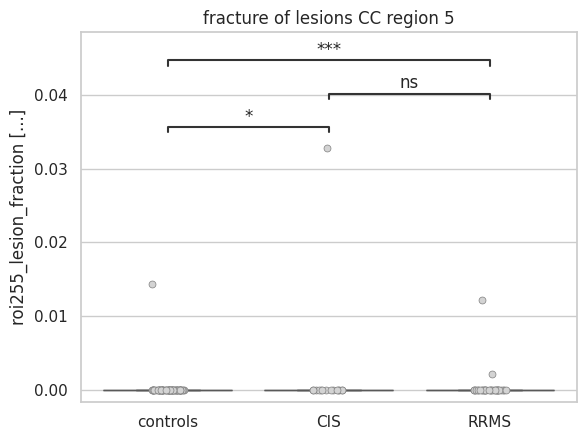

In [180]:
g = sns.boxplot(cc_df, y='roi255_lesion_fraction', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi255_lesion_fraction', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi255_lesion_fraction [...]")
g.set_title("fracture of lesions CC region 5")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

controls vs. CIS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.885e-02 U_stat=3.660e+02
CIS vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-01 U_stat=2.320e+02
controls vs. RRMS: Mann-Whitney-Wilcoxon test two-sided, P_val:7.625e-04 U_stat=7.400e+02


(<Axes: title={'center': 'count of lesions CC region 5'}, ylabel='roi255_lesion_count [...]'>,
  <statannotations.Annotation.Annotation at 0x7fa6d0546cf0>])

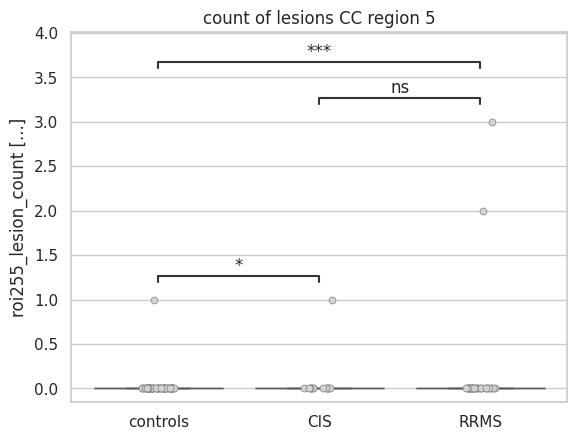

In [181]:
g = sns.boxplot(cc_df, y='roi255_lesion_count', x='group', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df, y='roi255_lesion_count', x='group', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("roi255_lesion_count [...]")
g.set_title("count of lesions CC region 5")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Balken vs. Tests

# plot für CI/CP Balken

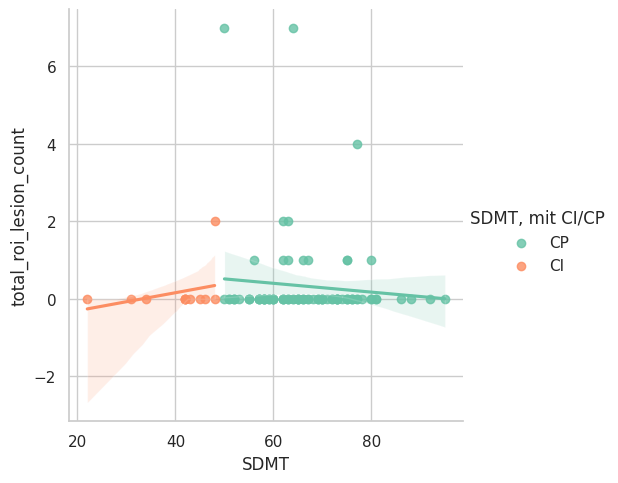

In [182]:
g = sns.lmplot(data=cc_df, y='total_roi_lesion_count', x='SDMT', hue='SDMT, mit CI/CP')

# boxplot, dito

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. CI: Mann-Whitney-Wilcoxon test two-sided, P_val:2.071e-01 U_stat=2.430e+02


/tmp/nix-shell-7033-0/ipykernel_38878/1047323381.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(cc_df.query('group != "controls"'), y='total_roi_lesion_count', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte


(<Axes: title={'center': 'count of lesions CC vs. SDMT CI/CP'}, ylabel='cc lesion_count [n]'>,
 [<statannotations.Annotation.Annotation at 0x7fa6d04a9880>])

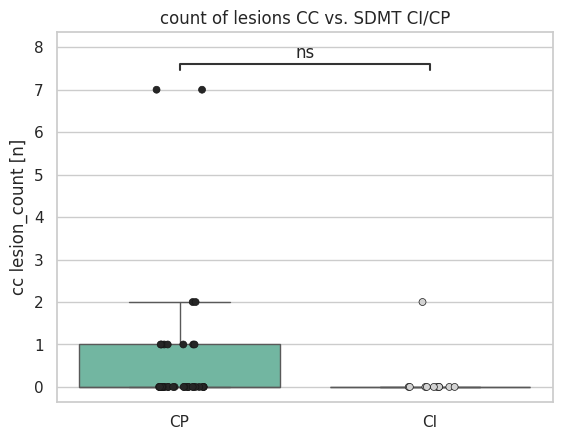

In [183]:
g = sns.boxplot(cc_df.query('group != "controls"'), y='total_roi_lesion_count', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df.query('group != "controls"'), y='total_roi_lesion_count', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("cc lesion_count [n]")
g.set_title("count of lesions CC vs. SDMT CI/CP")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('CP', 'CI')]
annotator = Annotator(g, pairs, data=cc_df.query('group != "controls"'), y='total_roi_lesion_count', x='SDMT, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

# ... Läsionsvolumen

/tmp/nix-shell-7033-0/ipykernel_38878/4117099395.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgrey'` for the same effect.

  sns.stripplot(cc_df.query('group != "controls"'), y='total_roi_lv', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. CI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.295e-01 U_stat=2.510e+02


(<Axes: title={'center': 'volume of lesions CC vs. SDMT CI/CP'}, ylabel='cc lesion_volume [ml]'>,
 [<statannotations.Annotation.Annotation at 0x7fa6d083b230>])

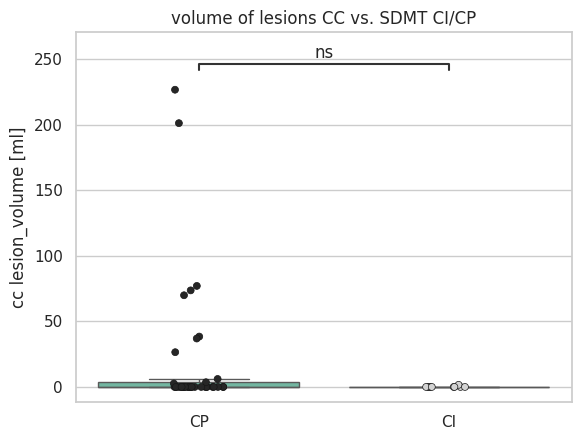

In [184]:
g = sns.boxplot(cc_df.query('group != "controls"'), y='total_roi_lv', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', fliersize=0) # Boxplot ohne Ausreißer
sns.stripplot(cc_df.query('group != "controls"'), y='total_roi_lv', x='SDMT, mit CI/CP', hue='SDMT, mit CI/CP', linewidth=0.5, color='lightgrey') # Alle als Einzelpunkte
g.set_xlabel("")
g.set_ylabel("cc lesion_volume [ml]")
g.set_title("volume of lesions CC vs. SDMT CI/CP")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
pairs=[('CP', 'CI')]
annotator = Annotator(g, pairs, data=cc_df.query('group != "controls"'), y='total_roi_lv', x='SDMT, mit CI/CP')
annotator.configure(test='Mann-Whitney').apply_and_annotate()

## Balken vs. CVLT

### cc total_roi_lv (> 0) vs CVLT total

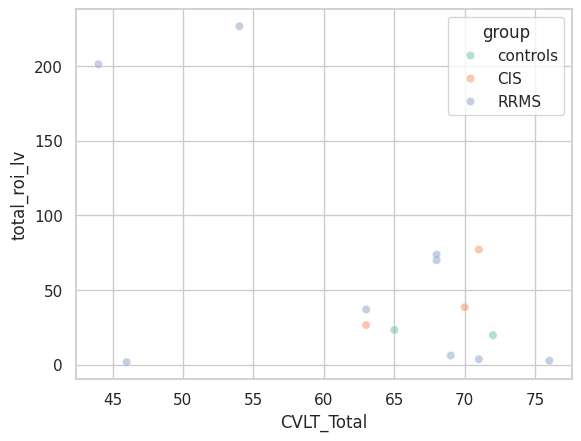

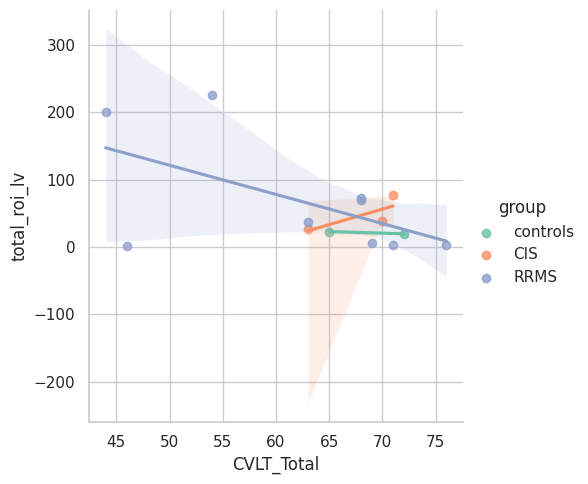

In [185]:
sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_Total', y='total_roi_lv', hue='group',  alpha=0.5)
g = sns.lmplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_Total', y='total_roi_lv', hue='group')
# g.set_xlabel("count of CVLT total")
# g.set_ylabel("volume of lesions [ml]")
# g.set_title("volume of lesions CC total (> 0) vs. CVLT total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=cc_df, x='group', y='total_roi_lv')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()


# value = 0
# g = sns.scatterplot(data=cc_df.query('total_roi_lv > @value'), y='total_roi_lv', x='CVLT_Total', hue='group') # Boxplot ohne Ausreißer

#### Vorlage für folgende Berechnungen - lmplot

In [186]:
# sns.scatterplot(data=cc_df, y='CVLT_Total', x='total_roi_lv', hue='group_name', alpha=0.5)
# g = sns.lmplot(data=cc_df, y='CVLT_Total', x='total_roi_lv', hue='group_name') <<<===
# g.set_ylabel("count of CVLT total")
# g.set_xlabel("volume of lesions [ml]")
# g.set_title("volume of lesions CC total vs. CVLT total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=cc_df, x='group_name', y='total_roi_lv')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()


# value = 0
# g = sns.scatterplot(data=cc_df.query('total_roi_lv > @value'), y='total_roi_lv', x='CVLT_Total', hue='group_name') # Boxplot ohne Ausreißer

#### Vorlage für folgende Berechnungen - Korrelation (r²)

In [187]:
# from scipy.stats import spearmanr <<<===
# df['total_roi_lv']=cc_df
# korrelation, p_wert = spearmanr(cc_df['total_roi_lv'], cc_df['CVLT_Total'], nan_policy='omit') <<<===
# print("r²:", korrelation**2, ", p-Wert:", p_wert) <<<===

# Korr. RRMS
# korrelation, p_wert = spearmanr(cc_df.query('group_name=="RRMS"')['total_roi_lv'], cc_df.query('group_name=="RRMS"')['CVLT_Total'], nan_policy='omit') <<<===
# print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert) <<<===

# Korr. CIS
# korrelation, p_wert = spearmanr(cc_df.query('group_name=="CIS"')['total_roi_lv'], cc_df.query('group_name=="CIS"')['CVLT_Total'], nan_policy='omit') <<<===
# print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert) <<<===

# Korr. HC
# korrelation, p_wert = spearmanr(cc_df.query('group_name=="controls"')['total_roi_lv'], cc_df.query('group_name=="controls"')['CVLT_Total'], nan_policy='omit') <<<===
# print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert) <<<===

### !!! total_roi_lv CC vs CVLT total

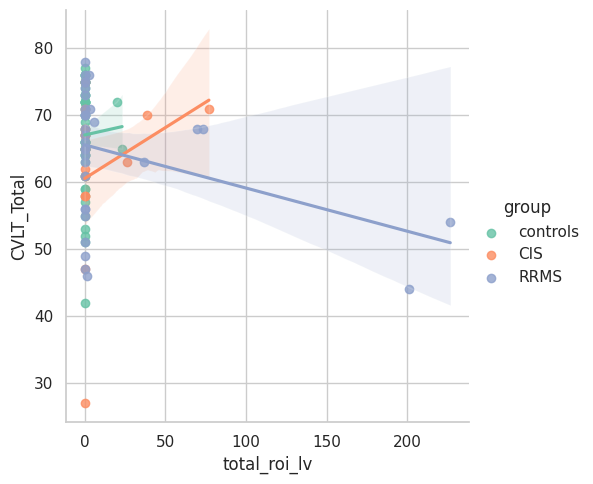

In [188]:
# sns.scatterplot(data=cc_df, y='CVLT_Total', x='total_roi_lv', hue='group_name', alpha=0.5)
g = sns.lmplot(data=cc_df, y='CVLT_Total', x='total_roi_lv', hue='group')
# g.set_ylabel("count of CVLT total")
# g.set_xlabel("volume of lesions [ml]")
# g.set_title("volume of lesions CC total vs. CVLT total")

# Add annotations - signifikanztestung mit Mann-Whitney-U-Test
# pairs=[('controls', 'CIS'),('controls', 'RRMS'), ('CIS', 'RRMS')]
# annotator = Annotator(g, pairs, data=cc_df, x='group_name', y='total_roi_lv')
# annotator.configure(test='Mann-Whitney').apply_and_annotate()


# value = 0
# g = sns.scatterplot(data=cc_df.query('total_roi_lv > @value'), y='total_roi_lv', x='CVLT_Total', hue='group_name') # Boxplot ohne Ausreißer

In [189]:
from scipy.stats import spearmanr
# df['total_roi_lv']=cc_df
korrelation, p_wert = spearmanr(cc_df['total_roi_lv'], cc_df['CVLT_Total'], nan_policy='omit')
print("r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lv'], cc_df.query('group=="RRMS"')['CVLT_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lv'], cc_df.query('group=="CIS"')['CVLT_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lv'], cc_df.query('group=="controls"')['CVLT_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

r²: 0.00286880329712367 , p-Wert: 0.5891932706690428
RRMS- r²: 0.023932103968994447 , p-Wert: 0.39000414259913574
CIS- r²: 0.12934417958563207 , p-Wert: 0.18796028179577257
controls- r²: 6.388950806498557e-07 , p-Wert: 0.9953351379953301


### cc total_roi_lesion_fraction (> 0) vs. CVLT

Text(0.5, 1.0, 'fraction of lesions (> 0) CC total vs. CVLT total')

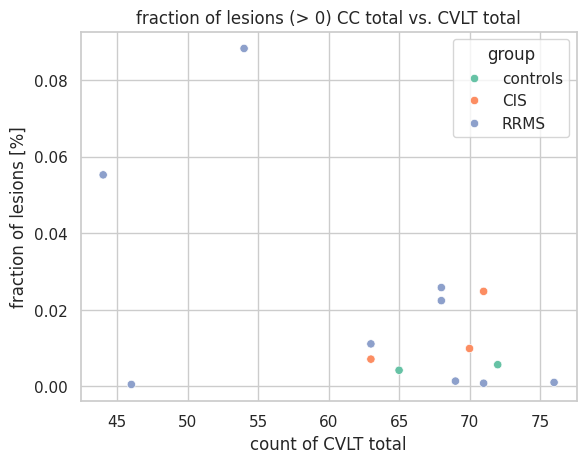

In [190]:
g = sns.scatterplot(data=cc_df.query('total_roi_lesion_fraction != 0'), x='CVLT_Total', y='total_roi_lesion_fraction', hue='group')
g.set_xlabel("count of CVLT total")
g.set_ylabel("fraction of lesions [%]")
g.set_title("fraction of lesions (> 0) CC total vs. CVLT total")

### !!! total_roi_lesion_fraction CC vs. CVLT total

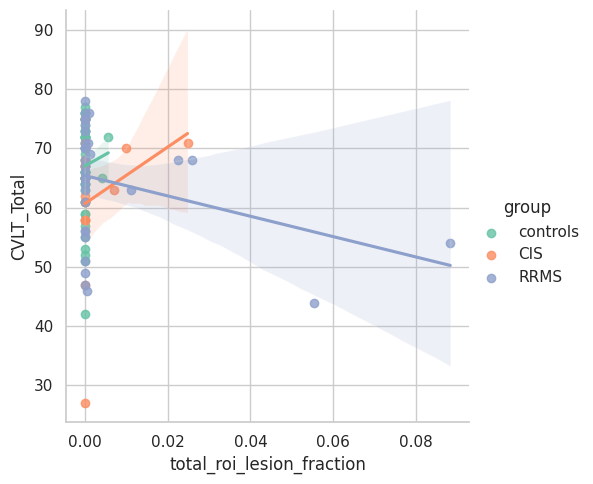

In [191]:
g = sns.lmplot(data=cc_df, y='CVLT_Total', x='total_roi_lesion_fraction', hue='group')

In [192]:
from scipy.stats import spearmanr
# df['total_roi_lesion_fraction']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_fraction'], cc_df.query('group=="RRMS"')['CVLT_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_fraction'], cc_df.query('group=="CIS"')['CVLT_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_fraction'], cc_df.query('group=="controls"')['CVLT_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.02314696219061286 , p-Wert: 0.39798694503696874
CIS- r²: 0.12934417958563207 , p-Wert: 0.18796028179577257
controls- r²: 2.6717172505931084e-05 , p-Wert: 0.9698407089033324


### cc total_roi_lesion_count (> 0) vs. CVLT total

Text(0.5, 1.0, 'count of lesions CC total (> 0) vs. CVLT total')

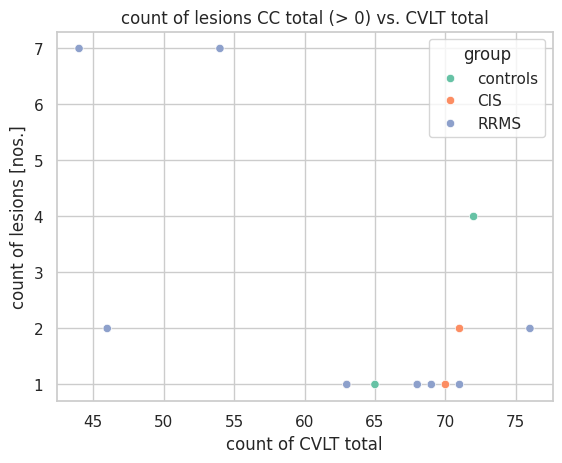

In [193]:
g = sns.scatterplot(data=cc_df.query('total_roi_lesion_count != 0'), x='CVLT_Total', y='total_roi_lesion_count', hue='group')
g.set_xlabel("count of CVLT total")
g.set_ylabel("count of lesions [nos.]")
g.set_title("count of lesions CC total (> 0) vs. CVLT total")

### !!! total_roi_lesion_count CC vs. CVLT total

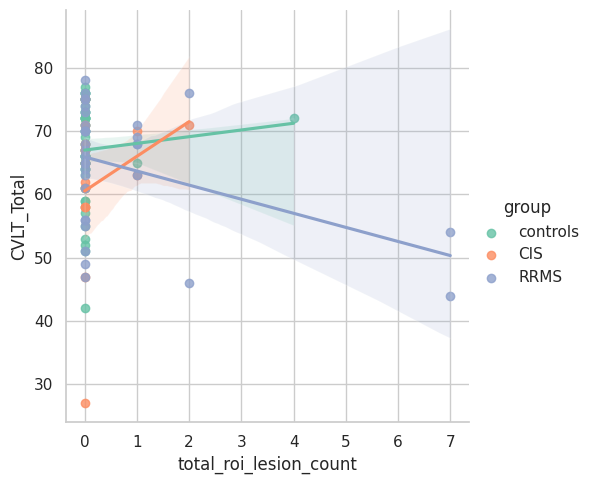

In [194]:
g = sns.lmplot(data=cc_df, y='CVLT_Total', x='total_roi_lesion_count', hue='group')

In [195]:
from scipy.stats import spearmanr
# df['total_roi_lesion_count']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_count'], cc_df.query('group=="RRMS"')['CVLT_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_count'], cc_df.query('group=="CIS"')['CVLT_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_count'], cc_df.query('group=="controls"')['CVLT_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.02775762116608896 , p-Wert: 0.354094977203124
CIS- r²: 0.12074266248413462 , p-Wert: 0.20442989282125676
controls- r²: 2.6717172505931084e-05 , p-Wert: 0.9698407089033324


### cc lv total (> 0) vs. cvlt 1

Text(0.5, 1.0, 'volume of lesions CC total (> 0) vs. CVLT 1')

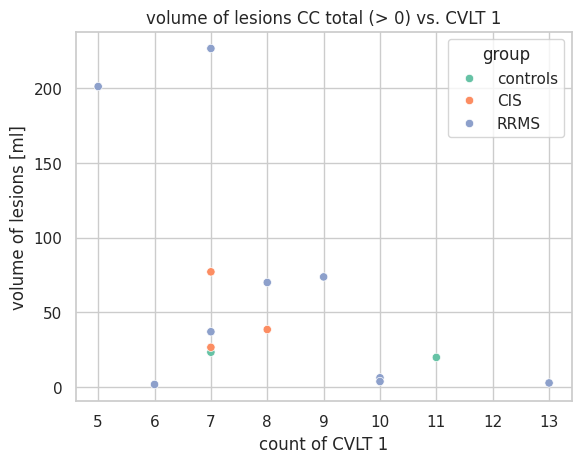

In [196]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_1', y='total_roi_lv', hue='group')
g.set_xlabel("count of CVLT 1")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total (> 0) vs. CVLT 1")

### CC count of lesions (> 0) vs. cvlt 1

Text(0.5, 1.0, 'count of lesions CC total (> 0) vs. CVLT 1')

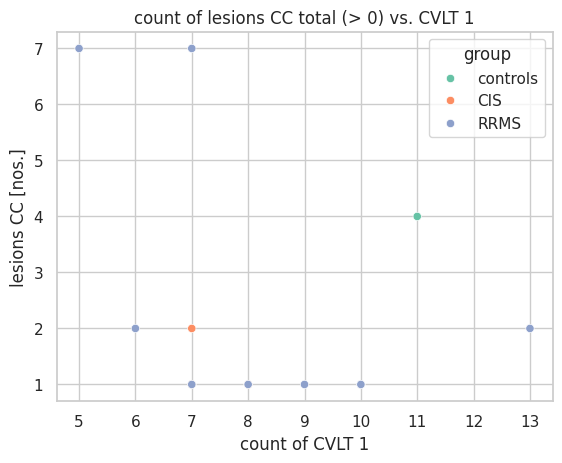

In [197]:
g = sns.scatterplot(data=cc_df.query('total_roi_lesion_count != 0'), x='CVLT_1', y='total_roi_lesion_count', hue='group')
g.set_xlabel("count of CVLT 1")
g.set_ylabel("lesions CC [nos.]")
g.set_title("count of lesions CC total (> 0) vs. CVLT 1")

### cc lv total (> 0) vs cvlt 2

Text(0.5, 1.0, 'volume of lesions CC total vs. CVLT 2')

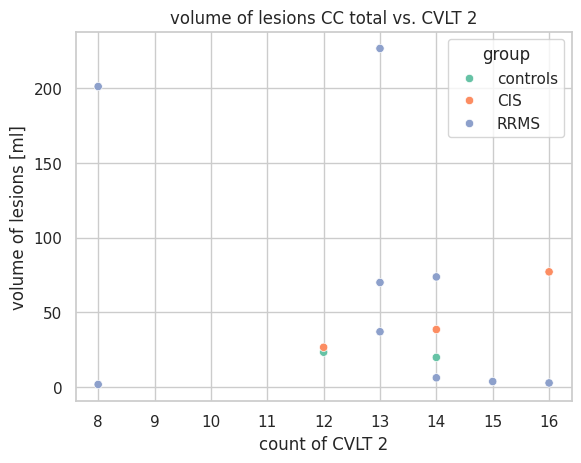

In [198]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_2', y='total_roi_lv', hue='group')
g.set_xlabel("count of CVLT 2")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total vs. CVLT 2")

### cc lv (> 0) total vs. cvlt 3

Text(0.5, 1.0, 'volume of lesions CC total vs. CVLT 3')

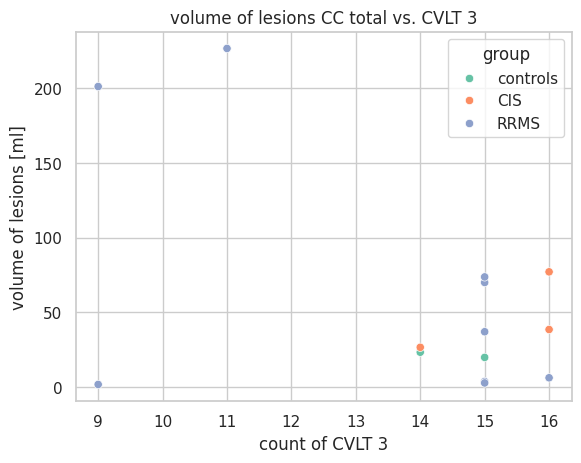

In [199]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_3', y='total_roi_lv', hue='group')
g.set_xlabel("count of CVLT 3")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total vs. CVLT 3")

### cc lv (> 0) total vs. cvlt 4

Text(0.5, 1.0, 'volume of lesions CC total vs. CVLT 4')

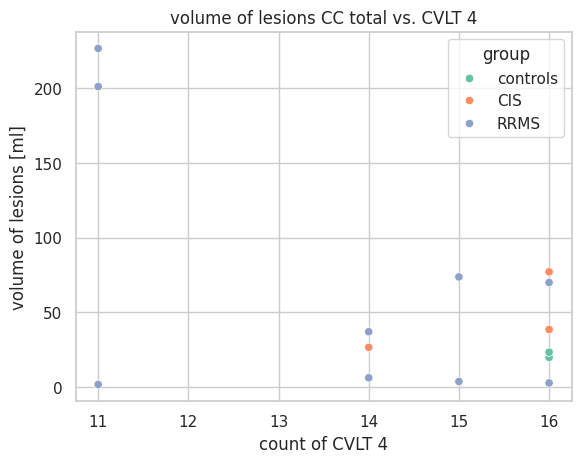

In [200]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_4', y='total_roi_lv', hue='group')
g.set_xlabel("count of CVLT 4")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total vs. CVLT 4")

### cc lv (> 0) total vs. cvlt 5

Text(0.5, 1.0, 'volume of lesions CC total (> 0) vs. CVLT 5')

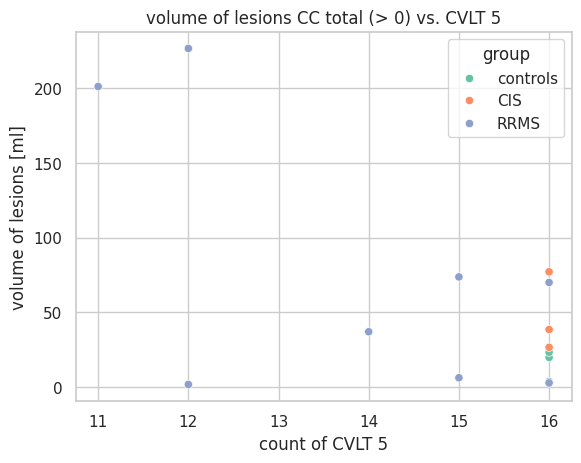

In [201]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='CVLT_5', y='total_roi_lv', hue='group')
g.set_xlabel("count of CVLT 5")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total (> 0) vs. CVLT 5")

## Balken vs SDMT

### CC lesionsvolume (> 0) vs. SDMT

Text(0.5, 1.0, 'volume of lesions CC total (> 0) vs. SDMT')

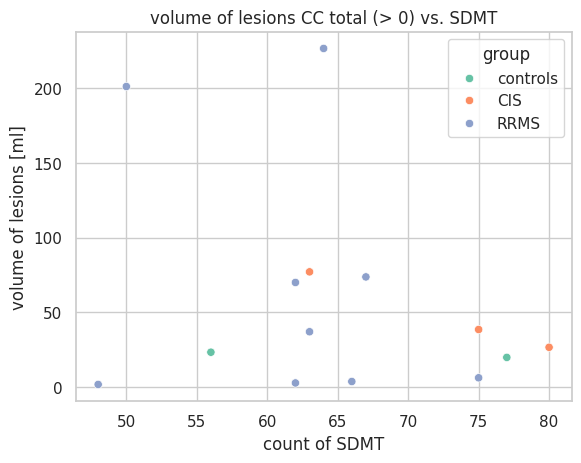

In [202]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='SDMT', y='total_roi_lv', hue='group')
g.set_xlabel("count of SDMT")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total (> 0) vs. SDMT")

### !!! total_roi_lv CC vs. SDMT

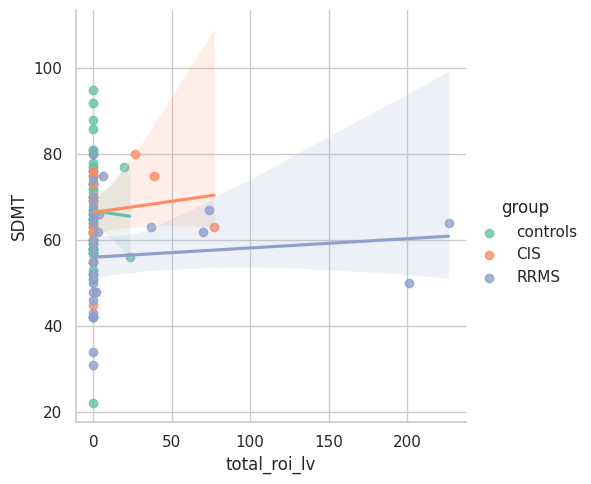

In [203]:
g = sns.lmplot(data=cc_df, y='SDMT', x='total_roi_lv', hue='group')

In [204]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lv']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lv'], cc_df.query('group=="RRMS"')['SDMT'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lv'], cc_df.query('group=="CIS"')['SDMT'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lv'], cc_df.query('group=="controls"')['SDMT'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.06665825312836234 , p-Wert: 0.14686746213159038
CIS- r²: 0.0905069819105046 , p-Wert: 0.27590143760195857
controls- r²: 0.0007950300011321182 , p-Wert: 0.8365694212601531


### !!! total_roi_lesion_fraction CC vs. SDMT

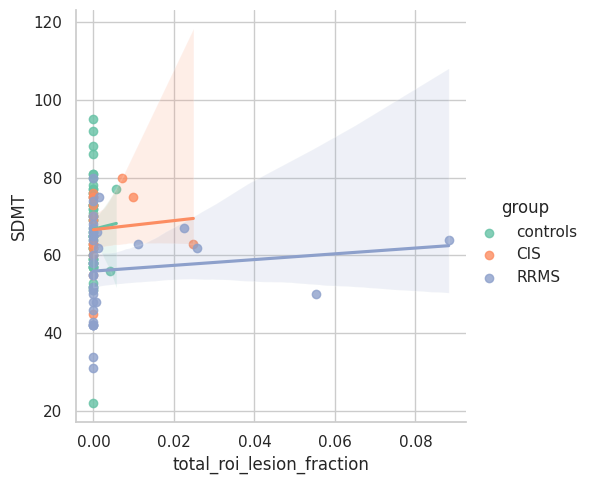

In [205]:
g = sns.lmplot(data=cc_df, y='SDMT', x='total_roi_lesion_fraction', hue='group')

In [206]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lesion_fraction']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_fraction'], cc_df.query('group=="RRMS"')['SDMT'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_fraction'], cc_df.query('group=="CIS"')['SDMT'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_fraction'], cc_df.query('group=="controls"')['SDMT'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.06361018218733618 , p-Wert: 0.1567799202422878
CIS- r²: 0.0905069819105046 , p-Wert: 0.27590143760195857
controls- r²: 0.0003791350617004416 , p-Wert: 0.8867343817487525


### CC lesion count (> 0) vs. SDMT 

Text(0.5, 1.0, 'count of lesions CC total vs. SDMT')

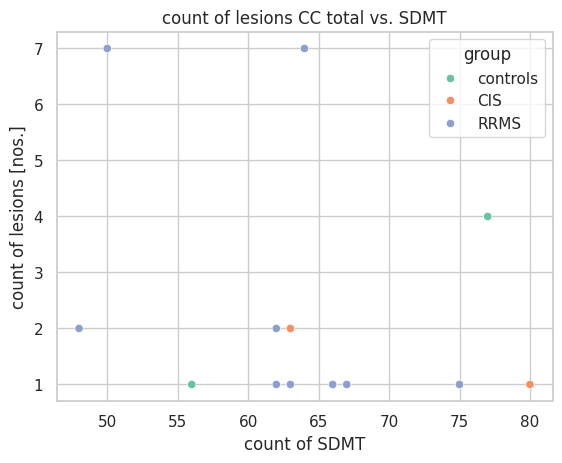

In [207]:
g = sns.scatterplot(data=cc_df.query('total_roi_lesion_count != 0'), x='SDMT', y='total_roi_lesion_count', hue='group')
g.set_xlabel("count of SDMT")
g.set_ylabel("count of lesions [nos.]")
g.set_title("count of lesions CC total vs. SDMT")

### !!! total_roi_lesion_count CC vs. SDMT

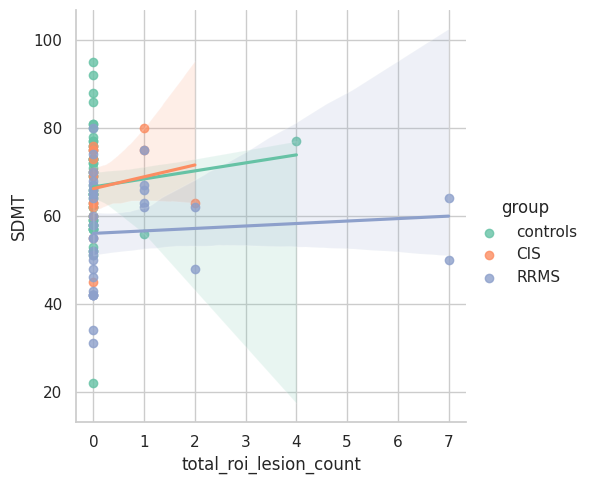

In [208]:
g = sns.lmplot(data=cc_df, y='SDMT', x='total_roi_lesion_count', hue='group')

In [209]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lesion_count']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_count'], cc_df.query('group=="RRMS"')['SDMT'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_count'], cc_df.query('group=="CIS"')['SDMT'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_count'], cc_df.query('group=="controls"')['SDMT'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.04526215182960131 , p-Wert: 0.23456021977718047
CIS- r²: 0.09555661729574776 , p-Wert: 0.26224546283598044
controls- r²: 0.0003791350617004416 , p-Wert: 0.8867343817487525


## Balken vs. BVMT-R

### CC lesionsvolume (> 0) vs. BVMT-R

Text(0.5, 1.0, 'volume of lesions CC total (> 0) vs. BVMT-R total')

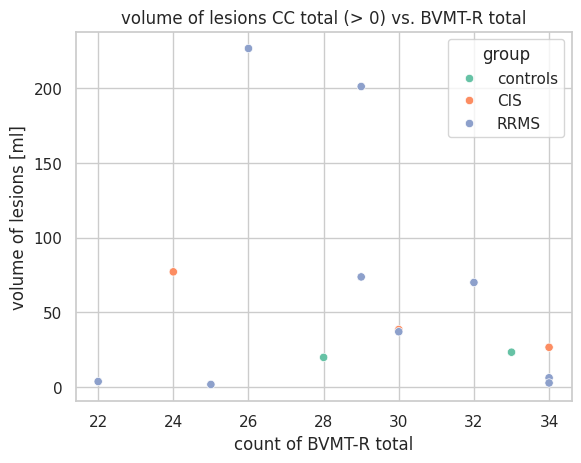

In [210]:
g = sns.scatterplot(data=cc_df.query('total_roi_lv != 0'), x='BVMT-R_Total', y='total_roi_lv', hue='group')
# plt.plot('BVMT-R_Total', cc_df.query('total_roi_lv != 0'), marker='0', linestyle='-', color='b') - geht nicht ...
g.set_xlabel("count of BVMT-R total")
g.set_ylabel("volume of lesions [ml]")
g.set_title("volume of lesions CC total (> 0) vs. BVMT-R total")

### !!! total_roi_lv CC vs. BVMT-R

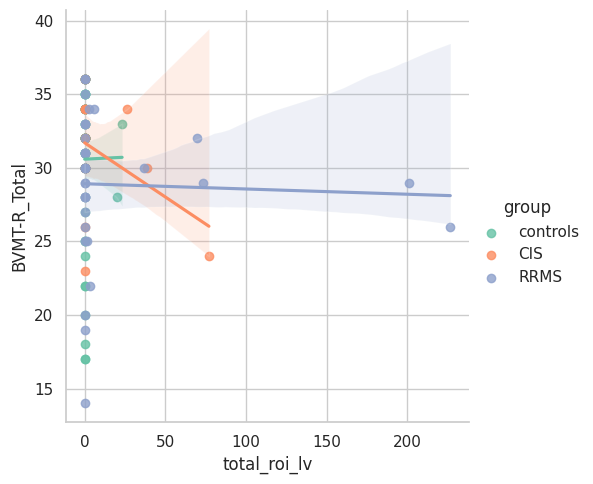

In [211]:
g = sns.lmplot(data=cc_df, y='BVMT-R_Total', x='total_roi_lv', hue='group')

In [212]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lv']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lv'], cc_df.query('group=="RRMS"')['BVMT-R_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lv'], cc_df.query('group=="CIS"')['BVMT-R_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lv'], cc_df.query('group=="controls"')['BVMT-R_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.0011049807704259387 , p-Wert: 0.854292726515524
CIS- r²: 0.05994084606409247 , p-Wert: 0.37915786008565655
controls- r²: 0.00204284626974991 , p-Wert: 0.7408179722655536


### !!! total_roi_lesion_fraction CC vs. BVMT-R

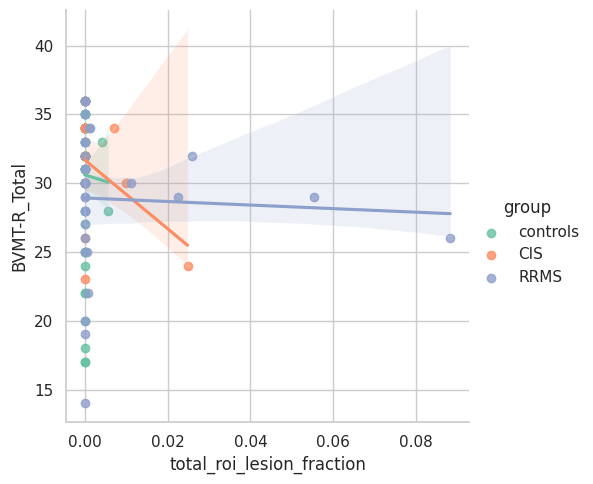

In [213]:
g = sns.lmplot(data=cc_df, y='BVMT-R_Total', x='total_roi_lesion_fraction', hue='group')

In [214]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lesion_fraction']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_fraction'], cc_df.query('group=="RRMS"')['BVMT-R_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_fraction'], cc_df.query('group=="CIS"')['BVMT-R_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_fraction'], cc_df.query('group=="controls"')['BVMT-R_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.0003110296778863555 , p-Wert: 0.9223989660364443
CIS- r²: 0.05994084606409247 , p-Wert: 0.37915786008565655
controls- r²: 0.002577314798085908 , p-Wert: 0.710206639128071


### CC lesion count (> 0) vs. BVMT-R

Text(0.5, 1.0, 'count of lesions CC total (> 0) vs. BVMT-R total')

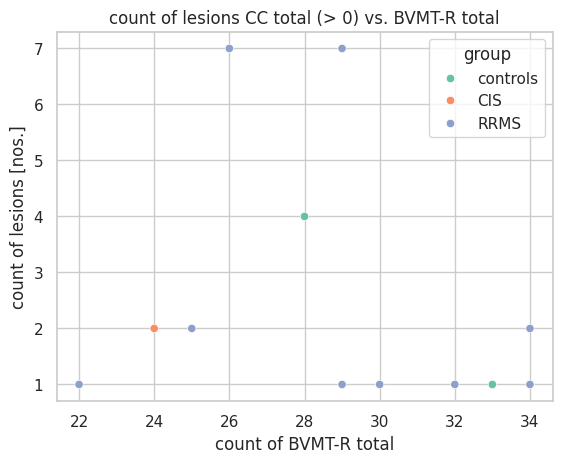

In [215]:
g = sns.scatterplot(data=cc_df.query('total_roi_lesion_count != 0'), x='BVMT-R_Total', y='total_roi_lesion_count', hue='group')
# plt.plot('BVMT-R_Total', cc_df.query('total_roi_lv != 0'), marker='0', linestyle='-', color='b') - geht nicht ...
g.set_xlabel("count of BVMT-R total")
g.set_ylabel("count of lesions [nos.]")
g.set_title("count of lesions CC total (> 0) vs. BVMT-R total")

### !!! total_roi_lesion_count CC vs. BVMT-R

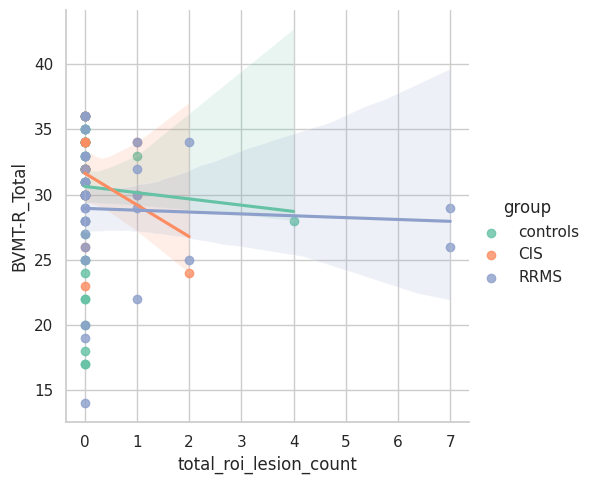

In [216]:
g = sns.lmplot(data=cc_df, y='BVMT-R_Total', x='total_roi_lesion_count', hue='group')


In [217]:
from scipy.stats import spearmanr
# df['total_roi_lesion_lesion_count']=cc_df

# Korr. RRMS
korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_roi_lesion_count'], cc_df.query('group=="RRMS"')['BVMT-R_Total'], nan_policy='omit')
print("RRMS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. CIS
korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_roi_lesion_count'], cc_df.query('group=="CIS"')['BVMT-R_Total'], nan_policy='omit')
print("CIS-", "r²:", korrelation**2, ", p-Wert:", p_wert)

# Korr. HC
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_roi_lesion_count'], cc_df.query('group=="controls"')['BVMT-R_Total'], nan_policy='omit')
print("controls-", "r²:", korrelation**2, ", p-Wert:", p_wert)

RRMS- r²: 0.002358476904490013 , p-Wert: 0.7884059934664867
CIS- r²: 0.05272546536487058 , p-Wert: 0.4103657846774694
controls- r²: 0.002577314798085908 , p-Wert: 0.710206639128071


# EDSS und Läsionen - Korrelation

#### läsionsvolumen gesamt vs. EDSS

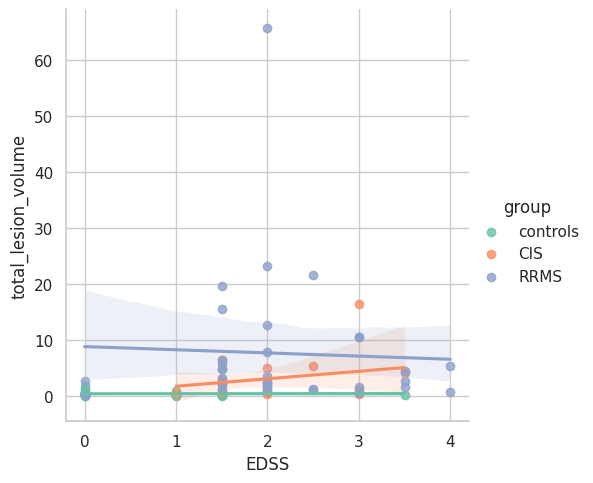

In [218]:
g = sns.lmplot(data=cc_df, y='total_lesion_volume', x='EDSS', hue='group')

#### Korrelation Lesionsvolumen vs. EDSS

In [219]:
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_lesion_volume'], cc_df.query('group=="controls"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_lesion_volume'], cc_df.query('group=="CIS"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_lesion_volume'], cc_df.query('group=="RRMS"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

controls- r²: 0.0151 p-Wert: 0.3755
controls- r²: 0.0041 p-Wert: 0.8201
controls- r²: 0.0118 p-Wert: 0.5475


#### läsionsanzahl gesamt vs. EDSS

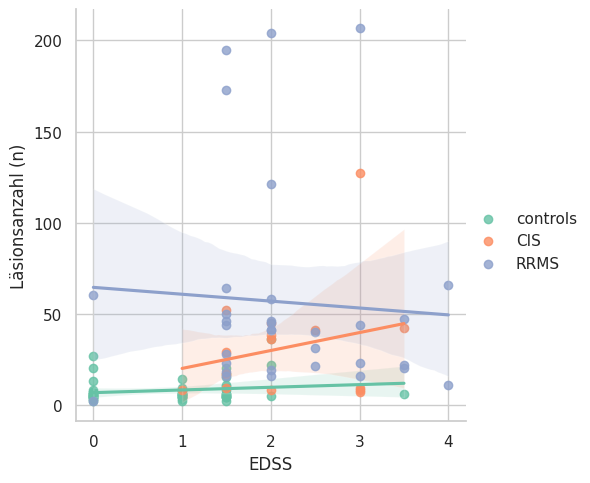

In [220]:
g = sns.lmplot(data=cc_df, y='total_lesion_count', x='EDSS', hue='group')
g.set_axis_labels("EDSS","Läsionsanzahl (n)")
g.legend.set_title("")

#### Korrelation Läsoionsanzahl vs. EDSS

In [221]:
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_lesion_count'], cc_df.query('group=="controls"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

korrelation, p_wert = spearmanr(cc_df.query('group=="CIS"')['total_lesion_count'], cc_df.query('group=="CIS"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

korrelation, p_wert = spearmanr(cc_df.query('group=="RRMS"')['total_lesion_count'], cc_df.query('group=="RRMS"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen

controls- r²: 0.0299 p-Wert: 0.2113
controls- r²: 0.0069 p-Wert: 0.7688
controls- r²: 0.0127 p-Wert: 0.5330


# Tabelle korrelationen

In [222]:
def corr_spearman_r(x,y):
    r,p = spearmanr(x,y)

    return r**2

def corr_spearman_p(x,y):
    r,p = spearmanr(x,y)

    return p
with pd.ExcelWriter('correlation.xlsx') as writer:
    for group in ["controls", "CIS", "RRMS"]:
        print(f"Gruppe {group}")
        display("R²-Values:")
        display(df.query('group == @group')[['bpf', 'total_lesion_count', 'total_lesion_volume', 'SDMT', 'CVLT_Total', 'BVMT-R_Total']].corr(corr_spearman_r))
        display("P-Values:")
        display(df.query('group == @group')[['bpf', 'total_lesion_count', 'total_lesion_volume', 'SDMT', 'CVLT_Total', 'BVMT-R_Total']].corr(corr_spearman_p))
        
        df.query('group == @group')[['bpf', 'total_lesion_count', 'total_lesion_volume', 'SDMT', 'CVLT_Total', 'BVMT-R_Total']].corr(corr_spearman_r).to_excel(writer, sheet_name=f'r-{group}', float_format="%.4f")
        df.query('group == @group')[['bpf', 'total_lesion_count', 'total_lesion_volume', 'SDMT', 'CVLT_Total', 'BVMT-R_Total']].corr(corr_spearman_p).to_excel(writer, sheet_name=f'p-{group}', float_format="%.4f")

Gruppe controls


'R²-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000            0.043655             0.003792   
total_lesion_count   0.043655            1.000000             0.472769   
total_lesion_volume  0.003792            0.472769             1.000000   
SDMT                 0.155139            0.011504             0.006361   
CVLT_Total           0.000262            0.009131             0.000813   
BVMT-R_Total         0.030077            0.009376             0.000442   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.155139    0.000262      0.030077  
total_lesion_count   0.011504    0.009131      0.009376  
total_lesion_volume  0.006361    0.000813      0.000442  
SDMT                 1.000000    0.059792      0.074646  
CVLT_Total           0.059792    1.000000      0.045860  
BVMT-R_Total         0.074646    0.045860      1.000000

'P-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000        1.122576e-01         6.431350e-01   
total_lesion_count   0.112258        1.000000e+00         1.794424e-09   
total_lesion_volume  0.643135        1.794424e-09         1.000000e+00   
SDMT                 0.002669        4.313883e-01         5.590030e-01   
CVLT_Total           0.905819        4.835743e-01         8.347522e-01   
BVMT-R_Total         0.201162        4.777366e-01         8.777523e-01   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.002669    0.905819      0.201162  
total_lesion_count   0.431388    0.483574      0.477737  
total_lesion_volume  0.559003    0.834752      0.877752  
SDMT                 1.000000    0.069330      0.041612  
CVLT_Total           0.069330    1.000000      0.113001  
BVMT-R_Total         0.041612    0.113001      1.000000

Gruppe CIS


'R²-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000            0.323324             0.290829   
total_lesion_count   0.323324            1.000000             0.880080   
total_lesion_volume  0.290829            0.880080             1.000000   
SDMT                 0.000116            0.034629             0.074741   
CVLT_Total           0.000115            0.002103             0.037394   
BVMT-R_Total         0.004066            0.006782             0.014900   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.000116    0.000115      0.004066  
total_lesion_count   0.034629    0.002103      0.006782  
total_lesion_volume  0.074741    0.037394      0.014900  
SDMT                 1.000000    0.028738      0.097314  
CVLT_Total           0.028738    1.000000      0.097009  
BVMT-R_Total         0.097314    0.097009      1.000000

'P-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000        2.697768e-02         3.802166e-02   
total_lesion_count   0.026978        1.000000e+00         2.361990e-07   
total_lesion_volume  0.038022        2.361990e-07         1.000000e+00   
SDMT                 0.969552        5.066690e-01         3.241702e-01   
CVLT_Total           0.969689        8.710679e-01         4.898611e-01   
BVMT-R_Total         0.821384        7.704596e-01         6.647478e-01   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.969552    0.969689      0.821384  
total_lesion_count   0.506669    0.871068      0.770460  
total_lesion_volume  0.324170    0.489861      0.664748  
SDMT                 1.000000    0.545843      0.257673  
CVLT_Total           0.545843    1.000000      0.258461  
BVMT-R_Total         0.257673    0.258461      1.000000

Gruppe RRMS


'R²-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000            0.260268             0.259329   
total_lesion_count   0.260268            1.000000             0.577797   
total_lesion_volume  0.259329            0.577797             1.000000   
SDMT                 0.028086            0.002421             0.000414   
CVLT_Total           0.141132            0.007690             0.017723   
BVMT-R_Total         0.206005            0.037079             0.056931   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.028086    0.141132      0.206005  
total_lesion_count   0.002421    0.007690      0.037079  
total_lesion_volume  0.000414    0.017723      0.056931  
SDMT                 1.000000    0.323887      0.157835  
CVLT_Total           0.323887    1.000000      0.035703  
BVMT-R_Total         0.157835    0.035703      1.000000

'P-Values:'

bpf  total_lesion_count  total_lesion_volume  \
bpf                  1.000000        1.742645e-03         1.782172e-03   
total_lesion_count   0.001743        1.000000e+00         1.177480e-07   
total_lesion_volume  0.001782        1.177480e-07         1.000000e+00   
SDMT                 0.335900        7.789488e-01         9.076943e-01   
CVLT_Total           0.026150        6.164276e-01         4.458248e-01   
BVMT-R_Total         0.006169        2.677592e-01         1.674779e-01   

                         SDMT  CVLT_Total  BVMT-R_Total  
bpf                  0.335900    0.026150      0.006169  
total_lesion_count   0.778949    0.616428      0.267759  
total_lesion_volume  0.907694    0.445825      0.167478  
SDMT                 1.000000    0.000360      0.018118  
CVLT_Total           0.000360    1.000000      0.276999  
BVMT-R_Total         0.018118    0.276999      1.000000

# spearman - mit r² und p

In [223]:
from scipy.stats import spearmanr
# df['total_roi_lv']=cc_df
korrelation, p_wert = spearmanr(cc_df.query('group=="controls"')['total_lesion_count'], cc_df.query('group=="controls"')['EDSS'], nan_policy='omit')
# print("r²:", korrelation**2, ", p-Wert:", p_wert)
print("controls-", f"r²: {korrelation**2:0.4f} p-Wert: {p_wert:0.4f}") # nur noch 4 nachkomma-Stellen



# Beispiel für die Berechnung der Spearman-Korrelation zwischen ... und ...
# from scipy.stats import spearmanr
# korrelation, p_wert = spearmanr(df['Age'], df['SDMT'], nan_policy='omit')
# print("Spearman-Korrelation:", korrelation, ", p-Wert:", p_wert)

# spearman_corr = df[['Age', 'SDMT', 'bpf']].corr(method='spearman')
# print("Spearman-Korrelation:\n", spearman_corr)


controls- r²: 0.0299 p-Wert: 0.2113


# Tabelle Gruppen, CC und NP

Wunschtabelle:
    Anzahl und Volumen (evtl. Fraktion) Läsionen (gesamt, wm und gm, brain seg. vol. und bpf), mit mittelwert und SD
    Punktzahl jeweils der NP's (mittelwert und sd)
    lesionsvolume, -count und -fraction im Balken (gesamt, da die Auswertung der einzelnen Fraktionen des Balkens mehr Signifikanz voraussetzen würde???) mit Mittelwert und SD


Wunsch: Z-Werte für läsionsanzahl und -volumen, wm und gm, bsv und bpf


Wunsch-df (lesionscount und -volume gesamt) mit group oder group-name und EDSS


Wunschabfrage: Krankheitsdauer (DoD) im Mittelwert und mit SD


In [224]:
cc_df.groupby(by=['group']).agg({
    'total_roi_lv': [],
    'total_roi_lesion_count': [] ,
    'total_roi_lesion_fraction': [],
    'SDMT': [],
    'CVLT_Total': [],
    'BVMT-R_Total': []         
                              }).transpose()

# geht nicht

Empty DataFrame
Columns: []
Index: []

In [225]:

df.groupby(by=['group']).agg({
    'Age': ['mean', 'std'], 
    'EDSS': ['mean', 'std'],
    'Sex' : [lambda x: x[x=='f'].str.len().sum(),
            lambda x: x[x=='m'].str.len().sum() ]                  
                              }).transpose()

group                  CIS       RRMS   controls
Age  mean        31.666667  37.742857  34.237288
     std          7.403345   7.321776   9.976419
EDSS mean         2.200000   2.157143   0.888889
     std          0.751190   0.929670   0.768892
Sex  <lambda_0>  11.000000  20.000000  38.000000
     <lambda_1>   4.000000  15.000000  21.000000

# Z-Scores

## SDMT

In [226]:
class Zscore:
    def __init__(self, values):
        self.mean = values.mean()
        self.std = values.std()

    def get_zscore(self, value):
        result = (value - self.mean) / self.std

        return result


sdmt_zscore = Zscore(df.query('group=="controls"').SDMT)

display(sdmt_zscore.get_zscore(df.query('group=="CIS"').SDMT))
display(sdmt_zscore.get_zscore(df.query('group=="RRMS"').SDMT))

# sdmt_zscore.get_zscore(df.query('group=="controls"').SDMT)

59   -0.315748
60    0.689856
61   -0.399548
62    0.270854
63    0.522255
64    0.773656
65    0.689856
66   -0.315748
67   -0.567148
68    0.187054
69    1.108857
70    0.689856
71   -0.986150
72   -1.824153
73   -0.315748
Name: SDMT, dtype: float64

74    -0.986150
75    -1.991753
76     0.019454
77    -0.986150
78    -0.734749
79     0.270854
80    -0.231947
81    -1.740352
82    -0.064347
83    -0.567148
84    -2.075554
85    -1.405151
86     0.103254
87    -1.572752
88    -2.997357
89    -1.572752
90    -2.075554
91    -0.148147
92    -2.075554
93    -0.399548
94    -1.405151
95     0.689856
96    -1.237551
97    -0.231947
98    -1.321351
99    -0.064347
100   -2.745956
101   -2.075554
102   -0.315748
103   -0.148147
104    0.606056
105   -0.399548
106    0.019454
107   -1.237551
108    1.108857
Name: SDMT, dtype: float64

## CVLT, total

<Axes: xlabel='group', ylabel='z_cvlt'>

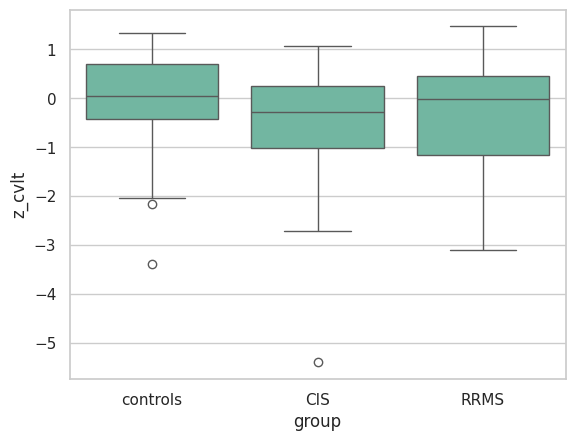

In [227]:
cvlt_zscore = Zscore(df.query('group=="controls"').CVLT_Total )
df["z_cvlt"] = cvlt_zscore.get_zscore(df.CVLT_Total)

sns.boxplot(df, x="group", y="z_cvlt")


## BVMT-R, total

# Korrelationen und Signifikanzen

## Berechnung Korrelation (spearman - Rangkorrelationskoeffizienz) allgemein

In [228]:
from scipy import stats

gruppe1 = df[df['Group'] == 0]
gruppe2 = df[df['Group'] == 1]
gruppe3 = df[df['Group'] == 2]
gruppe4 = df[df['Group'] == 3]

spearman_corr = df[['Age', 'SDMT', 'bpf']].corr(method='spearman')
print("Spearman-Korrelation:\n", spearman_corr)

# Beispiel für die Berechnung der Spearman-Korrelation zwischen ... und ...
from scipy.stats import spearmanr
korrelation, p_wert = spearmanr(df['Age'], df['SDMT'], nan_policy='omit')
print("Spearman-Korrelation:", korrelation, ", p-Wert:", p_wert)
korrelation, p_wert = spearmanr(df['Age'], df['bpf'], nan_policy='omit')
print("Spearman-Korrelation:", korrelation, ", p-Wert:", p_wert)
korrelation, p_wert = spearmanr(df['SDMT'], df['bpf'], nan_policy='omit')
print("Spearman-Korrelation:", korrelation, ", p-Wert:", p_wert)

# Beispiel für Berechnung Mann-Whitney-U-Test - Age. SDMT und bpf
mann_whitney_u = stats.mannwhitneyu(gruppe1['Age'], gruppe2['Age'], nan_policy='omit')
print("Mann-Whitney U-Test, Alter Kontrollen vs. CIS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe2['Age'], gruppe3['Age'], nan_policy='omit')
print("Mann-Whitney U-Test, Alter CIS vs.RRMS 3: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe1['Age'], gruppe3['Age'], nan_policy='omit')
print("Mann-Whitney U-Test, Alter Kontrollen vs. RRMS 3: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)

mann_whitney_u = stats.mannwhitneyu(gruppe1['SDMT'], gruppe2['SDMT'], nan_policy='omit')
print("Mann-Whitney U-Test, SDMT Kontrollen vs. CIS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe2['SDMT'], gruppe3['SDMT'], nan_policy='omit')
print("Mann-Whitney U-Test, SDMT CIS vs. RRMS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe1['SDMT'], gruppe3['SDMT'], nan_policy='omit')
print("Mann-Whitney U-Test, SDMT Kontrollen vs. RRMS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)

mann_whitney_u = stats.mannwhitneyu(gruppe1['bpf'], gruppe2['bpf'], nan_policy='omit')
print("Mann-Whitney U-Test, bpf Kontrollen vs. CIS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe2['bpf'], gruppe3['bpf'], nan_policy='omit')
print("Mann-Whitney U-Test, bpf CIS vs. RRMS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)
mann_whitney_u = stats.mannwhitneyu(gruppe1['bpf'], gruppe3['bpf'], nan_policy='omit')
print("Mann-Whitney U-Test, bpf Kontrollen vs. RRMS: U-Statistik =", mann_whitney_u.statistic, ", p-Wert =", mann_whitney_u.pvalue)

Spearman-Korrelation:
            Age      SDMT       bpf
Age   1.000000 -0.294123 -0.494234
SDMT -0.294123  1.000000  0.355603
bpf  -0.494234  0.355603  1.000000
Spearman-Korrelation: -0.2941234490443001 , p-Wert: 0.0022113577513211964
Spearman-Korrelation: -0.4942344420116901 , p-Wert: 4.7143261765248165e-08
Spearman-Korrelation: 0.35560334879188776 , p-Wert: 0.00018344140052398654
Mann-Whitney U-Test, Alter Kontrollen vs. CIS: U-Statistik = 464.5 , p-Wert = 0.47431171775221703
Mann-Whitney U-Test, Alter CIS vs.RRMS 3: U-Statistik = 155.0 , p-Wert = 0.03679646165121914
Mann-Whitney U-Test, Alter Kontrollen vs. RRMS 3: U-Statistik = 819.0 , p-Wert = 0.06257503216661554
Mann-Whitney U-Test, SDMT Kontrollen vs. CIS: U-Statistik = 367.5 , p-Wert = 0.72431282526417
Mann-Whitney U-Test, SDMT CIS vs. RRMS: U-Statistik = 377.0 , p-Wert = 0.007078020575544101
Mann-Whitney U-Test, SDMT Kontrollen vs. RRMS: U-Statistik = 1453.5 , p-Wert = 0.00036754715236104107
Mann-Whitney U-Test, bpf Kontroll

In [229]:
spearmanr(df['Age'].to_list(), df['SDMT'].to_list(), nan_policy='omit')



SignificanceResult(statistic=np.float64(-0.2941234490443001), pvalue=np.float64(0.0022113577513211964))